**1. Prepare the suitable library.**

In [1]:
get_ipython().system(u' pip install beautifulsoup4')

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Done.')

Solving environment: ...working... done

# All requested packages already installed.

Done.


**2. Extract data of borough and neighborhood of NY.**

In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [5]:
ny_data.shape

(306, 4)

**3. Get latitude and longitude of NY.**

In [6]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [7]:
geo_location('New York City, NY')

(40.7127281, -74.0060152)

In [8]:
mapNYC = folium.Map(location=geo_location('New York City, NY'), zoom_start=10)

for lat, lng, borough, neighborhood in zip(ny_data['Latitude'], 
                                           ny_data['Longitude'], 
                                           ny_data['Borough'], 
                                           ny_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapNYC)  
    
mapNYC

**4. Get data from Foursquare.**

In [9]:
CLIENT_ID = 'VGNX0MWXKFAIUV4CLZDNUSRWSOYJHOOLUFE4SWUMQP3KG25D'
CLIENT_SECRET = 'G4LHAQLNHSO2QBJFHMAMXNKJ5R5MD4RXAJPV4WESRUYROTU3'
VERSION = '20201201'

In [10]:
def get_venues(lat,lng):
    radius=500
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
pizzaPlaceNY=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    pizzaPlace=venues[venues['Category']=='Pizza Place']   
    print(count,'of',len(ny_data),'- Pizza place in '+Neighborhood+', '+Borough+': '+str(len(pizzaPlace)))
    print(row)
    for resturant_detail in pizzaPlace.values.tolist():
        id, name , category=resturant_detail
        pizzaPlaceNY = pizzaPlaceNY.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

1 of 306 - Pizza place in Wakefield, Bronx: 0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
2 of 306 - Pizza place in Co-op City, Bronx: 1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
3 of 306 - Pizza place in Eastchester, Bronx: 1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
4 of 306 - Pizza place in Fieldston, Bronx: 0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
5 of 306 - Pizza place in Riverdale, Bronx: 0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
6 of 306 - Pizza place in Kingsbridge, Bronx: 6
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
7 of 306 - Pizza place in Marble Hill, Manhattan: 1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
8 of 306 - Pizza place in Woodlawn, Bronx: 2
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
9 of 306 - Pizza place in Norwood, Bronx: 5
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
10 of 306 - Piz

72 of 306 - Pizza place in Cypress Hills, Brooklyn: 1
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
73 of 306 - Pizza place in East New York, Brooklyn: 1
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
74 of 306 - Pizza place in Starrett City, Brooklyn: 1
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
75 of 306 - Pizza place in Canarsie, Brooklyn: 0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
76 of 306 - Pizza place in Flatlands, Brooklyn: 0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
77 of 306 - Pizza place in Mill Island, Brooklyn: 0
['Brooklyn', 'Mill Island', 40.606336421685626, -73.90818571777423]
78 of 306 - Pizza place in Manhattan Beach, Brooklyn: 0
['Brooklyn', 'Manhattan Beach', 40.57791350308657, -73.94353722891886]
79 of 306 - Pizza place in Coney Island, Brooklyn: 1
['Brooklyn', 'Coney Island', 40.57429256471601, -73.98868295821637]
80 of 306 - Pizza place in Bath B

140 of 306 - Pizza place in Long Island City, Queens: 4
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
141 of 306 - Pizza place in Sunnyside, Queens: 5
['Queens', 'Sunnyside', 40.74017628351924, -73.92691617561577]
142 of 306 - Pizza place in East Elmhurst, Queens: 0
['Queens', 'East Elmhurst', 40.76407323883091, -73.86704147658772]
143 of 306 - Pizza place in Maspeth, Queens: 3
['Queens', 'Maspeth', 40.725427374093606, -73.89621713626859]
144 of 306 - Pizza place in Ridgewood, Queens: 3
['Queens', 'Ridgewood', 40.70832315613858, -73.90143517559589]
145 of 306 - Pizza place in Glendale, Queens: 1
['Queens', 'Glendale', 40.70276242967838, -73.87074167435605]
146 of 306 - Pizza place in Rego Park, Queens: 2
['Queens', 'Rego Park', 40.72897409480735, -73.8578268690537]
147 of 306 - Pizza place in Woodhaven, Queens: 1
['Queens', 'Woodhaven', 40.68988687915789, -73.8581104655432]
148 of 306 - Pizza place in Ozone Park, Queens: 2
['Queens', 'Ozone Park', 40.68070846826

210 of 306 - Pizza place in New Springville, Staten Island: 2
['Staten Island', 'New Springville', 40.594252379161695, -74.16496031329827]
211 of 306 - Pizza place in Travis, Staten Island: 0
['Staten Island', 'Travis', 40.58631375103281, -74.19073717538116]
212 of 306 - Pizza place in New Dorp, Staten Island: 2
['Staten Island', 'New Dorp', 40.57257231820632, -74.1164794360638]
213 of 306 - Pizza place in Oakwood, Staten Island: 0
['Staten Island', 'Oakwood', 40.5584622432888, -74.12156593771896]
214 of 306 - Pizza place in Great Kills, Staten Island: 2
['Staten Island', 'Great Kills', 40.549480228713605, -74.14932381490992]
215 of 306 - Pizza place in Eltingville, Staten Island: 5
['Staten Island', 'Eltingville', 40.542230747450745, -74.1643308041936]
216 of 306 - Pizza place in Annadale, Staten Island: 2
['Staten Island', 'Annadale', 40.53811417474507, -74.17854866165878]
217 of 306 - Pizza place in Woodrow, Staten Island: 1
['Staten Island', 'Woodrow', 40.541967622888755, -74.20524

276 of 306 - Pizza place in Stuyvesant Town, Manhattan: 0
['Manhattan', 'Stuyvesant Town', 40.73099955477061, -73.97405170469203]
277 of 306 - Pizza place in Flatiron, Manhattan: 0
['Manhattan', 'Flatiron', 40.739673047638426, -73.9909471052826]
278 of 306 - Pizza place in Sunnyside Gardens, Queens: 4
['Queens', 'Sunnyside Gardens', 40.74565180608076, -73.91819286431682]
279 of 306 - Pizza place in Blissville, Queens: 0
['Queens', 'Blissville', 40.73725071694497, -73.93244235260178]
280 of 306 - Pizza place in Fulton Ferry, Brooklyn: 2
['Brooklyn', 'Fulton Ferry', 40.70328109093014, -73.99550751888415]
281 of 306 - Pizza place in Vinegar Hill, Brooklyn: 0
['Brooklyn', 'Vinegar Hill', 40.70332149882874, -73.98111603592393]
282 of 306 - Pizza place in Weeksville, Brooklyn: 0
['Brooklyn', 'Weeksville', 40.67503986503237, -73.93053108817338]
283 of 306 - Pizza place in Broadway Junction, Brooklyn: 1
['Brooklyn', 'Broadway Junction', 40.67786104769531, -73.90331684852599]
284 of 306 - Pizza

In [11]:
pizzaPlaceNY.to_csv('pizzaPlaceNY.csv')

In [122]:
dfPizzaPlaceNY = pd.read_csv('pizzaPlaceNY.csv')

In [123]:
dfPizzaPlaceNY.head()

Unnamed: 0 Borough Neighborhood                        ID  \
0           0   Bronx   Co-op City  4d2cfa5cad25224bbbc5fb8f   
1           1   Bronx  Eastchester  4c632f1cde1b2d7fed31e470   
2           2   Bronx  Kingsbridge  58935fd798f8aa7c14662653   
3           3   Bronx  Kingsbridge  4bb114c4f964a520b9783ce3   
4           4   Bronx  Kingsbridge  4be72770910020a16f1ad514   

                      Name  
0           Capri II Pizza  
1            Mario's Pizza  
2  Kingsbridge Social Club  
3              Sam's Pizza  
4   Broadway Pizza & Pasta

In [124]:
dfPizzaPlaceNY.shape

(437, 5)

Apparently there are 437 pizza place in NYC.

In [125]:
del dfPizzaPlaceNY['Unnamed: 0']

In [15]:
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [16]:
column_names = ['Borough','Neighborhood','ID','Name','Likes','Rating','Tips']
pizzaPlaceNYdetail = pd.DataFrame(columns = column_names)
count = 1
for row in dfPizzaPlaceNY.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=', ID)
        id, name, likes, rating, tips = [0]*5
    print('(',count,'/',len(dfPizzaPlaceNY),')','processed')
    pizzaPlaceNYdetail = pizzaPlaceNYdetail.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

pizzaPlaceNYdetail

{'meta': {'code': 200, 'requestId': '5fd905da9e3c0852771330ea'}, 'response': {'venue': {'id': '4d2cfa5cad25224bbbc5fb8f', 'name': 'Capri II Pizza', 'contact': {}, 'location': {'address': 'Dreiser Loop', 'lat': 40.87637420537464, 'lng': -73.82994042507629, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87637420537464, 'lng': -73.82994042507629}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Dreiser Loop', 'New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/capri-ii-pizza/4d2cfa5cad25224bbbc5fb8f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'fi

{'meta': {'code': 200, 'requestId': '5fd905dbe3f54d32449314ef'}, 'response': {'venue': {'id': '58935fd798f8aa7c14662653', 'name': 'Kingsbridge Social Club', 'contact': {'phone': '3473465180', 'formattedPhone': '(347) 346-5180', 'twitter': 'kingsbridgesc', 'facebook': '1790519247938942', 'facebookUsername': 'KingsbridgeSC', 'facebookName': 'Kingsbridge Social Club'}, 'location': {'address': '3625 Kingsbridge Ave', 'lat': 40.884581, 'lng': -73.901999, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.884542, 'lng': -73.901935}, {'label': 'display', 'lat': 40.884581, 'lng': -73.901999}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3625 Kingsbridge Ave', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kingsbridge-social-club/58935fd798f8aa7c14662653', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'p

{'meta': {'code': 200, 'requestId': '5fd905dce1ccea075002caf6'}, 'response': {'venue': {'id': '4bb114c4f964a520b9783ce3', 'name': "Sam's Pizza", 'contact': {'phone': '7185489070', 'formattedPhone': '(718) 548-9070', 'twitter': 'samspizza'}, 'location': {'address': '232 W 231st St', 'crossStreet': 'Godwin Terrace', 'lat': 40.87943501792795, 'lng': -73.90585879861192, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87943501792795, 'lng': -73.90585879861192}, {'label': 'entrance', 'lat': 40.879412, 'lng': -73.906056}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['232 W 231st St (Godwin Terrace)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sams-pizza/4bb114c4f964a520b9783ce3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix':

{'meta': {'code': 200, 'requestId': '5fd905dd4bf6557d3577e7bb'}, 'response': {'venue': {'id': '4be72770910020a16f1ad514', 'name': 'Broadway Pizza & Pasta', 'contact': {'phone': '7186015000', 'formattedPhone': '(718) 601-5000', 'twitter': 'broadwaypizza_'}, 'location': {'address': '192 W 231st St', 'lat': 40.87882247136464, 'lng': -73.90449402840686, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87882247136464, 'lng': -73.90449402840686}, {'label': 'entrance', 'lat': 40.878711, 'lng': -73.904585}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['192 W 231st St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/broadway-pizza--pasta/4be72770910020a16f1ad514', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5fd905dee08ec61add5c5fb4'}, 'response': {'venue': {'id': '502bd9a6e4b0bea49203e0aa', 'name': 'Little Caesars Pizza', 'contact': {'phone': '7185435431', 'formattedPhone': '(718) 543-5431', 'twitter': 'littlecaesars'}, 'location': {'address': '5625 Broadway', 'lat': 40.88000167064909, 'lng': -73.90413957385358, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88000167064909, 'lng': -73.90413957385358}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5625 Broadway', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/502bd9a6e4b0bea49203e0aa', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 1}, 'url': 'http://w

{'meta': {'code': 200, 'requestId': '5fd905e094a8241c140deb50'}, 'response': {'venue': {'id': '4b4fbdb5f964a520811327e3', 'name': "Domino's Pizza", 'contact': {'phone': '7186013030', 'formattedPhone': '(718) 601-3030', 'twitter': 'dominos', 'facebook': '354227071347516', 'facebookUsername': 'DominosPizzaBronxNY3611KingsbridgeAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '3611 Kingsbridge Ave', 'lat': 40.8842, 'lng': -73.9024, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8842, 'lng': -73.9024}, {'label': 'entrance', 'lat': 40.884227, 'lng': -73.902291}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3611 Kingsbridge Ave', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4b4fbdb5f964a520811327e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '5fd905e1bac169006638d1d2'}, 'response': {'venue': {'id': '4ba50da6f964a52046d638e3', 'name': 'Katonah Pizza and Pasta', 'contact': {'phone': '7189948337', 'formattedPhone': '(718) 994-8337'}, 'location': {'address': '4307 Katonah Ave', 'lat': 40.89878411126604, 'lng': -73.86745706580207, 'labeledLatLngs': [{'label': 'display', 'lat': 40.89878411126604, 'lng': -73.86745706580207}, {'label': 'entrance', 'lat': 40.898759, 'lng': -73.867558}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4307 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/katonah-pizza-and-pasta/4ba50da6f964a52046d638e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fd905e2dd4fd414b1318e6f'}, 'response': {'venue': {'id': '4c75ad43d8948cfa217b68da', 'name': 'Bella Napoli 2', 'contact': {}, 'location': {'address': '234th street', 'crossStreet': 'Katonah Ave', 'lat': 40.89672979186445, 'lng': -73.86231986737155, 'labeledLatLngs': [{'label': 'display', 'lat': 40.89672979186445, 'lng': -73.86231986737155}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['234th street (Katonah Ave)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bella-napoli-2/4c75ad43d8948cfa217b68da', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'

{'meta': {'code': 200, 'requestId': '5fd905e3bac169006638d8aa'}, 'response': {'venue': {'id': '4b6f0a6cf964a520e0d82ce3', 'name': 'Marconi Pizzeria', 'contact': {'phone': '7187984970', 'formattedPhone': '(718) 798-4970'}, 'location': {'address': '181 E Gun Hill Rd', 'crossStreet': 'btw Bainbridge & Wayne', 'lat': 40.880766406357665, 'lng': -73.87780801932352, 'labeledLatLngs': [{'label': 'display', 'lat': 40.880766406357665, 'lng': -73.87780801932352}, {'label': 'entrance', 'lat': 40.880881, 'lng': -73.877738}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 E Gun Hill Rd (btw Bainbridge & Wayne)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marconi-pizzeria/4b6f0a6cf964a520e0d82ce3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_'

{'meta': {'code': 200, 'requestId': '5fd905e4eaedc31c2633e8db'}, 'response': {'venue': {'id': '4bff3cf9ca1920a1b598ec81', 'name': "Nicky's Pizza & Ristorante", 'contact': {'phone': '7182314813', 'formattedPhone': '(718) 231-4813'}, 'location': {'address': '280 E 204th St', 'crossStreet': 'at Bainbridge Ave', 'lat': 40.87337458632297, 'lng': -73.88050846237203, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87337458632297, 'lng': -73.88050846237203}, {'label': 'entrance', 'lat': 40.8735, 'lng': -73.879231}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['280 E 204th St (at Bainbridge Ave)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nickys-pizza--ristorante/4bff3cf9ca1920a1b598ec81', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 

{'meta': {'code': 200, 'requestId': '5fd905e50c79573f86d08148'}, 'response': {'venue': {'id': '4b75d64af964a5204e282ee3', 'name': "Joseph's Pizza", 'contact': {'phone': '7185150681', 'formattedPhone': '(718) 515-0681'}, 'location': {'address': '283 E. Gunhill Road', 'crossStreet': 'Perry Ave.', 'lat': 40.87920220241614, 'lng': -73.87439641829206, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87920220241614, 'lng': -73.87439641829206}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['283 E. Gunhill Road (Perry Ave.)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/josephs-pizza/4b75d64af964a5204e282ee3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'p

{'meta': {'code': 200, 'requestId': '5fd905e7383e6d764f542e3d'}, 'response': {'venue': {'id': '4b48cef8f964a520f55726e3', 'name': 'Venezia Pizzeria', 'contact': {'phone': '7185477557', 'formattedPhone': '(718) 547-7557'}, 'location': {'address': '1115 Astor Ave', 'crossStreet': 'Yates Ave', 'lat': 40.85981175200528, 'lng': -73.85522374820728, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85981175200528, 'lng': -73.85522374820728}, {'label': 'entrance', 'lat': 40.859852, 'lng': -73.855191}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1115 Astor Ave (Yates Ave)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/venezia-pizzeria/4b48cef8f964a520f55726e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5fd905e8547d005374a5f903'}, 'response': {'venue': {'id': '4c27a574c11dc9b634f32a24', 'name': "Filomena's Pizza & Pasta", 'contact': {'phone': '7188859032', 'formattedPhone': '(718) 885-9032'}, 'location': {'address': '286 City Island Ave', 'lat': 40.846745636130926, 'lng': -73.78618942327299, 'labeledLatLngs': [{'label': 'display', 'lat': 40.846745636130926, 'lng': -73.78618942327299}, {'label': 'entrance', 'lat': 40.846762, 'lng': -73.786159}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['286 City Island Ave', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/filomenas-pizza--pasta/4c27a574c11dc9b634f32a24', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5fd905eab63c40343291132d'}, 'response': {'venue': {'id': '4bd71c916798ef3b563a668d', 'name': 'My Place Family Pizza', 'contact': {'phone': '7185622399', 'formattedPhone': '(718) 562-2399'}, 'location': {'address': '240 E 198th St', 'crossStreet': 'Briggs Ave', 'lat': 40.86926155772971, 'lng': -73.88947570131111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86926155772971, 'lng': -73.88947570131111}, {'label': 'entrance', 'lat': 40.8692, 'lng': -73.889537}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['240 E 198th St (Briggs Ave)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/my-place-family-pizza/4bd71c916798ef3b563a668d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '5fd905ebe8e1164392ae1baa'}, 'response': {'venue': {'id': '53ab09df498e91a454e6d3a5', 'name': 'Bedford Pizza', 'contact': {'phone': '9178010770', 'formattedPhone': '(917) 801-0770'}, 'location': {'address': '380 Bedford Park Blvd', 'lat': 40.867731972856994, 'lng': -73.88408353719713, 'labeledLatLngs': [{'label': 'display', 'lat': 40.867731972856994, 'lng': -73.88408353719713}, {'label': 'entrance', 'lat': 40.867789, 'lng': -73.884273}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['380 Bedford Park Blvd', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bedford-pizza/53ab09df498e91a454e6d3a5', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5fd905edb6bd2d4f4bbb3ff3'}, 'response': {'venue': {'id': '55664d9e498e10d4e57c5647', 'name': "Papa John's Pizza", 'contact': {'phone': '7182957272', 'formattedPhone': '(718) 295-7272', 'twitter': 'papajohns', 'facebook': '182525738458562', 'facebookUsername': 'pj3116', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '1979 Jerome Ave', 'lat': 40.85242931692707, 'lng': -73.90897612147847, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85242931692707, 'lng': -73.90897612147847}], 'postalCode': '10453', 'cc': 'US', 'neighborhood': 'Morris Heights', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1979 Jerome Ave', 'Bronx, NY 10453', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/55664d9e498e10d4e57c5647', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/c

{'meta': {'code': 200, 'requestId': '5fd905ee0223702a3a994dbb'}, 'response': {'venue': {'id': '4b855228f964a520865631e3', 'name': 'My Pizza', 'contact': {'phone': '7182990059', 'formattedPhone': '(718) 299-0059', 'facebook': '139712886049896', 'facebookName': 'My Pizza Inc.'}, 'location': {'address': '1723 Dr Martin L King Jr Blvd', 'crossStreet': 'bwtn 176th St & Macombs Rd', 'lat': 40.849670435102155, 'lng': -73.91681699790597, 'labeledLatLngs': [{'label': 'display', 'lat': 40.849670435102155, 'lng': -73.91681699790597}, {'label': 'entrance', 'lat': 40.849763, 'lng': -73.916878}], 'postalCode': '10453', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1723 Dr Martin L King Jr Blvd (bwtn 176th St & Macombs Rd)', 'Bronx, NY 10453', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/my-pizza/4b855228f964a520865631e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 

{'meta': {'code': 200, 'requestId': '5fd905efbac16900663902c3'}, 'response': {'venue': {'id': '4bf329ef2d62952165ec5f58', 'name': 'Best Italian Pizza', 'contact': {'phone': '7185265806', 'formattedPhone': '(718) 526-5806'}, 'location': {'address': '202 E Fordham Rd', 'crossStreet': 'Grand Concourse', 'lat': 40.86247494823356, 'lng': -73.89689810209401, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86247494823356, 'lng': -73.89689810209401}, {'label': 'entrance', 'lat': 40.862282, 'lng': -73.896737}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['202 E Fordham Rd (Grand Concourse)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/best-italian-pizza/4bf329ef2d62952165ec5f58', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5fd905f27b92187a3b9acd16'}, 'response': {'venue': {'id': '4f21e671d5fb5420c5d76616', 'name': "Papa John's Pizza", 'contact': {'phone': '9177927272', 'formattedPhone': '(917) 792-7272', 'twitter': 'papajohns', 'facebook': '858747407543909', 'facebookUsername': 'pj4107', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '868 E Tremont Ave', 'crossStreet': 'by Southern Boulevard', 'lat': 40.84284985446247, 'lng': -73.8862186006117, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84284985446247, 'lng': -73.8862186006117}, {'label': 'entrance', 'lat': 40.842875, 'lng': -73.88623}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['868 E Tremont Ave (by Southern Boulevard)', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/4f21e671d5fb5420c5d76616', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'plural

{'meta': {'code': 200, 'requestId': '5fd905f3e08ec61add5ca9e6'}, 'response': {'venue': {'id': '4d7d3b4bf260a093e0d148ba', 'name': 'Pizza Italia', 'contact': {'phone': '7185842500', 'formattedPhone': '(718) 584-2500'}, 'location': {'address': '842 E 180th St', 'lat': 40.845755294917865, 'lng': -73.88392107699579, 'labeledLatLngs': [{'label': 'display', 'lat': 40.845755294917865, 'lng': -73.88392107699579}, {'label': 'entrance', 'lat': 40.84561, 'lng': -73.883977}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['842 E 180th St', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-italia/4d7d3b4bf260a093e0d148ba', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 

{'meta': {'code': 200, 'requestId': '5fd905f578c4fb260a3e1fc6'}, 'response': {'venue': {'id': '4e4e3e6cbd4101d0d7a5ca87', 'name': 'Alitalia Pizzeria Restaurant', 'contact': {'phone': '7185975250', 'formattedPhone': '(718) 597-5250'}, 'location': {'address': '1138 E Tremont Ave', 'lat': 40.839676000000004, 'lng': -73.876021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.839676000000004, 'lng': -73.876021}, {'label': 'entrance', 'lat': 40.839777, 'lng': -73.875932}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1138 E Tremont Ave', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alitalia-pizzeria-restaurant/4e4e3e6cbd4101d0d7a5ca87', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fd905f7ea3ff877cf29735e'}, 'response': {'venue': {'id': '4d41f0caaed776ebb2a86997', 'name': "Domino's Pizza", 'contact': {'phone': '7182932170', 'formattedPhone': '(718) 293-2170', 'twitter': 'dominos', 'facebook': '452120191550320', 'facebookUsername': 'DominosPizzaBronxNY41E167thSt', 'facebookName': "Domino's Pizza"}, 'location': {'address': '41 E 167th St', 'lat': 40.83587284041261, 'lng': -73.92099072040764, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83587284041261, 'lng': -73.92099072040764}, {'label': 'entrance', 'lat': 40.835784, 'lng': -73.921052}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41 E 167th St', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4d41f0caaed776ebb2a86997', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '5fd905f9dd4fd414b131df7c'}, 'response': {'venue': {'id': '4e0d238622711665f6088cf7', 'name': "Domino's Pizza", 'contact': {'phone': '7184013800', 'formattedPhone': '(718) 401-3800', 'twitter': 'dominos', 'facebook': '592997884066747', 'facebookUsername': 'DominosPizzaBronxNY30253rdAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '3025 3rd Ave', 'crossStreet': 'Third Av', 'lat': 40.81982581801686, 'lng': -73.91359559729159, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81982581801686, 'lng': -73.91359559729159}, {'label': 'entrance', 'lat': 40.819793, 'lng': -73.913488}], 'postalCode': '10455', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3025 3rd Ave (Third Av)', 'Bronx, NY 10455', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4e0d238622711665f6088cf7', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places'

{'meta': {'code': 200, 'requestId': '5fd905fb7b92187a3b9aed5e'}, 'response': {'venue': {'id': '4e4cf9c1bd413c4cc66dae95', 'name': "Linda's Pizzeria", 'contact': {'phone': '7182923100', 'formattedPhone': '(718) 292-3100'}, 'location': {'address': '3240 3rd Ave', 'lat': 40.82376, 'lng': -73.908632, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82376, 'lng': -73.908632}, {'label': 'entrance', 'lat': 40.823721, 'lng': -73.908734}], 'postalCode': '10451', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3240 3rd Ave', 'Bronx, NY 10451', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lindas-pizzeria/4e4cf9c1bd413c4cc66dae95', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://mylindapizzer

{'meta': {'code': 200, 'requestId': '5fd905fd2ccd992bc63ca003'}, 'response': {'venue': {'id': '4edbe59b29c2b9122a3b736a', 'name': 'Little Caesars Pizza', 'contact': {'phone': '9177377793', 'formattedPhone': '(917) 737-7793', 'twitter': 'littlecaesars'}, 'location': {'address': '496 E 138th St', 'lat': 40.80768677796418, 'lng': -73.91964096621585, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80768677796418, 'lng': -73.91964096621585}, {'label': 'entrance', 'lat': 40.807628, 'lng': -73.919766}], 'postalCode': '10454', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['496 E 138th St', 'Bronx, NY 10454', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/4edbe59b29c2b9122a3b736a', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5fd905ff1d19b32474e555eb'}, 'response': {'venue': {'id': '4e849ef577c8d65b90709b8b', 'name': "Giovani's Big Pizza", 'contact': {'phone': '7188611530', 'formattedPhone': '(718) 861-1530'}, 'location': {'address': '839A Prospect Ave', 'crossStreet': 'Westchester Ave', 'lat': 40.81970573131934, 'lng': -73.90166616609164, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81970573131934, 'lng': -73.90166616609164}], 'postalCode': '10459', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['839A Prospect Ave (Westchester Ave)', 'Bronx, NY 10459', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giovanis-big-pizza/4e849ef577c8d65b90709b8b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'t

{'meta': {'code': 200, 'requestId': '5fd906000c79573f86d0deda'}, 'response': {'venue': {'id': '4c9eb295ca44236a2aac2d99', 'name': "Jerry's Pizza", 'contact': {'phone': '7187924646', 'formattedPhone': '(718) 792-4646'}, 'location': {'address': '2094 Starling Ave', 'lat': 40.83587881991851, 'lng': -73.8556310850081, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83587881991851, 'lng': -73.8556310850081}, {'label': 'entrance', 'lat': 40.835887, 'lng': -73.855453}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2094 Starling Ave', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jerrys-pizza/4c9eb295ca44236a2aac2d99', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCoun

{'meta': {'code': 200, 'requestId': '5fd90602b8aa6d5abd05fab5'}, 'response': {'venue': {'id': '4c6888585fae20a120f449a6', 'name': "Domino's Pizza", 'contact': {'phone': '7185188770', 'formattedPhone': '(718) 518-8770', 'twitter': 'dominos', 'facebook': '520095994706955', 'facebookUsername': 'DominosPizzaBronxNY20252027WestchesterAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '2025-2027 Westchester Ave', 'lat': 40.8338818, 'lng': -73.8568304, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8338818, 'lng': -73.8568304}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2025-2027 Westchester Ave', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4c6888585fae20a120f449a6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '5fd906049d4f0d2c9ca84b72'}, 'response': {'venue': {'id': '52f543e211d242eeca9b3f21', 'name': 'Little Caesars Pizza', 'contact': {'phone': '3472815958', 'formattedPhone': '(347) 281-5958', 'twitter': 'littlecaesars'}, 'location': {'address': '65 Westchester Sq', 'lat': 40.841101354000024, 'lng': -73.84313827623544, 'labeledLatLngs': [{'label': 'display', 'lat': 40.841101354000024, 'lng': -73.84313827623544}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['65 Westchester Sq', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/52f543e211d242eeca9b3f21', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0}, 'url':

{'meta': {'code': 200, 'requestId': '5fd906054fe037099c932870'}, 'response': {'venue': {'id': '4e4cf8eebd413c4cc66da7f7', 'name': 'Primavera Pizzeria & Restaurant', 'contact': {'phone': '7184099303', 'formattedPhone': '(718) 409-9303'}, 'location': {'address': '761 Morris Park Ave', 'lat': 40.84576058179042, 'lng': -73.86384770279791, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84576058179042, 'lng': -73.86384770279791}, {'label': 'entrance', 'lat': 40.845827, 'lng': -73.863895}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['761 Morris Park Ave', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/primavera-pizzeria--restaurant/4e4cf8eebd413c4cc66da7f7', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5fd90607b8aa6d5abd060c8f'}, 'response': {'venue': {'id': '4c805b1fdc018cfa6b33bc6c', 'name': "Domino's Pizza", 'contact': {'phone': '7188226010', 'formattedPhone': '(718) 822-6010', 'twitter': 'dominos', 'facebook': '553179361387753', 'facebookUsername': 'DominosPizzaBronxNY738MorrisParkAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '738 Morris Park Ave', 'crossStreet': 'at Holland Ave', 'lat': 40.845313044183776, 'lng': -73.8646388501092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.845313044183776, 'lng': -73.8646388501092}, {'label': 'entrance', 'lat': 40.845372, 'lng': -73.864663}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['738 Morris Park Ave (at Holland Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4c805b1fdc018cfa6b33bc6c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Plac

{'meta': {'code': 200, 'requestId': '5fd9060991d4973d5e07be76'}, 'response': {'venue': {'id': '4b67925df964a520ba552be3', 'name': "Captain's Pizza", 'contact': {}, 'location': {'address': '1056 Morris Park Ave', 'lat': 40.84887580417101, 'lng': -73.85437462135108, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84887580417101, 'lng': -73.85437462135108}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1056 Morris Park Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/captains-pizza/4b67925df964a520ba552be3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'http://captainsmp.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes

{'meta': {'code': 200, 'requestId': '5fd9060bb63c403432918429'}, 'response': {'venue': {'id': '4e4cf8c3bd413c4cc66da683', 'name': "Captain's Pizzeria & Restaurant", 'contact': {'phone': '7188245036', 'formattedPhone': '(718) 824-5036'}, 'location': {'address': '1056 Morris Park Ave', 'lat': 40.848876976000696, 'lng': -73.85437663865966, 'labeledLatLngs': [{'label': 'display', 'lat': 40.848876976000696, 'lng': -73.85437663865966}, {'label': 'entrance', 'lat': 40.848823, 'lng': -73.854285}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1056 Morris Park Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/captains-pizzeria--restaurant/4e4cf8c3bd413c4cc66da683', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '5fd9060de40e325cb28de932'}, 'response': {'venue': {'id': '4aee1220f964a520ced121e3', 'name': 'Full Moon Pizzeria', 'contact': {'phone': '7185843451', 'formattedPhone': '(718) 584-3451'}, 'location': {'address': '600 E 187th St', 'crossStreet': 'at Arthur Ave.', 'lat': 40.855505712207126, 'lng': -73.88755698445503, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855505712207126, 'lng': -73.88755698445503}, {'label': 'entrance', 'lat': 40.855391, 'lng': -73.887518}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['600 E 187th St (at Arthur Ave.)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/full-moon-pizzeria/4aee1220f964a520ced121e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5fd9060e78c4fb260a3e7247'}, 'response': {'venue': {'id': '4aabd3e6f964a5204a5a20e3', 'name': 'Zero Otto Nove', 'contact': {'phone': '7182201027', 'formattedPhone': '(718) 220-1027', 'facebook': '129459203781025', 'facebookUsername': 'ZeroOttoNove', 'facebookName': 'Zero Otto Nove'}, 'location': {'address': '2357 Arthur Ave', 'crossStreet': 'at E 186th St', 'lat': 40.85471353015844, 'lng': -73.88838751470229, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85471353015844, 'lng': -73.88838751470229}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2357 Arthur Ave (at E 186th St)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zero-otto-nove/4aabd3e6f964a5204a5a20e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2

{'meta': {'code': 200, 'requestId': '5fd9060fabab3133139e79b4'}, 'response': {'venue': {'id': '4b2a6ba8f964a520d9a824e3', 'name': 'Pugsley Pizza', 'contact': {'phone': '7183650327', 'formattedPhone': '(718) 365-0327'}, 'location': {'address': '590 E 191st St', 'lat': 40.8588177574385, 'lng': -73.88480770171738, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8588177574385, 'lng': -73.88480770171738}, {'label': 'entrance', 'lat': 40.858806, 'lng': -73.884834}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['590 E 191st St', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pugsley-pizza/4b2a6ba8f964a520d9a824e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2

{'meta': {'code': 200, 'requestId': '5fd906102e172d2de05420af'}, 'response': {'venue': {'id': '4b140a90f964a520489c23e3', 'name': "Bellini's Pizza", 'contact': {'phone': '3472972132', 'formattedPhone': '(347) 297-2132'}, 'location': {'address': '625 E 189th St', 'lat': 40.8570710822463, 'lng': -73.88535048830875, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8570710822463, 'lng': -73.88535048830875}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['625 E 189th St', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bellinis-pizza/4b140a90f964a520489c23e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '

{'meta': {'code': 200, 'requestId': '5fd90611e9578905492d651d'}, 'response': {'venue': {'id': '4b97fc62f964a5202a2435e3', 'name': "Tony & Tina's Pizza", 'contact': {'phone': '7187338094', 'formattedPhone': '(718) 733-8094'}, 'location': {'address': '2483 Arthur Ave', 'crossStreet': '189th', 'lat': 40.857431933012315, 'lng': -73.88602914297164, 'labeledLatLngs': [{'label': 'display', 'lat': 40.857431933012315, 'lng': -73.88602914297164}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2483 Arthur Ave (189th)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tony--tinas-pizza/4b97fc62f964a5202a2435e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'price':

{'meta': {'code': 200, 'requestId': '5fd906121d19b32474e59788'}, 'response': {'venue': {'id': '4d03ef588620224bff0ba640', 'name': "Catania's Pizzeria & Cafe Inc.", 'contact': {'phone': '7185843583', 'formattedPhone': '(718) 584-3583'}, 'location': {'address': '2305 Arthur Ave', 'lat': 40.85363375882053, 'lng': -73.88933672847328, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85363375882053, 'lng': -73.88933672847328}, {'label': 'entrance', 'lat': 40.853653, 'lng': -73.889355}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2305 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/catanias-pizzeria--cafe-inc/4d03ef588620224bff0ba640', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5fd9061420255f5eb08b0036'}, 'response': {'venue': {'id': '575adfe8cd10afcbbf8d1a66', 'name': 'Bella Pizza', 'contact': {}, 'location': {'address': '4555 3rd Ave', 'crossStreet': 'E. 18th Street', 'lat': 40.855, 'lng': -73.89070500000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855, 'lng': -73.89070500000001}, {'label': 'entrance', 'lat': 40.854921, 'lng': -73.890548}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4555 3rd Ave (E. 18th Street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bella-pizza/575adfe8cd10afcbbf8d1a66', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName':

{'meta': {'code': 200, 'requestId': '5fd9061610ec6c50d194bf0d'}, 'response': {'venue': {'id': '4b60b0f2f964a52044f429e3', 'name': "Addeo's Riverdale Pizzeria", 'contact': {'phone': '7185494750', 'formattedPhone': '(718) 549-4750', 'twitter': 'addeopizza'}, 'location': {'address': '5654 Riverdale Ave', 'lat': 40.90575686550095, 'lng': -73.9042416969571, 'labeledLatLngs': [{'label': 'display', 'lat': 40.90575686550095, 'lng': -73.9042416969571}, {'label': 'entrance', 'lat': 40.905825, 'lng': -73.904195}], 'postalCode': '10471', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5654 Riverdale Ave', 'Bronx, NY 10471', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/addeos-riverdale-pizzeria/4b60b0f2f964a52044f429e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '5fd906174fe037099c936738'}, 'response': {'venue': {'id': '4e4dd9afbd4101d0d79cbd5c', 'name': "Cestra's Pizza", 'contact': {'phone': '7185187900', 'formattedPhone': '(718) 518-7900'}, 'location': {'address': '3617 E Tremont Ave', 'lat': 40.828733, 'lng': -73.823949, 'labeledLatLngs': [{'label': 'display', 'lat': 40.828733, 'lng': -73.823949}, {'label': 'entrance', 'lat': 40.828655, 'lng': -73.824102}], 'postalCode': '10465', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3617 E Tremont Ave', 'Bronx, NY 10465', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cestras-pizza/4e4dd9afbd4101d0d79cbd5c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 

{'meta': {'code': 200, 'requestId': '5fd906191945276ef07721f1'}, 'response': {'venue': {'id': '5230e32611d207d3225db3a5', 'name': 'Bronx Pizzeria', 'contact': {'phone': '3476913606', 'formattedPhone': '(347) 691-3606'}, 'location': {'address': '3579 E Tremont Ave', 'crossStreet': 'Lafayette Ave', 'lat': 40.82918212001169, 'lng': -73.82689263566755, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82918212001169, 'lng': -73.82689263566755}, {'label': 'entrance', 'lat': 40.829492, 'lng': -73.824887}], 'postalCode': '10465', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3579 E Tremont Ave (Lafayette Ave)', 'Bronx, NY 10465', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bronx-pizzeria/5230e32611d207d3225db3a5', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5fd9061b5b96957c334c9d67'}, 'response': {'venue': {'id': '4bf86b865ec320a1dec588d3', 'name': 'Franks Pizza & Restaurant', 'contact': {'phone': '7188248070', 'formattedPhone': '(718) 824-8070'}, 'location': {'address': '4106 E Tremont Ave', 'crossStreet': 'Miles Ave', 'lat': 40.818721232539104, 'lng': -73.81723942127738, 'labeledLatLngs': [{'label': 'display', 'lat': 40.818721232539104, 'lng': -73.81723942127738}, {'label': 'entrance', 'lat': 40.818741, 'lng': -73.817268}], 'postalCode': '10465', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4106 E Tremont Ave (Miles Ave)', 'Bronx, NY 10465', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/franks-pizza--restaurant/4bf86b865ec320a1dec588d3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suff

{'meta': {'code': 200, 'requestId': '5fd9061d383e6d764f54eb62'}, 'response': {'venue': {'id': '4d8a36e07d4c54812f5a6471', 'name': 'Three Boys From Italy', 'contact': {}, 'location': {'address': '704 Burke Ave', 'lat': 40.87128448486328, 'lng': -73.86685180664062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87128448486328, 'lng': -73.86685180664062}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['704 Burke Ave', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/three-boys-from-italy/4d8a36e07d4c54812f5a6471', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '5fd90620547d005374a6bb62'}, 'response': {'venue': {'id': '4d41f0caaed776ebb2a86997', 'name': "Domino's Pizza", 'contact': {'phone': '7182932170', 'formattedPhone': '(718) 293-2170', 'twitter': 'dominos', 'facebook': '452120191550320', 'facebookUsername': 'DominosPizzaBronxNY41E167thSt', 'facebookName': "Domino's Pizza"}, 'location': {'address': '41 E 167th St', 'lat': 40.83587284041261, 'lng': -73.92099072040764, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83587284041261, 'lng': -73.92099072040764}, {'label': 'entrance', 'lat': 40.835784, 'lng': -73.921052}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41 E 167th St', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4d41f0caaed776ebb2a86997', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '5fd9062230af53624b3db284'}, 'response': {'venue': {'id': '4c5c35e32815c9280657b167', 'name': 'Cross Bronx Pizzeria', 'contact': {}, 'location': {'address': '2170 Cross Bronx Expy', 'crossStreet': 'at Castle Hill Ave.', 'lat': 40.83006887037155, 'lng': -73.85081764105371, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83006887037155, 'lng': -73.85081764105371}], 'postalCode': '10472', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2170 Cross Bronx Expy (at Castle Hill Ave.)', 'New York, NY 10472', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cross-bronx-pizzeria/4c5c35e32815c9280657b167', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'price': {'tier':

{'meta': {'code': 200, 'requestId': '5fd906233878a257d05b9105'}, 'response': {'venue': {'id': '4b58f8f2f964a5203f7628e3', 'name': "Peppino's", 'contact': {'phone': '7188333364', 'formattedPhone': '(718) 833-3364'}, 'location': {'address': '7708 3rd Ave', 'lat': 40.6298508137169, 'lng': -74.02848135082027, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6298508137169, 'lng': -74.02848135082027}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7708 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peppinos/4b58f8f2f964a5203f7628e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 16}, 'url': 'http://ilovepeppinos.com', 'price': {'tier': 1, 'messag

{'meta': {'code': 200, 'requestId': '5fd90624de2faf58f2e08727'}, 'response': {'venue': {'id': '51d8a6428bbdc567c9a2442b', 'name': "Nonno's Pizza", 'contact': {'phone': '7182386200', 'formattedPhone': '(718) 238-6200'}, 'location': {'address': '8816 3rd Ave', 'crossStreet': 'Btwn 88th and 89th Street', 'lat': 40.62164967557811, 'lng': -74.03185368050534, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62164967557811, 'lng': -74.03185368050534}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8816 3rd Ave (Btwn 88th and 89th Street)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nonnos-pizza/51d8a6428bbdc567c9a2442b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats':

{'meta': {'code': 200, 'requestId': '5fd906259d4f0d2c9ca8bff0'}, 'response': {'venue': {'id': '4c379bd83849c9280d05beb1', 'name': "Papa Mike's Pizza", 'contact': {'phone': '7185133696', 'formattedPhone': '(718) 513-3696'}, 'location': {'address': '7416 20th Ave', 'crossStreet': 'btwn 74th St. & Bay Ridge Pkwy.', 'lat': 40.6111507812032, 'lng': -73.99159738013479, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6111507812032, 'lng': -73.99159738013479}, {'label': 'entrance', 'lat': 40.611171, 'lng': -73.991612}], 'postalCode': '11204', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7416 20th Ave (btwn 74th St. & Bay Ridge Pkwy.)', 'Brooklyn, NY 11204', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-mikes-pizza/4c379bd83849c9280d05beb1', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2

{'meta': {'code': 200, 'requestId': '5fd906278cc76a4d458d7816'}, 'response': {'venue': {'id': '4ca7cf4414c337048999cd3b', 'name': "Luigi's Pizza", 'contact': {'phone': '7184927565', 'formattedPhone': '(718) 492-7565', 'twitter': 'luigispizzaon47', 'facebook': '219731594737530', 'facebookUsername': 'luigis47', 'facebookName': 'Luigis pizza'}, 'location': {'address': '4704 5th Ave', 'crossStreet': '46 street', 'lat': 40.64677589775821, 'lng': -74.00870886603244, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64677589775821, 'lng': -74.00870886603244}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4704 5th Ave (46 street)', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/luigispizzaon47', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza

{'meta': {'code': 200, 'requestId': '5fd90627ffb06921aabbe2d6'}, 'response': {'venue': {'id': '4bec2d8f6295c9b692938808', 'name': 'Royal Kings Pizza', 'contact': {}, 'location': {'address': '5211 5th Ave', 'lat': 40.64369981623152, 'lng': -74.01174040252202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64369981623152, 'lng': -74.01174040252202}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5211 5th Ave', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/royal-kings-pizza/4bec2d8f6295c9b692938808', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'http://royalkingspizza.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'hasMe

{'meta': {'code': 200, 'requestId': '5fd90628b6ae8d7ec3e6d233'}, 'response': {'venue': {'id': '519bdb24abd81726b7a90ede', 'name': 'Fornino', 'contact': {'phone': '7183895300', 'formattedPhone': '(718) 389-5300'}, 'location': {'address': '849 Manhattan Ave', 'crossStreet': 'btwn Noble & Milton St.', 'lat': 40.72895139078759, 'lng': -73.95386181678641, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72895139078759, 'lng': -73.95386181678641}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['849 Manhattan Ave (btwn Noble & Milton St.)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fornino/519bdb24abd81726b7a90ede', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '5fd90629b8aa6d5abd06832b'}, 'response': {'venue': {'id': '57040eae498ef7367c74b057', 'name': "Paulie Gee's Slice Shop", 'contact': {'instagram': 'pauliegees_sliceshop'}, 'location': {'address': '110 Franklin St', 'crossStreet': 'Noble', 'lat': 40.728444159891396, 'lng': -73.95734068765103, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728444159891396, 'lng': -73.95734068765103}, {'label': 'entrance', 'lat': 40.728356, 'lng': -73.957217}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['110 Franklin St (Noble)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/paulie-gees-slice-shop/57040eae498ef7367c74b057', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], '

{'meta': {'code': 200, 'requestId': '5fd9062a1945276ef0775d02'}, 'response': {'venue': {'id': '4b9709fcf964a520c4f434e3', 'name': 'Paulie Gee’s', 'contact': {'phone': '3479873747', 'formattedPhone': '(347) 987-3747', 'twitter': 'pauliegee', 'instagram': 'pauliegee123', 'facebook': '208460565419', 'facebookName': "Paulie Gee's"}, 'location': {'address': '60 Greenpoint Ave', 'crossStreet': 'btwn Franklin St & West St', 'lat': 40.729801246987186, 'lng': -73.95852046352437, 'labeledLatLngs': [{'label': 'display', 'lat': 40.729801246987186, 'lng': -73.95852046352437}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Greenpoint Ave (btwn Franklin St & West St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/paulie-gees/4b9709fcf964a520c4f434e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5fd9062a6713ee22160556b2'}, 'response': {'venue': {'id': '4a142410f964a52007781fe3', 'name': 'Italy Pizza', 'contact': {'phone': '7183839079', 'formattedPhone': '(718) 383-9079'}, 'location': {'address': '800 Manhattan Ave', 'crossStreet': 'Meserole Ave/Calyer St', 'lat': 40.727711857496196, 'lng': -73.95305085278082, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727711857496196, 'lng': -73.95305085278082}, {'label': 'entrance', 'lat': 40.727802, 'lng': -73.952978}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 Manhattan Ave (Meserole Ave/Calyer St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/italy-pizza/4a142410f964a52007781fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 's

{'meta': {'code': 200, 'requestId': '5fd9062b91d4973d5e0834c8'}, 'response': {'venue': {'id': '4ab947baf964a520c17e20e3', 'name': 'Russ Pizza', 'contact': {'phone': '7183839463', 'formattedPhone': '(718) 383-9463'}, 'location': {'address': '745 Manhattan Ave', 'crossStreet': 'btw Norman & Meserole', 'lat': 40.72645867309902, 'lng': -73.95235989468806, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72645867309902, 'lng': -73.95235989468806}, {'label': 'entrance', 'lat': 40.726454, 'lng': -73.952426}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['745 Manhattan Ave (btw Norman & Meserole)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/russ-pizza/4ab947baf964a520c17e20e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix'

{'meta': {'code': 200, 'requestId': '5fd9062c7b92187a3b9b977d'}, 'response': {'venue': {'id': '4aba7062f964a5204e8120e3', 'name': 'Triangolo Pizzeria', 'contact': {'phone': '7183895885', 'formattedPhone': '(718) 389-5885', 'twitter': 'pizzatriangolo'}, 'location': {'address': '1017 Manhattan Ave', 'crossStreet': 'btwn Huron St & Green St', 'lat': 40.7336509812184, 'lng': -73.95482948305418, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7336509812184, 'lng': -73.95482948305418}, {'label': 'entrance', 'lat': 40.733614, 'lng': -73.954965}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1017 Manhattan Ave (btwn Huron St & Green St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/triangolo-pizzeria/4aba7062f964a5204e8120e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '5fd9062d3878a257d05bb2d8'}, 'response': {'venue': {'id': '4ae4d993f964a520cc9e21e3', 'name': 'Casanova Family Italian Restaurant & Pizzeria', 'contact': {'phone': '7183890990', 'formattedPhone': '(718) 389-0990'}, 'location': {'address': '338 McGuinness Blvd', 'crossStreet': 'Green St', 'lat': 40.7340567527229, 'lng': -73.95208213969691, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7340567527229, 'lng': -73.95208213969691}, {'label': 'entrance', 'lat': 40.734121, 'lng': -73.952084}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['338 McGuinness Blvd (Green St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/casanova-family-italian-restaurant--pizzeria/4ae4d993f964a520cc9e21e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi

{'meta': {'code': 200, 'requestId': '5fd9062ef2e0d82e0b8b9692'}, 'response': {'venue': {'id': '511d482fe4b05556318cae27', 'name': "Papa John's Pizza", 'contact': {'phone': '7183720000', 'formattedPhone': '(718) 372-0000', 'twitter': 'papajohns', 'facebook': '1428699910780990', 'facebookUsername': 'PapaJohnsPizzaBrooklynNY4200', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '189 Avenue U', 'lat': 40.596748555126595, 'lng': -73.97705042270184, 'labeledLatLngs': [{'label': 'display', 'lat': 40.596748555126595, 'lng': -73.97705042270184}, {'label': 'entrance', 'lat': 40.596669, 'lng': -73.977027}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['189 Avenue U', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/511d482fe4b05556318cae27', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Piz

{'meta': {'code': 200, 'requestId': '5fd9062f30af53624b3de219'}, 'response': {'venue': {'id': '4b130cf0f964a520579323e3', 'name': "Connie's Pizzeria", 'contact': {'phone': '7186469644', 'formattedPhone': '(718) 646-9644'}, 'location': {'address': '3845 Nostrand Ave', 'crossStreet': 'Avenue Y and Z', 'lat': 40.59017383063587, 'lng': -73.93951688663121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59017383063587, 'lng': -73.93951688663121}, {'label': 'entrance', 'lat': 40.590232, 'lng': -73.939491}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3845 Nostrand Ave (Avenue Y and Z)', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/connies-pizzeria/4b130cf0f964a520579323e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix':

{'meta': {'code': 200, 'requestId': '5fd90631cd8c3838db1d31ca'}, 'response': {'venue': {'id': '4a14a3ccf964a52061781fe3', 'name': "Benny's Brick Oven Pizza", 'contact': {'phone': '7187870050', 'formattedPhone': '(718) 787-0050'}, 'location': {'address': '1802 Avenue M', 'crossStreet': 'at E 18th St.', 'lat': 40.61826558245511, 'lng': -73.95712545664973, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61826558245511, 'lng': -73.95712545664973}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1802 Avenue M (at E 18th St.)', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bennys-brick-oven-pizza/4a14a3ccf964a52061781fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats':

{'meta': {'code': 200, 'requestId': '5fd906329e3c085277146242'}, 'response': {'venue': {'id': '4b509d10f964a520772927e3', 'name': 'Jerusalem II Pizza', 'contact': {'phone': '7186454753', 'formattedPhone': '(718) 645-4753'}, 'location': {'address': '1424 Avenue M', 'crossStreet': 'East 15th Street', 'lat': 40.61794290485054, 'lng': -73.96008538058996, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61794290485054, 'lng': -73.96008538058996}, {'label': 'entrance', 'lat': 40.617877, 'lng': -73.960216}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1424 Avenue M (East 15th Street)', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jerusalem-ii-pizza/4b509d10f964a520772927e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': 

{'meta': {'code': 200, 'requestId': '5fd906330c79573f86d18f6a'}, 'response': {'venue': {'id': '4ba29721f964a5201a0738e3', 'name': 'Basil Pizza & Wine Bar', 'contact': {'phone': '7182858777', 'formattedPhone': '(718) 285-8777', 'twitter': 'basil_winebar'}, 'location': {'address': '270 Kingston Ave', 'crossStreet': 'btw St Johns Pl & Lincoln Pl', 'lat': 40.670357911640814, 'lng': -73.94216189419706, 'labeledLatLngs': [{'label': 'display', 'lat': 40.670357911640814, 'lng': -73.94216189419706}, {'label': 'entrance', 'lat': 40.670247, 'lng': -73.942238}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['270 Kingston Ave (btw St Johns Pl & Lincoln Pl)', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/basil-pizza--wine-bar/4ba29721f964a5201a0738e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5fd90634b63c403432921258'}, 'response': {'venue': {'id': '58d010c2febfbd140cf49df4', 'name': 'Calabria', 'contact': {'phone': '7185646240', 'formattedPhone': '(718) 564-6240', 'instagram': 'calabria.pizza', 'facebook': '1235336826553742', 'facebookUsername': 'calabria.pizza.ny', 'facebookName': 'Calabria'}, 'location': {'address': '266 Kingston Ave', 'lat': 40.67042, 'lng': -73.94223, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67042, 'lng': -73.94223}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['266 Kingston Ave', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/calabria/58d010c2febfbd140cf49df4', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5fd906342ccd992bc63d5f9a'}, 'response': {'venue': {'id': '4be1dff9a145c928abdc4e80', 'name': 'Kingston Pizza', 'contact': {'phone': '7187747665', 'formattedPhone': '(718) 774-7665', 'twitter': 'kingstonpizzach'}, 'location': {'address': '259 Kingston Ave', 'crossStreet': 'Crown Street', 'lat': 40.670882333591784, 'lng': -73.94204835429447, 'labeledLatLngs': [{'label': 'display', 'lat': 40.670882333591784, 'lng': -73.94204835429447}, {'label': 'entrance', 'lat': 40.670803, 'lng': -73.94194}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['259 Kingston Ave (Crown Street)', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kingston-pizza/4be1dff9a145c928abdc4e80', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '5fd906357b92187a3b9bb5de'}, 'response': {'venue': {'id': '51afdc15498e62681308118d', 'name': 'Beverly Pizzeria & Cafe', 'contact': {'phone': '7184310222', 'formattedPhone': '(718) 431-0222'}, 'location': {'address': '358 E 2nd St', 'crossStreet': 'Beverly Rd', 'lat': 40.642538, 'lng': -73.97833299999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.642538, 'lng': -73.97833299999999}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['358 E 2nd St (Beverly Rd)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/beverly-pizzeria--cafe/51afdc15498e62681308118d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': '

{'meta': {'code': 200, 'requestId': '5fd90636bac169006639f550'}, 'response': {'venue': {'id': '4b281bd5f964a520238f24e3', 'name': 'Korner Pizza', 'contact': {'phone': '7188533755', 'formattedPhone': '(718) 853-3755'}, 'location': {'address': '226 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.64351847921882, 'lng': -73.97757264349397, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64351847921882, 'lng': -73.97757264349397}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['226 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/korner-pizza/4b281bd5f964a520238f24e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}

{'meta': {'code': 200, 'requestId': '5fd90636b63c403432921b16'}, 'response': {'venue': {'id': '53dee1c1498e413b470391f6', 'name': 'Ogliastro Pizza Bar', 'contact': {'phone': '7187893700', 'formattedPhone': '(718) 789-3700'}, 'location': {'address': '784 Washington Ave', 'crossStreet': 'Sterling Pl', 'lat': 40.67442512423628, 'lng': -73.96314365870649, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67442512423628, 'lng': -73.96314365870649}, {'label': 'entrance', 'lat': 40.67443, 'lng': -73.96327}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['784 Washington Ave (Sterling Pl)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ogliastro-pizza-bar/53dee1c1498e413b470391f6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': 

{'meta': {'code': 200, 'requestId': '5fd90637de2faf58f2e0c7d6'}, 'response': {'venue': {'id': '49c96337f964a5205b581fe3', 'name': 'Amorina Cucina Rustica', 'contact': {'phone': '7182303030', 'formattedPhone': '(718) 230-3030', 'twitter': 'amorinapizza', 'facebook': '132304506813599', 'facebookUsername': 'AmorinaPizza', 'facebookName': 'Amorina Cucina Rustica'}, 'location': {'address': '624 Vanderbilt Ave', 'crossStreet': 'at Prospect Pl', 'lat': 40.677555876640874, 'lng': -73.9689864777241, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677555876640874, 'lng': -73.9689864777241}, {'label': 'entrance', 'lat': 40.67753, 'lng': -73.9691}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['624 Vanderbilt Ave (at Prospect Pl)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/amorina-cucina-rustica/49c96337f964a5205b581fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pi

{'meta': {'code': 200, 'requestId': '5fd906388cc76a4d458db3d7'}, 'response': {'venue': {'id': '4cd5bb3cb2a437047b338044', 'name': 'Napoli Pizza', 'contact': {'phone': '7183859153', 'formattedPhone': '(718) 385-9153'}, 'location': {'address': '254A Livonia Ave', 'crossStreet': 'at Rockaway Ave.', 'lat': 40.66308553779411, 'lng': -73.90882625783786, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66308553779411, 'lng': -73.90882625783786}], 'postalCode': '11212', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['254A Livonia Ave (at Rockaway Ave.)', 'Brooklyn, NY 11212', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/napoli-pizza/4cd5bb3cb2a437047b338044', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5fd906396713ee22160589c6'}, 'response': {'venue': {'id': '4b47d0c7f964a520044026e3', 'name': 'Tony Oravio Pizza', 'contact': {'phone': '7184567020', 'formattedPhone': '(718) 456-7020'}, 'location': {'address': '336 Knickerbocker Ave', 'crossStreet': 'DeKalb Ave', 'lat': 40.70111380674978, 'lng': -73.92249695677663, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70111380674978, 'lng': -73.92249695677663}, {'label': 'entrance', 'lat': 40.701096, 'lng': -73.922577}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['336 Knickerbocker Ave (DeKalb Ave)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tony-oravio-pizza/4b47d0c7f964a520044026e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix'

{'meta': {'code': 200, 'requestId': '5fd9063a383e6d764f554f80'}, 'response': {'venue': {'id': '4db9e32e0cb65435c5202dd4', 'name': 'OMG Pizza', 'contact': {'phone': '7184554551', 'formattedPhone': '(718) 455-4551', 'twitter': 'omgpizzanyc'}, 'location': {'address': '1307 Myrtle Ave', 'crossStreet': 'at Central Ave', 'lat': 40.69815120337451, 'lng': -73.92545194772751, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69815120337451, 'lng': -73.92545194772751}, {'label': 'entrance', 'lat': 40.698147, 'lng': -73.925582}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1307 Myrtle Ave (at Central Ave)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omg-pizza/4db9e32e0cb65435c5202dd4', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 's

{'meta': {'code': 200, 'requestId': '5fd9063b1d19b32474e62548'}, 'response': {'venue': {'id': '58bad1af45c3ed4ca99f97f9', 'name': 'Bravi Ragazzi', 'contact': {'phone': '3477708048', 'formattedPhone': '(347) 770-8048', 'instagram': 'braviragazzibrooklyn'}, 'location': {'address': '570 Putnam Ave', 'crossStreet': 'Marcus Garvey Blvd', 'lat': 40.685203, 'lng': -73.938775, 'labeledLatLngs': [{'label': 'display', 'lat': 40.685203, 'lng': -73.938775}, {'label': 'entrance', 'lat': 40.685221, 'lng': -73.938857}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['570 Putnam Ave (Marcus Garvey Blvd)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bravi-ragazzi/58bad1af45c3ed4ca99f97f9', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix':

{'meta': {'code': 200, 'requestId': '5fd9063bb12ad90b44c1ab6e'}, 'response': {'venue': {'id': '4ecc3ea22c5b26aab86608f8', 'name': 'Rocco Pizza III', 'contact': {'phone': '7185739200', 'formattedPhone': '(718) 573-9200'}, 'location': {'address': '330 Halsey St', 'crossStreet': 'Throop', 'lat': 40.6828787727279, 'lng': -73.94075667876076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6828787727279, 'lng': -73.94075667876076}], 'postalCode': '11216', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['330 Halsey St (Throop)', 'Brooklyn, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rocco-pizza-iii/4ecc3ea22c5b26aab86608f8', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5fd9063c8cc76a4d458dc277'}, 'response': {'venue': {'id': '5012043564a4944f5c47738a', 'name': "Dellarocco's", 'contact': {'phone': '7188581010', 'formattedPhone': '(718) 858-1010', 'twitter': 'dellaroccos', 'facebook': '125083840967069', 'facebookUsername': 'dellaroccos', 'facebookName': "Dellarocco's"}, 'location': {'address': '214 Hicks St', 'crossStreet': 'btwn Montague & Remsen St.', 'lat': 40.694964, 'lng': -73.996109, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.695027, 'lng': -73.996062}, {'label': 'display', 'lat': 40.694964, 'lng': -73.996109}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['214 Hicks St (btwn Montague & Remsen St.)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dellaroccos/5012043564a4944f5c47738a', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortNa

{'meta': {'code': 200, 'requestId': '5fd9063d1945276ef0779e58'}, 'response': {'venue': {'id': '4aa69424f964a5203c4a20e3', 'name': 'Fascati Pizza', 'contact': {'phone': '7182371278', 'formattedPhone': '(718) 237-1278'}, 'location': {'address': '80 Henry St', 'crossStreet': 'btwn Orange & Pineapple St', 'lat': 40.698478, 'lng': -73.992664, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.698478, 'lng': -73.99266}, {'label': 'display', 'lat': 40.698478, 'lng': -73.992664}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['80 Henry St (btwn Orange & Pineapple St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fascati-pizza/4aa69424f964a5203c4a20e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5fd9063e8cc76a4d458dc6b2'}, 'response': {'venue': {'id': '527d8cfc11d2a61a7c663024', 'name': "Luzzo's BK", 'contact': {'phone': '7188556400', 'formattedPhone': '(718) 855-6400', 'twitter': 'luzzosbk', 'facebook': '463525280403082', 'facebookUsername': 'LuzzosBK', 'facebookName': "Luzzo's BK"}, 'location': {'address': '145 Atlantic Ave', 'crossStreet': 'btwn Henry & Clinton St', 'lat': 40.69055503930633, 'lng': -73.9953332077974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69055503930633, 'lng': -73.9953332077974}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 Atlantic Ave (btwn Henry & Clinton St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/luzzosbk', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '5fd9063e1945276ef077a2ad'}, 'response': {'venue': {'id': '49d908baf964a520ee5d1fe3', 'name': "Sam's Italian Cuisine", 'contact': {'phone': '7185963458', 'formattedPhone': '(718) 596-3458'}, 'location': {'address': '238 Court St', 'crossStreet': 'Baltic St', 'lat': 40.68582083666667, 'lng': -73.9942546069965, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68582083666667, 'lng': -73.9942546069965}, {'label': 'entrance', 'lat': 40.685866, 'lng': -73.994353}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['238 Court St (Baltic St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sams-italian-cuisine/49d908baf964a520ee5d1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5fd9063fb63c4034329237e1'}, 'response': {'venue': {'id': '55de44ac498e855cc1ffe2df', 'name': 'Brado', 'contact': {'phone': '9292981531', 'formattedPhone': '(929) 298-1531'}, 'location': {'address': '155 Atlantic Ave', 'crossStreet': 'btwn Clinton & Henry St', 'lat': 40.69045044404489, 'lng': -73.99494165015247, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69045044404489, 'lng': -73.99494165015247}, {'label': 'entrance', 'lat': 40.690525, 'lng': -73.994854}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['155 Atlantic Ave (btwn Clinton & Henry St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/brado/55de44ac498e855cc1ffe2df', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5fd9063f94a8241c140f356b'}, 'response': {'venue': {'id': '52c30d11498e8fb738269c64', 'name': "Francesco's", 'contact': {}, 'location': {'address': '529 Henry St', 'lat': 40.683608839043046, 'lng': -73.99975123527463, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683608839043046, 'lng': -73.99975123527463}, {'label': 'entrance', 'lat': 40.683591, 'lng': -73.999521}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Henry St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/francescos/52c30d11498e8fb738269c64', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '5fd9064199ff6551388b9afb'}, 'response': {'venue': {'id': '5d56bcea6ac2400008de14d9', 'name': 'F&F Pizzeria', 'contact': {'instagram': 'fandfpizzeria'}, 'location': {'address': '459 Court St', 'crossStreet': 'Luquer St', 'lat': 40.677342, 'lng': -73.998162, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677342, 'lng': -73.998162}, {'label': 'entrance', 'lat': 40.677319, 'lng': -73.998179}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['459 Court St (Luquer St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ff-pizzeria/5d56bcea6ac2400008de14d9', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'https://

{'meta': {'code': 200, 'requestId': '5fd90642cd8c3838db1d6b7d'}, 'response': {'venue': {'id': '58016254d67c1565bc122795', 'name': 'Via Roma Pizza Bar', 'contact': {'phone': '9293379714', 'formattedPhone': '(929) 337-9714'}, 'location': {'address': '445 Court St', 'lat': 40.678066512611316, 'lng': -73.99792297920966, 'labeledLatLngs': [{'label': 'display', 'lat': 40.678066512611316, 'lng': -73.99792297920966}, {'label': 'entrance', 'lat': 40.67806, 'lng': -73.997824}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Court St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/via-roma-pizza-bar/58016254d67c1565bc122795', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats':

{'meta': {'code': 200, 'requestId': '5fd90643bec12724ec4de12e'}, 'response': {'venue': {'id': '49d7e8c0f964a520795d1fe3', 'name': 'Giardini Pizza', 'contact': {'phone': '7185965320', 'formattedPhone': '(718) 596-5320'}, 'location': {'address': '363 Smith St', 'crossStreet': 'btwn 1st Pl & 2nd St', 'lat': 40.679354, 'lng': -73.995358, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679354, 'lng': -73.995358}, {'label': 'entrance', 'lat': 40.679588, 'lng': -73.995182}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['363 Smith St (btwn 1st Pl & 2nd St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giardini-pizza/49d7e8c0f964a520795d1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5fd906448cc76a4d458ddae7'}, 'response': {'venue': {'id': '5d463162ab5d1c000867bd8d', 'name': 'Hoek Pizza', 'contact': {}, 'location': {'address': '117 Ferris St', 'crossStreet': 'Coffey St', 'lat': 40.677961, 'lng': -74.016816, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677961, 'lng': -74.016816}], 'postalCode': '11231', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['117 Ferris St (Coffey St)', 'New York, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hoek-pizza/5d463162ab5d1c000867bd8d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 14, 'groups': [{'type': 'oth

{'meta': {'code': 200, 'requestId': '5fd906451d98ae664e0a1068'}, 'response': {'venue': {'id': '53618528498ea17aeb165d57', 'name': 'Table 87', 'contact': {'phone': '7189658400', 'formattedPhone': '(718) 965-8400'}, 'location': {'address': '473 3rd Ave', 'crossStreet': 'at 10th St', 'lat': 40.670784223623315, 'lng': -73.99148945604801, 'labeledLatLngs': [{'label': 'display', 'lat': 40.670784223623315, 'lng': -73.99148945604801}, {'label': 'entrance', 'lat': 40.670713, 'lng': -73.991484}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['473 3rd Ave (at 10th St)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/table-87/53618528498ea17aeb165d57', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5fd906466ba8132ab70f14bf'}, 'response': {'venue': {'id': '5d56bcea6ac2400008de14d9', 'name': 'F&F Pizzeria', 'contact': {'instagram': 'fandfpizzeria'}, 'location': {'address': '459 Court St', 'crossStreet': 'Luquer St', 'lat': 40.677342, 'lng': -73.998162, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677342, 'lng': -73.998162}, {'label': 'entrance', 'lat': 40.677319, 'lng': -73.998179}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['459 Court St (Luquer St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ff-pizzeria/5d56bcea6ac2400008de14d9', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'https://

{'meta': {'code': 200, 'requestId': '5fd90646eaedc31c2635388a'}, 'response': {'venue': {'id': '4b5b6e7bf964a52098fd28e3', 'name': "AJ's pizza", 'contact': {}, 'location': {'address': '44-12', 'crossStreet': 'fort hamilton parkway', 'lat': 40.6703714851107, 'lng': -73.99633737698001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6703714851107, 'lng': -73.99633737698001}], 'postalCode': '11219', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['44-12 (fort hamilton parkway)', 'Brooklyn, NY 11219', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ajs-pizza/4b5b6e7bf964a52098fd28e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {

{'meta': {'code': 200, 'requestId': '5fd906472ccd992bc63d9f3a'}, 'response': {'venue': {'id': '437fbc80f964a520d62a1fe3', 'name': "Graziella's", 'contact': {'phone': '7187895663', 'formattedPhone': '(718) 789-5663'}, 'location': {'address': '232 Vanderbilt Ave', 'crossStreet': 'btwn Dekalb & Willoughby', 'lat': 40.690500785798285, 'lng': -73.96943770796737, 'labeledLatLngs': [{'label': 'display', 'lat': 40.690500785798285, 'lng': -73.96943770796737}, {'label': 'entrance', 'lat': 40.690474, 'lng': -73.969449}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['232 Vanderbilt Ave (btwn Dekalb & Willoughby)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/graziellas/437fbc80f964a520d62a1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_

{'meta': {'code': 200, 'requestId': '5fd9064894a8241c140f51d8'}, 'response': {'venue': {'id': '4a999e1bf964a5207a2f20e3', 'name': "Pino's La Forchetta", 'contact': {'phone': '7189654020', 'formattedPhone': '(718) 965-4020'}, 'location': {'address': '181 7th Ave', 'crossStreet': 'Between 1st & 2nd', 'lat': 40.67142190117441, 'lng': -73.97783143365199, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67142190117441, 'lng': -73.97783143365199}, {'label': 'entrance', 'lat': 40.671347, 'lng': -73.977714}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 7th Ave (Between 1st & 2nd)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pinos-la-forchetta/4a999e1bf964a5207a2f20e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5fd90649bec12724ec4df3d6'}, 'response': {'venue': {'id': '4b194799f964a52065da23e3', 'name': 'Roma Pizza', 'contact': {'phone': '7187837334', 'formattedPhone': '(718) 783-7334', 'twitter': 'romapizzany'}, 'location': {'address': '85 7th Ave', 'crossStreet': 'btwn Berkeley Pl & Union St', 'lat': 40.674685130823676, 'lng': -73.97532842248118, 'labeledLatLngs': [{'label': 'display', 'lat': 40.674685130823676, 'lng': -73.97532842248118}, {'label': 'entrance', 'lat': 40.674656, 'lng': -73.975185}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['85 7th Ave (btwn Berkeley Pl & Union St)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roma-pizza/4b194799f964a52065da23e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5fd90649bec12724ec4df649'}, 'response': {'venue': {'id': '44bd68b5f964a5209f351fe3', 'name': 'La Villa', 'contact': {'phone': '7184999888', 'formattedPhone': '(718) 499-9888'}, 'location': {'address': '261 5th Ave', 'crossStreet': 'btw Garfield Pl & 1st St', 'lat': 40.67439262406785, 'lng': -73.98190586497698, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67439262406785, 'lng': -73.98190586497698}, {'label': 'entrance', 'lat': 40.674405, 'lng': -73.981771}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 5th Ave (btw Garfield Pl & 1st St)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-villa/44bd68b5f964a5209f351fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5fd9064aa06d855f1bba2982'}, 'response': {'venue': {'id': '4bc5fe25f360ef3b29f1da2d', 'name': "Original Mike's Pizza", 'contact': {'phone': '7182777494', 'formattedPhone': '(718) 277-7494'}, 'location': {'address': '3337 Fulton St', 'lat': 40.68360015531762, 'lng': -73.8724819066971, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68360015531762, 'lng': -73.8724819066971}, {'label': 'entrance', 'lat': 40.683683, 'lng': -73.872519}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3337 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/original-mikes-pizza/4bc5fe25f360ef3b29f1da2d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 's

{'meta': {'code': 200, 'requestId': '5fd9064b4bf6557d35796466'}, 'response': {'venue': {'id': '4ced8066dab3a09086f68fc0', 'name': 'Caterina Pizza', 'contact': {'phone': '7183855305', 'formattedPhone': '(718) 385-5305'}, 'location': {'address': '907 Livonia Ave', 'crossStreet': 'Ashford Street', 'lat': 40.66638294169508, 'lng': -73.88333574100211, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66638294169508, 'lng': -73.88333574100211}, {'label': 'entrance', 'lat': 40.666437, 'lng': -73.883421}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['907 Livonia Ave (Ashford Street)', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caterina-pizza/4ced8066dab3a09086f68fc0', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5fd9064d99ff6551388bc354'}, 'response': {'venue': {'id': '4c4e153151c2c9286223cc9d', 'name': 'On The Run Pizza', 'contact': {'phone': '7189466677', 'formattedPhone': '(718) 946-6677'}, 'location': {'address': '1627 Mermaid Ave', 'crossStreet': 'W 17 st', 'lat': 40.57666991736231, 'lng': -73.98455934038772, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57666991736231, 'lng': -73.98455934038772}, {'label': 'entrance', 'lat': 40.576756, 'lng': -73.984588}], 'postalCode': '11224', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1627 Mermaid Ave (W 17 st)', 'Brooklyn, NY 11224', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/on-the-run-pizza/4c4e153151c2c9286223cc9d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primar

{'meta': {'code': 200, 'requestId': '5fd9064eb6bd2d4f4bbc8f76'}, 'response': {'venue': {'id': '4b5b58c9f964a5207cf628e3', 'name': "Johny's Place", 'contact': {'phone': '3475875777', 'formattedPhone': '(347) 587-5777'}, 'location': {'address': '8774 Bay Pkwy', 'crossStreet': 'at Bath Ave', 'lat': 40.59849166870117, 'lng': -73.99774169921875, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59849166870117, 'lng': -73.99774169921875}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8774 Bay Pkwy (at Bath Ave)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/johnys-place/4b5b58c9f964a5207cf628e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price':

{'meta': {'code': 200, 'requestId': '5fd906501945276ef077de22'}, 'response': {'venue': {'id': '4ce18c63db125481f58642ce', 'name': 'Dagan Pizza & Dairy Restaurant', 'contact': {'phone': '7184355711', 'formattedPhone': '(718) 435-5711'}, 'location': {'address': '4820 16th Ave', 'lat': 40.63126305944451, 'lng': -73.98538657826741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63126305944451, 'lng': -73.98538657826741}, {'label': 'entrance', 'lat': 40.631278, 'lng': -73.985445}], 'postalCode': '11204', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4820 16th Ave', 'Brooklyn, NY 11204', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dagan-pizza--dairy-restaurant/4ce18c63db125481f58642ce', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 've

{'meta': {'code': 200, 'requestId': '5fd9065130af53624b3e5428'}, 'response': {'venue': {'id': '4bb3d62d2397b713d8b138b3', 'name': "Victoria's Pizzeria", 'contact': {'phone': '7188919496', 'formattedPhone': '(718) 891-9496'}, 'location': {'address': '2716 Gerritsen Ave', 'lat': 40.59291248688142, 'lng': -73.92547297694043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59291248688142, 'lng': -73.92547297694043}, {'label': 'entrance', 'lat': 40.592891, 'lng': -73.925422}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2716 Gerritsen Ave', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/victorias-pizzeria/4bb3d62d2397b713d8b138b3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8

{'meta': {'code': 200, 'requestId': '5fd90652ffb06921aabc75c5'}, 'response': {'venue': {'id': '4bf6c5fb5ec320a102ba85d3', 'name': 'Pizza Emporium', 'contact': {'phone': '7183766770', 'formattedPhone': '(718) 376-6770'}, 'location': {'address': '3424 Avenue S', 'lat': 40.60915469821627, 'lng': -73.93213071145487, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60915469821627, 'lng': -73.93213071145487}, {'label': 'entrance', 'lat': 40.609101, 'lng': -73.932125}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3424 Avenue S', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-emporium/4bf6c5fb5ec320a102ba85d3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipC

{'meta': {'code': 200, 'requestId': '5fd90654cd8c3838db1da8fb'}, 'response': {'venue': {'id': '4b242d48f964a520ff6224e3', 'name': "Luigi's Pizzeria", 'contact': {'phone': '7187832430', 'formattedPhone': '(718) 783-2430'}, 'location': {'address': '326 Dekalb Ave', 'crossStreet': 'St. James Pl.', 'lat': 40.689689, 'lng': -73.965508, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689689, 'lng': -73.965508}, {'label': 'entrance', 'lat': 40.689651, 'lng': -73.965407}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['326 Dekalb Ave (St. James Pl.)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/luigis-pizzeria/4b242d48f964a520ff6224e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '5fd906551d98ae664e0a4762'}, 'response': {'venue': {'id': '49ce40d9f964a520275a1fe3', 'name': 'Il Porto', 'contact': {'phone': '7186242965', 'formattedPhone': '(718) 624-2965'}, 'location': {'address': '37 Washington Avenue', 'crossStreet': 'Flushing', 'lat': 40.69757431924721, 'lng': -73.96763620500913, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69757431924721, 'lng': -73.96763620500913}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['37 Washington Avenue (Flushing)', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/il-porto/49ce40d9f964a520275a1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Res

{'meta': {'code': 200, 'requestId': '5fd90656b945750a9ba976b9'}, 'response': {'venue': {'id': '4c72fc8b0e23b1f7a7501fdc', 'name': "Domino's Pizza", 'contact': {'phone': '7185223733', 'formattedPhone': '(718) 522-3733', 'twitter': 'dominos', 'facebook': '397758510341442', 'facebookUsername': 'DominosPizzaBrooklynNY328MyrtleAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '328 Myrtle Ave', 'crossStreet': 'Carlton Ave', 'lat': 40.69308046403255, 'lng': -73.97333805262633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69308046403255, 'lng': -73.97333805262633}, {'label': 'entrance', 'lat': 40.693167, 'lng': -73.973365}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Myrtle Ave (Carlton Ave)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4c72fc8b0e23b1f7a7501fdc', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'plural

{'meta': {'code': 200, 'requestId': '5fd90658a06d855f1bba595b'}, 'response': {'venue': {'id': '53b36289498e528b6cad6624', 'name': 'Forno Rosso', 'contact': {'phone': '7184513800', 'formattedPhone': '(718) 451-3800', 'twitter': 'fornorossony'}, 'location': {'address': '327 Gold St', 'lat': 40.694436982491325, 'lng': -73.98344175061186, 'labeledLatLngs': [{'label': 'display', 'lat': 40.694436982491325, 'lng': -73.98344175061186}, {'label': 'entrance', 'lat': 40.69453, 'lng': -73.983165}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['327 Gold St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/forno-rosso/53b36289498e528b6cad6624', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d

{'meta': {'code': 200, 'requestId': '5fd906581d98ae664e0a53d6'}, 'response': {'venue': {'id': '5962cbdc58aa7f4a580427b3', 'name': 'Forcella', 'contact': {}, 'location': {'address': '445 Albee Sq', 'lat': 40.69114132218762, 'lng': -73.98282473390336, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69114132218762, 'lng': -73.98282473390336}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/forcella/5962cbdc58aa7f4a580427b3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count':

{'meta': {'code': 200, 'requestId': '5fd90659bec12724ec4e2cb3'}, 'response': {'venue': {'id': '5792c068498eaba98510a712', 'name': 'STREETSWEEPER', 'contact': {'phone': '7184838377', 'formattedPhone': '(718) 483-8377', 'instagram': 'streetsweeperbrooklyn'}, 'location': {'address': '594 Rogers Ave', 'crossStreet': 'Winthrop St & Hawthorne St', 'lat': 40.657185999999996, 'lng': -73.95342600000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.657185999999996, 'lng': -73.95342600000001}, {'label': 'entrance', 'lat': 40.657194, 'lng': -73.953304}], 'postalCode': '11225', 'cc': 'US', 'neighborhood': 'Prospect Lefferts Gardens', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['594 Rogers Ave (Winthrop St & Hawthorne St)', 'New York, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/streetsweeper/5792c068498eaba98510a712', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortNa

{'meta': {'code': 200, 'requestId': '5fd9065a1945276ef07801e8'}, 'response': {'venue': {'id': '4c7175d93bbbbfb73d551660', 'name': "Mike's Pizza", 'contact': {'phone': '7189416224', 'formattedPhone': '(718) 941-6224'}, 'location': {'address': '2026 Bedford Ave', 'crossStreet': 'btw Parkside Ave. & Clarkson Ave.', 'lat': 40.65530786402606, 'lng': -73.95643906169329, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65530786402606, 'lng': -73.95643906169329}, {'label': 'entrance', 'lat': 40.655306, 'lng': -73.956478}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2026 Bedford Ave (btw Parkside Ave. & Clarkson Ave.)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mikes-pizza/4c7175d93bbbbfb73d551660', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '5fd9065b1d98ae664e0a5c89'}, 'response': {'venue': {'id': '4b64e55af964a52031d82ae3', 'name': "Papa John's Pizza", 'contact': {'phone': '7187747272', 'formattedPhone': '(718) 774-7272', 'twitter': 'papajohns', 'facebook': '194263440596631', 'facebookUsername': 'pj3408', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '601 Rogers Ave', 'crossStreet': 'Winthrop St.', 'lat': 40.65706260104479, 'lng': -73.95291108629641, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65706260104479, 'lng': -73.95291108629641}, {'label': 'entrance', 'lat': 40.657037, 'lng': -73.953011}], 'postalCode': '11225', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['601 Rogers Ave (Winthrop St.)', 'Brooklyn, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/4b64e55af964a52031d82ae3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza P

{'meta': {'code': 200, 'requestId': '5fd9065bcd8c3838db1dc38f'}, 'response': {'venue': {'id': '4c34fae3452620a1280c260f', 'name': 'City Line Pizza & Pasta', 'contact': {'phone': '7182774992', 'formattedPhone': '(718) 277-4992'}, 'location': {'address': '1224 Liberty Ave', 'lat': 40.677612949266646, 'lng': -73.86419754558611, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677612949266646, 'lng': -73.86419754558611}, {'label': 'entrance', 'lat': 40.678958, 'lng': -73.86384}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1224 Liberty Ave', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/city-line-pizza--pasta/4c34fae3452620a1280c260f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5fd9065dcd8c3838db1dc8f8'}, 'response': {'venue': {'id': '40be6a00f964a520c4001fe3', 'name': 'Di Fara Pizza', 'contact': {'phone': '7182581367', 'formattedPhone': '(718) 258-1367', 'twitter': 'difara', 'facebook': '9171759550', 'facebookUsername': 'difarapizza', 'facebookName': 'Di Fara Pizza'}, 'location': {'address': '1424 Avenue J', 'crossStreet': 'at E 15th St', 'lat': 40.625134711225336, 'lng': -73.96147853933067, 'labeledLatLngs': [{'label': 'display', 'lat': 40.625134711225336, 'lng': -73.96147853933067}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1424 Avenue J (at E 15th St)', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/di-fara-pizza/40be6a00f964a520c4001fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img

{'meta': {'code': 200, 'requestId': '5fd9065e30af53624b3e806e'}, 'response': {'venue': {'id': '4bd714c429eb9c742e2196e1', 'name': "Benny's", 'contact': {'phone': '7182531894', 'formattedPhone': '(718) 253-1894'}, 'location': {'address': '1418 Avenue J', 'lat': 40.62510660783823, 'lng': -73.96165841617525, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62510660783823, 'lng': -73.96165841617525}, {'label': 'entrance', 'lat': 40.625028, 'lng': -73.961727}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1418 Avenue J', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bennys/4bd714c429eb9c742e2196e1', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italia

{'meta': {'code': 200, 'requestId': '5fd9065f7b92187a3b9c456a'}, 'response': {'venue': {'id': '4baec97df964a520fed73be3', 'name': 'Pizza Time', 'contact': {'phone': '7182528801', 'formattedPhone': '(718) 252-8801'}, 'location': {'address': '1324 Avenue J', 'crossStreet': 'at E 14th St', 'lat': 40.62505248036124, 'lng': -73.96234178915628, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62505248036124, 'lng': -73.96234178915628}, {'label': 'entrance', 'lat': 40.624953, 'lng': -73.962429}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1324 Avenue J (at E 14th St)', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-time/4baec97df964a520fed73be3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '5fd90660b63c40343292a9b2'}, 'response': {'venue': {'id': '4bcb49b068f976b012be6083', 'name': 'Pizza Nosh', 'contact': {'phone': '7182585160', 'formattedPhone': '(718) 258-5160'}, 'location': {'address': '1506 Avenue J', 'crossStreet': 'btwn E 15 & E 16th St', 'lat': 40.624995, 'lng': -73.961075, 'labeledLatLngs': [{'label': 'display', 'lat': 40.624995, 'lng': -73.961075}, {'label': 'entrance', 'lat': 40.625107, 'lng': -73.961096}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1506 Avenue J (btwn E 15 & E 16th St)', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-nosh/4bcb49b068f976b012be6083', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5fd90661ffb06921aabcaa29'}, 'response': {'venue': {'id': '4ba7da81f964a5200fb939e3', 'name': "Angelo's Pizza", 'contact': {'phone': '7182843054', 'formattedPhone': '(718) 284-3054'}, 'location': {'address': '2117 Cortelyou Rd', 'lat': 40.64406822276088, 'lng': -73.95820156423142, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64406822276088, 'lng': -73.95820156423142}, {'label': 'entrance', 'lat': 40.644132, 'lng': -73.958238}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2117 Cortelyou Rd', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/angelos-pizza/4ba7da81f964a5200fb939e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats':

{'meta': {'code': 200, 'requestId': '5fd90663ffb06921aabcb0a0'}, 'response': {'venue': {'id': '51c4c6a6498e3f123791c478', 'name': 'Avenue Pizza II', 'contact': {'phone': '3476277322', 'formattedPhone': '(347) 627-7322'}, 'location': {'address': '1066 Flatbush Ave', 'lat': 40.644826786527595, 'lng': -73.95799298081195, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644826786527595, 'lng': -73.95799298081195}, {'label': 'entrance', 'lat': 40.64474, 'lng': -73.958139}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1066 Flatbush Ave', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/avenue-pizza-ii/51c4c6a6498e3f123791c478', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '5fd9066555f62738f62c9f17'}, 'response': {'venue': {'id': '55ca77b6498e773912568f3d', 'name': "Joe's Pizza", 'contact': {'phone': '7183882216', 'formattedPhone': '(718) 388-2216'}, 'location': {'address': '216 Bedford Ave', 'lat': 40.71687115423772, 'lng': -73.95893633365631, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71687115423772, 'lng': -73.95893633365631}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Bedford Ave', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-pizza/55ca77b6498e773912568f3d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 78}, 'url': 'http://joespizzanyc.com', 'price': {'tier':

{'meta': {'code': 200, 'requestId': '5fd90666abab3133139fa7b2'}, 'response': {'venue': {'id': '5b5a75d5b8fd9d002ce46410', 'name': 'Rosa’s Pizza', 'contact': {}, 'location': {'address': 'Metropolitan Ave.', 'lat': 40.71410035773901, 'lng': -73.95557714586712, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71410035773901, 'lng': -73.95557714586712}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Metropolitan Ave.', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rosas-pizza/5b5a75d5b8fd9d002ce46410', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'c

{'meta': {'code': 200, 'requestId': '5fd906667b92187a3b9c5e5b'}, 'response': {'venue': {'id': '5db9b79a76758b0008c18821', 'name': 'Leo', 'contact': {'phone': '7183846531', 'formattedPhone': '(718) 384-6531', 'instagram': 'leosourdough'}, 'location': {'address': '123 Havemeyer St', 'crossStreet': 'Grand St', 'lat': 40.712529, 'lng': -73.9567, 'labeledLatLngs': [{'label': 'display', 'lat': 40.712529, 'lng': -73.9567}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['123 Havemeyer St (Grand St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/leo/5db9b79a76758b0008c18821', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'url': 'http://leo-nyc.com', 'pric

{'meta': {'code': 200, 'requestId': '5fd9066841131e59a6be76c1'}, 'response': {'venue': {'id': '55135426498e9dee8f19cc5f', 'name': "L'Industrie Pizzeria", 'contact': {'phone': '7185990002', 'formattedPhone': '(718) 599-0002'}, 'location': {'address': '254 S 2nd St', 'crossStreet': 'Havemeyer', 'lat': 40.7116752206617, 'lng': -73.95769662100513, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7116752206617, 'lng': -73.95769662100513}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['254 S 2nd St (Havemeyer)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lindustrie-pizzeria/55135426498e9dee8f19cc5f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 33}, '

{'meta': {'code': 200, 'requestId': '5fd90668b63c40343292c6a5'}, 'response': {'venue': {'id': '570139a9498e16178005c729', 'name': 'Emmy Squared', 'contact': {'phone': '7183604535', 'formattedPhone': '(718) 360-4535', 'instagram': 'emmysquaredpizza', 'facebook': '1708301569426305', 'facebookUsername': 'EmmySquared', 'facebookName': 'Emmy Squared'}, 'location': {'address': '364 Grand St', 'crossStreet': 'at Marcy Ave', 'lat': 40.712166, 'lng': -73.955705, 'labeledLatLngs': [{'label': 'display', 'lat': 40.712166, 'lng': -73.955705}, {'label': 'entrance', 'lat': 40.712241, 'lng': -73.955659}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['364 Grand St (at Marcy Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emmy-squared/570139a9498e16178005c729', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon

{'meta': {'code': 200, 'requestId': '5fd906694fbdfc4a2d91766b'}, 'response': {'venue': {'id': '55135426498e9dee8f19cc5f', 'name': "L'Industrie Pizzeria", 'contact': {'phone': '7185990002', 'formattedPhone': '(718) 599-0002'}, 'location': {'address': '254 S 2nd St', 'crossStreet': 'Havemeyer', 'lat': 40.7116752206617, 'lng': -73.95769662100513, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7116752206617, 'lng': -73.95769662100513}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['254 S 2nd St (Havemeyer)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lindustrie-pizzeria/55135426498e9dee8f19cc5f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 33}, '

{'meta': {'code': 200, 'requestId': '5fd9066a547d005374a7b67f'}, 'response': {'venue': {'id': '5db9b79a76758b0008c18821', 'name': 'Leo', 'contact': {'phone': '7183846531', 'formattedPhone': '(718) 384-6531', 'instagram': 'leosourdough'}, 'location': {'address': '123 Havemeyer St', 'crossStreet': 'Grand St', 'lat': 40.712529, 'lng': -73.9567, 'labeledLatLngs': [{'label': 'display', 'lat': 40.712529, 'lng': -73.9567}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['123 Havemeyer St (Grand St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/leo/5db9b79a76758b0008c18821', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'url': 'http://leo-nyc.com', 'pric

{'meta': {'code': 200, 'requestId': '5fd9066acf71700aa9d4150e'}, 'response': {'venue': {'id': '570139a9498e16178005c729', 'name': 'Emmy Squared', 'contact': {'phone': '7183604535', 'formattedPhone': '(718) 360-4535', 'instagram': 'emmysquaredpizza', 'facebook': '1708301569426305', 'facebookUsername': 'EmmySquared', 'facebookName': 'Emmy Squared'}, 'location': {'address': '364 Grand St', 'crossStreet': 'at Marcy Ave', 'lat': 40.712166, 'lng': -73.955705, 'labeledLatLngs': [{'label': 'display', 'lat': 40.712166, 'lng': -73.955705}, {'label': 'entrance', 'lat': 40.712241, 'lng': -73.955659}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['364 Grand St (at Marcy Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emmy-squared/570139a9498e16178005c729', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon

{'meta': {'code': 200, 'requestId': '5fd9066b4fbdfc4a2d917cac'}, 'response': {'venue': {'id': '5b5a75d5b8fd9d002ce46410', 'name': 'Rosa’s Pizza', 'contact': {}, 'location': {'address': 'Metropolitan Ave.', 'lat': 40.71410035773901, 'lng': -73.95557714586712, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71410035773901, 'lng': -73.95557714586712}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Metropolitan Ave.', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rosas-pizza/5b5a75d5b8fd9d002ce46410', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'c

{'meta': {'code': 200, 'requestId': '5fd9066cde2faf58f2e17c60'}, 'response': {'venue': {'id': '4cd453e4b97060fcdf48f07b', 'name': "Zeff's Pizzeria", 'contact': {'phone': '7185990545', 'formattedPhone': '(718) 599-0545', 'twitter': 'deliverydotcom'}, 'location': {'address': '312 S 3rd St', 'crossStreet': 'btw Keap St. & Rodney St.', 'lat': 40.709736582526126, 'lng': -73.95479293399809, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709736582526126, 'lng': -73.95479293399809}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['312 S 3rd St (btw Keap St. & Rodney St.)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zeffs-pizzeria/4cd453e4b97060fcdf48f07b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '5fd9066ccd8c3838db1dfcd4'}, 'response': {'venue': {'id': '4b5f82d1f964a520b2be29e3', 'name': 'Roebling Pizza', 'contact': {'phone': '7187825042', 'formattedPhone': '(718) 782-5042', 'twitter': 'roeblingpizza', 'facebook': '166797540019224', 'facebookUsername': 'RoeblingPizza', 'facebookName': 'Roebling Pizza'}, 'location': {'address': '326 Roebling St', 'crossStreet': 'btw S 8th & S 9th', 'lat': 40.708808307240645, 'lng': -73.96090117049755, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708808307240645, 'lng': -73.96090117049755}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['326 Roebling St (btw S 8th & S 9th)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roebling-pizza/4b5f82d1f964a520b2be29e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5fd9066d6ba8132ab70f9d15'}, 'response': {'venue': {'id': '50fdc8d3d63ec83e0b1aef05', 'name': 'Motorino', 'contact': {'phone': '7185998899', 'formattedPhone': '(718) 599-8899', 'twitter': 'motorino'}, 'location': {'address': '139 Broadway', 'crossStreet': 'at Bedford St', 'lat': 40.71042017308414, 'lng': -73.96363450390943, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71042017308414, 'lng': -73.96363450390943}, {'label': 'entrance', 'lat': 40.710653, 'lng': -73.963397}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['139 Broadway (at Bedford St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/motorino/50fdc8d3d63ec83e0b1aef05', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '5fd9066e99ff6551388c3451'}, 'response': {'venue': {'id': '4c1d8cc7fcf8c9b6580eac0b', 'name': "Moshe's Pizza & Ice Cream", 'contact': {}, 'location': {'address': '509 Avenue P', 'lat': 40.609486, 'lng': -73.968645, 'labeledLatLngs': [{'label': 'display', 'lat': 40.609486, 'lng': -73.968645}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['509 Avenue P', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moshes-pizza--ice-cream/4c1d8cc7fcf8c9b6580eac0b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': 

{'meta': {'code': 200, 'requestId': '5fd9066f5b96957c334dbec2'}, 'response': {'venue': {'id': '4cab2ef644a8224bb2892b40', 'name': 'Espresso Pizza', 'contact': {'phone': '7188338750', 'formattedPhone': '(718) 833-8750'}, 'location': {'address': '9403 5th Ave', 'lat': 40.61639003656646, 'lng': -74.03070991895045, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61639003656646, 'lng': -74.03070991895045}, {'label': 'entrance', 'lat': 40.616323, 'lng': -74.030488}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9403 5th Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/espresso-pizza/4cab2ef644a8224bb2892b40', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '5fd90670e08ec61add5e5729'}, 'response': {'venue': {'id': '4c65a37d19f3c9b6bfae9dff', 'name': 'Landys Pizzeria', 'contact': {}, 'location': {'address': '9052 Fort Hamilton Pkwy', 'lat': 40.617394, 'lng': -74.027464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.617394, 'lng': -74.027464}, {'label': 'entrance', 'lat': 40.617342, 'lng': -74.027366}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9052 Fort Hamilton Pkwy', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/landys-pizzeria/4c65a37d19f3c9b6bfae9dff', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'

{'meta': {'code': 200, 'requestId': '5fd906710223702a3a9b0dd2'}, 'response': {'venue': {'id': '5271421611d2a70316e8974e', 'name': "Landy's Pizza", 'contact': {}, 'location': {'address': '9050 Fort Hamilton Pkwy', 'lat': 40.617394, 'lng': -74.027464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.617394, 'lng': -74.027464}, {'label': 'entrance', 'lat': 40.617342, 'lng': -74.027366}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9050 Fort Hamilton Pkwy', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/landys-pizza/5271421611d2a70316e8974e', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'l

{'meta': {'code': 200, 'requestId': '5fd90673e8e1164392aff069'}, 'response': {'venue': {'id': '5503762d498e150bef780584', 'name': "Fresco's Pizzeria", 'contact': {'phone': '2127402737', 'formattedPhone': '(212) 740-2737'}, 'location': {'address': '804 W 187th St', 'crossStreet': 'Fort Washington Ave', 'lat': 40.85520157236451, 'lng': -73.93721648678681, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85520157236451, 'lng': -73.93721648678681}, {'label': 'entrance', 'lat': 40.8551, 'lng': -73.937169}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['804 W 187th St (Fort Washington Ave)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/frescos-pizzeria/5503762d498e150bef780584', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix

{'meta': {'code': 200, 'requestId': '5fd906751945276ef0785e30'}, 'response': {'venue': {'id': '4c1a500163750f475910b367', 'name': "Domino's Pizza", 'contact': {'phone': '2125678600', 'formattedPhone': '(212) 567-8600', 'twitter': 'dominos', 'facebook': '565199000189002', 'facebookUsername': 'DominosPizzaNewYorkNY4797Broadway', 'facebookName': "Domino's Pizza"}, 'location': {'address': '4797 Broadway', 'crossStreet': 'Between Academy & Cumming St.', 'lat': 40.8663161, 'lng': -73.9256244, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8663161, 'lng': -73.9256244}, {'label': 'entrance', 'lat': 40.866248, 'lng': -73.925698}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4797 Broadway (Between Academy & Cumming St.)', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4c1a500163750f475910b367', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'p

{'meta': {'code': 200, 'requestId': '5fd90676b8aa6d5abd0788f2'}, 'response': {'venue': {'id': '4d5028cedcce224bb140d51b', 'name': "Olga's Pizza", 'contact': {'phone': '2122347878', 'formattedPhone': '(212) 234-7878'}, 'location': {'address': '3409 Broadway', 'crossStreet': 'at W 138th St', 'lat': 40.822379286792355, 'lng': -73.95349050970361, 'labeledLatLngs': [{'label': 'display', 'lat': 40.822379286792355, 'lng': -73.95349050970361}], 'postalCode': '10031', 'cc': 'US', 'city': 'Manhattanville', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3409 Broadway (at W 138th St)', 'Manhattanville, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/olgas-pizza/4d5028cedcce224bb140d51b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCoun

{'meta': {'code': 200, 'requestId': '5fd906770223702a3a9b209c'}, 'response': {'venue': {'id': '5812ea4538fa932fe0cc3951', 'name': "Papa John's Pizza", 'contact': {'phone': '2122817272', 'formattedPhone': '(212) 281-7272', 'twitter': 'papajohns', 'facebook': '710196582461812', 'facebookUsername': 'pj4699', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '1709 Amsterdam Ave', 'lat': 40.82487430556074, 'lng': -73.94763462303837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82487430556074, 'lng': -73.94763462303837}, {'label': 'entrance', 'lat': 40.824897, 'lng': -73.947648}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1709 Amsterdam Ave', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/5812ea4538fa932fe0cc3951', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': 

{'meta': {'code': 200, 'requestId': '5fd9067810ec6c50d196107f'}, 'response': {'venue': {'id': '4df94db2a809fe7742217cf6', 'name': 'P&M Pizza', 'contact': {'phone': '2129263155', 'formattedPhone': '(212) 926-3155'}, 'location': {'address': '1747 Amsterdam Ave', 'crossStreet': '147th & 148th', 'lat': 40.826122, 'lng': -73.946579, 'labeledLatLngs': [{'label': 'display', 'lat': 40.826122, 'lng': -73.946579}, {'label': 'entrance', 'lat': 40.826175, 'lng': -73.946707}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1747 Amsterdam Ave (147th & 148th)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pm-pizza/4df94db2a809fe7742217cf6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '5fd9067abec12724ec4e9c9e'}, 'response': {'venue': {'id': '5dcc4f94d4b62c0009df23dd', 'name': 'Emmy Squared', 'contact': {}, 'location': {'address': '1426 3rd Ave', 'crossStreet': '81st St.', 'lat': 40.775582, 'lng': -73.956576, 'labeledLatLngs': [{'label': 'display', 'lat': 40.775582, 'lng': -73.956576}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1426 3rd Ave (81st St.)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emmy-squared/5dcc4f94d4b62c0009df23dd', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16c941735', 'name': 'Burger Joint', 'pluralName': 'Burger Joints', 'shortName': 'Burgers', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '5fd9067be3f54d32449536ed'}, 'response': {'venue': {'id': '586967944988da05edda9ca3', 'name': 'Famous Famiglia Pizza', 'contact': {'phone': '2127377777', 'formattedPhone': '(212) 737-7777', 'twitter': 'famiglia_pizza'}, 'location': {'address': '1248 Lexington Ave', 'crossStreet': 'Between E. 84th & E. 85th Street', 'lat': 40.778294, 'lng': -73.9566, 'labeledLatLngs': [{'label': 'display', 'lat': 40.778294, 'lng': -73.9566}, {'label': 'entrance', 'lat': 40.778425, 'lng': -73.956528}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1248 Lexington Ave (Between E. 84th & E. 85th Street)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/famous-famiglia-pizza/586967944988da05edda9ca3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/i

{'meta': {'code': 200, 'requestId': '5fd9067bb6ae8d7ec3e7eb97'}, 'response': {'venue': {'id': '4b2ede2cf964a520aae724e3', 'name': "Luigi's Pizzeria", 'contact': {'phone': '2124101910', 'formattedPhone': '(212) 410-1910'}, 'location': {'address': '1701 1st Ave', 'crossStreet': 'at E 88th St', 'lat': 40.778221772532305, 'lng': -73.94842554164335, 'labeledLatLngs': [{'label': 'display', 'lat': 40.778221772532305, 'lng': -73.94842554164335}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1701 1st Ave (at E 88th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/luigis-pizzeria/4b2ede2cf964a520aae724e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'It

{'meta': {'code': 200, 'requestId': '5fd9067c6713ee2216066c02'}, 'response': {'venue': {'id': '5aaaf5b18b98fd3a06885687', 'name': 'PQR', 'contact': {}, 'location': {'address': '1631 2nd Ave', 'lat': 40.77706681082764, 'lng': -73.95235840357438, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77706681082764, 'lng': -73.95235840357438}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1631 2nd Ave', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pqr/5aaaf5b18b98fd3a06885687', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 49, 'groups': [{'type': 'others', 'count': 49, 'ite

{'meta': {'code': 200, 'requestId': '5fd9067dde2faf58f2e1b576'}, 'response': {'venue': {'id': '5893583c1470b050ba899197', 'name': 'Donna Margherita', 'contact': {'phone': '2127721169', 'formattedPhone': '(212) 772-1169'}, 'location': {'address': '1304 2nd Ave', 'crossStreet': 'E 68st and 2nd Ave', 'lat': 40.766452, 'lng': -73.959905, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766452, 'lng': -73.959905}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1304 2nd Ave (E 68st and 2nd Ave)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/donna-margherita/5893583c1470b050ba899197', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://donnam

{'meta': {'code': 200, 'requestId': '5fd9067d99ff6551388c6865'}, 'response': {'venue': {'id': '4f3daa90e4b0fbbbd6cc20d8', 'name': 'Numero 28 Pizza', 'contact': {'phone': '2127728200', 'formattedPhone': '(212) 772-8200', 'twitter': '28eastvillage'}, 'location': {'address': '1431 1st Ave', 'crossStreet': 'at E 74th St', 'lat': 40.76929345769922, 'lng': -73.95496593295218, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76929345769922, 'lng': -73.95496593295218}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1431 1st Ave (at E 74th St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/numero-28-pizza/4f3daa90e4b0fbbbd6cc20d8', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4898

{'meta': {'code': 200, 'requestId': '5fd9067e94a8241c14100c15'}, 'response': {'venue': {'id': '4a72520af964a520e2da1fe3', 'name': 'Pizza Park', 'contact': {'phone': '2128796444', 'formattedPhone': '(212) 879-6444'}, 'location': {'address': '1233 1st Ave', 'crossStreet': 'btwn 66th & 67th St.', 'lat': 40.764305366781066, 'lng': -73.95850301312846, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764305366781066, 'lng': -73.95850301312846}, {'label': 'entrance', 'lat': 40.764408, 'lng': -73.958678}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1233 1st Ave (btwn 66th & 67th St.)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-park/4a72520af964a520e2da1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5fd9067fa06d855f1bbadebf'}, 'response': {'venue': {'id': '4c0fde4b81e976b0623c0eeb', 'name': 'La Crosta Restaurant & Gourmet Pizzeria', 'contact': {'phone': '2124725004', 'formattedPhone': '(212) 472-5004'}, 'location': {'address': '436 E 72nd St', 'crossStreet': 'York and 1st Ave', 'lat': 40.76712542095526, 'lng': -73.95433751846889, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76712542095526, 'lng': -73.95433751846889}, {'label': 'entrance', 'lat': 40.766952, 'lng': -73.954357}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['436 E 72nd St (York and 1st Ave)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-crosta-restaurant--gourmet-pizzeria/4c0fde4b81e976b0623c0eeb', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/i

{'meta': {'code': 200, 'requestId': '5fd9067f383e6d764f563c3d'}, 'response': {'venue': {'id': '5b33c56f06fb600032c88e26', 'name': 'Oath Pizza', 'contact': {}, 'location': {'address': '1140 3rd Ave', 'lat': 40.766372827932635, 'lng': -73.96312524179484, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766372827932635, 'lng': -73.96312524179484}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1140 3rd Ave', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oath-pizza/5b33c56f06fb600032c88e26', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'url': 'https://oathpizza.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 19,

{'meta': {'code': 200, 'requestId': '5fd90680e4e5a913aef16c81'}, 'response': {'venue': {'id': '5559063c498eec161d0882ba', 'name': 'Piccolo Pizza', 'contact': {}, 'location': {'lat': 40.75896413259843, 'lng': -73.95273370882775, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75896413259843, 'lng': -73.95273370882775}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/piccolo-pizza/5559063c498eec161d0882ba', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 7, 'groups': [{'type': 'others', 'count': 7, 'items': [{'firstName': 'Jim', 'lastName': 'L', 'countryCod

{'meta': {'code': 200, 'requestId': '5fd90682e8e1164392b020a7'}, 'response': {'venue': {'id': '5c1332dd7b385f002b21bd54', 'name': 'Made In New York Pizza', 'contact': {'phone': '6464846200', 'formattedPhone': '(646) 484-6200', 'twitter': 'madeinnypizza', 'instagram': 'madeinnewyorkpizza', 'facebook': '1949253611837122', 'facebookUsername': 'madeinnewyorkpizza', 'facebookName': 'Made In New York Pizza'}, 'location': {'address': '421 Amsterdam Ave', 'crossStreet': 'at W 80th St', 'lat': 40.783857, 'lng': -73.977491, 'labeledLatLngs': [{'label': 'display', 'lat': 40.783857, 'lng': -73.977491}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['421 Amsterdam Ave (at W 80th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/made-in-new-york-pizza/5c1332dd7b385f002b21bd54', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName

{'meta': {'code': 200, 'requestId': '5fd90682f2e0d82e0b8cb664'}, 'response': {'venue': {'id': '559ead37498e32ae0d736d41', 'name': "Saba's Pizza", 'contact': {'phone': '2127871118', 'formattedPhone': '(212) 787-1118', 'facebook': '1478741625767271', 'facebookName': "Saba's Pizza"}, 'location': {'address': '403 Amsterdam Ave', 'crossStreet': 'btwn 80th St & 79th St', 'lat': 40.78336686612572, 'lng': -73.97825364217938, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78336686612572, 'lng': -73.97825364217938}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['403 Amsterdam Ave (btwn 80th St & 79th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sabas-pizza/559ead37498e32ae0d736d41', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',

{'meta': {'code': 200, 'requestId': '5fd90683b6bd2d4f4bbd443b'}, 'response': {'venue': {'id': '5d0bb616b8c9a20023f17d1e', 'name': 'Peperino', 'contact': {}, 'location': {'lat': 40.772654, 'lng': -73.991042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.772654, 'lng': -73.991042}, {'label': 'entrance', 'lat': 40.772607, 'lng': -73.989938}], 'postalCode': '10023', 'cc': 'US', 'neighborhood': 'Lincoln Square', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peperino/5d0bb616b8c9a20023f17d1e', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 8, 'groups': [{'type': 

{'meta': {'code': 200, 'requestId': '5fd90685b6ae8d7ec3e80ae9'}, 'response': {'venue': {'id': '4a2dbe59f964a520eb971fe3', 'name': 'Claudio Pizzeria Ristorante', 'contact': {'phone': '2125863145', 'formattedPhone': '(212) 586-3145'}, 'location': {'address': '598 10th Ave', 'crossStreet': 'Between 43rd & 44th', 'lat': 40.76036816979472, 'lng': -73.9949908412242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76036816979472, 'lng': -73.9949908412242}, {'label': 'entrance', 'lat': 40.760397, 'lng': -73.994707}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['598 10th Ave (Between 43rd & 44th)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/claudio-pizzeria-ristorante/4a2dbe59f964a520eb971fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5fd90685e1ccea0750050d27'}, 'response': {'venue': {'id': '597a3082c824ae1e2f1e44d6', 'name': 'Stone Bridge Pizza & Salad', 'contact': {'phone': '6467915690', 'formattedPhone': '(646) 791-5690', 'twitter': 'stonebridgenyc', 'facebook': '122309335032010', 'facebookUsername': 'stonebridgenyc', 'facebookName': 'Stone Bridge Pizza & Salad'}, 'location': {'address': '16 E. 41 street', 'lat': 40.752585764935624, 'lng': -73.98045903500676, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752585764935624, 'lng': -73.98045903500676}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16 E. 41 street', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stone-bridge-pizza--salad/597a3082c824ae1e2f1e44d6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.

{'meta': {'code': 200, 'requestId': '5fd90686547d005374a8152a'}, 'response': {'venue': {'id': '598de3c33b83073f81718721', 'name': "Joe's Pizza", 'contact': {'phone': '6465594878', 'formattedPhone': '(646) 559-4878', 'twitter': 'joespizzanyc', 'instagram': 'joespizzanyc', 'facebook': '453187221730939', 'facebookName': "Joe's Pizza"}, 'location': {'address': '1435 Broadway', 'crossStreet': 'W 40th St', 'lat': 40.75467949999999, 'lng': -73.9870291, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75467949999999, 'lng': -73.9870291}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1435 Broadway (W 40th St)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-pizza/598de3c33b83073f81718721', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizz

{'meta': {'code': 200, 'requestId': '5fd90687ffb06921aabd2686'}, 'response': {'venue': {'id': '4e09201f14959022c8a0d119', 'name': 'Garlic New York Pizza Bar', 'contact': {'phone': '6465599500', 'formattedPhone': '(646) 559-9500', 'twitter': 'garlicny', 'facebook': '176016955790528', 'facebookUsername': 'garlicpizzabar', 'facebookName': 'Garlic Pizza Bar'}, 'location': {'address': '629 2nd Ave', 'crossStreet': 'btw 34 & 35 St', 'lat': 40.745068175947466, 'lng': -73.97566605746329, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745068175947466, 'lng': -73.97566605746329}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['629 2nd Ave (btw 34 & 35 St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/garlic-new-york-pizza-bar/4e09201f14959022c8a0d119', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon':

{'meta': {'code': 200, 'requestId': '5fd9068720255f5eb08c89fa'}, 'response': {'venue': {'id': '44ae8bc6f964a52027351fe3', 'name': 'Vezzo Thin Crust Pizza', 'contact': {'phone': '2128398300', 'formattedPhone': '(212) 839-8300'}, 'location': {'address': '178 Lexington Ave', 'crossStreet': 'at E 31st St.', 'lat': 40.74450945040423, 'lng': -73.98117652160661, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74450945040423, 'lng': -73.98117652160661}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['178 Lexington Ave (at E 31st St.)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vezzo-thin-crust-pizza/44ae8bc6f964a52027351fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d

{'meta': {'code': 200, 'requestId': '5fd906886afa204b7282bfa9'}, 'response': {'venue': {'id': '4ab80001f964a520cc7b20e3', 'name': "Rocky's Pizzeria", 'contact': {'phone': '2126834151', 'formattedPhone': '(212) 683-4151'}, 'location': {'address': '607 2nd Ave', 'crossStreet': 'at E 33rd St', 'lat': 40.74438773517433, 'lng': -73.97621099437404, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74438773517433, 'lng': -73.97621099437404}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['607 2nd Ave (at E 33rd St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rockys-pizzeria/4ab80001f964a520cc7b20e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 39}, 'ur

{'meta': {'code': 200, 'requestId': '5fd90689547d005374a81f67'}, 'response': {'venue': {'id': '4c6c3b1323c1a1cd5efc18cf', 'name': "Artichoke Basille's Pizza & Bar", 'contact': {'phone': '2127929200', 'formattedPhone': '(212) 792-9200'}, 'location': {'address': '114 10th Ave', 'crossStreet': 'btwn W 17th & W 18th St', 'lat': 40.74398619943481, 'lng': -74.00666236380273, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74398619943481, 'lng': -74.00666236380273}, {'label': 'entrance', 'lat': 40.744091, 'lng': -74.006584}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['114 10th Ave (btwn W 17th & W 18th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/artichoke-basilles-pizza--bar/4c6c3b1323c1a1cd5efc18cf', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5fd906899df2156adba92a42'}, 'response': {'venue': {'id': '522664d311d2cee66613afbc', 'name': "Emmett's", 'contact': {'phone': '9176393571', 'formattedPhone': '(917) 639-3571', 'twitter': 'emmettsnyc', 'instagram': 'emmettsnyc', 'facebook': '569415366465531', 'facebookName': "Emmett's"}, 'location': {'address': '50 Macdougal St', 'crossStreet': 'btwn Prince St and Houston St', 'lat': 40.727498317692195, 'lng': -74.00272417026547, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727498317692195, 'lng': -74.00272417026547}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['50 Macdougal St (btwn Prince St and Houston St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emmetts/522664d311d2cee66613afbc', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5fd9068a8cc76a4d458eccae'}, 'response': {'venue': {'id': '5c92dfbfc53093002c48530b', 'name': 'Village Square Pizza', 'contact': {'phone': '9176757709', 'formattedPhone': '(917) 675-7709', 'instagram': 'villagesquarepizzanyc'}, 'location': {'address': '147 Avenue A', 'crossStreet': 'E 9th St', 'lat': 40.72746410480142, 'lng': -73.98251488833888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72746410480142, 'lng': -73.98251488833888}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['147 Avenue A (E 9th St)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/village-square-pizza/5c92dfbfc53093002c48530b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5fd9068b1d19b32474e738ff'}, 'response': {'venue': {'id': '59e0da82e97dfb754b1cf079', 'name': "Joe & Pat's Pizzeria and Restaurant", 'contact': {'phone': '2126774992', 'formattedPhone': '(212) 677-4992'}, 'location': {'address': '168 1st Ave', 'crossStreet': 'at E 10th St', 'lat': 40.72891620190647, 'lng': -73.98405621371711, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72891620190647, 'lng': -73.98405621371711}, {'label': 'entrance', 'lat': 40.728926, 'lng': -73.984127}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1st Ave (at E 10th St)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe--pats-pizzeria-and-restaurant/59e0da82e97dfb754b1cf079', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5fd9068c41131e59a6bef138'}, 'response': {'venue': {'id': '56ac14dd498ebc721660c58d', 'name': "Baker's Pizza", 'contact': {'phone': '2127777477', 'formattedPhone': '(212) 777-7477'}, 'location': {'address': '201 Avenue A', 'crossStreet': '13th Street', 'lat': 40.729359365887, 'lng': -73.9811407089682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.729359365887, 'lng': -73.9811407089682}], 'postalCode': '10009', 'cc': 'US', 'neighborhood': 'Alphabet City', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['201 Avenue A (13th Street)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bakers-pizza/56ac14dd498ebc721660c58d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5fd9068d99ff6551388c9da1'}, 'response': {'venue': {'id': '4aaec606f964a5203d6320e3', 'name': 'Motorino', 'contact': {'phone': '2127772644', 'formattedPhone': '(212) 777-2644', 'twitter': 'motorino'}, 'location': {'address': '349 E 12th St', 'crossStreet': 'at 1st Ave', 'lat': 40.73016173279871, 'lng': -73.98393602503445, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73016173279871, 'lng': -73.98393602503445}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['349 E 12th St (at 1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/motorino/4aaec606f964a5203d6320e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 3

{'meta': {'code': 200, 'requestId': '5fd9068d21d05f4d816a8ddc'}, 'response': {'venue': {'id': '4bcdebb1511f95216670b5c7', 'name': 'A-1 Pizza', 'contact': {'phone': '2125330214', 'formattedPhone': '(212) 533-0214'}, 'location': {'address': '505 Grand St', 'crossStreet': 'E Broadway', 'lat': 40.714503236683804, 'lng': -73.98166194029804, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714503236683804, 'lng': -73.98166194029804}, {'label': 'entrance', 'lat': 40.714557, 'lng': -73.982314}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['505 Grand St (E Broadway)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/a1-pizza/4bcdebb1511f95216670b5c7', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 've

{'meta': {'code': 200, 'requestId': '5fd9068f1d19b32474e7465b'}, 'response': {'venue': {'id': '56bbc58e498eed7b2c402556', 'name': 'Pasquale Jones', 'contact': {'phone': '9174530339', 'formattedPhone': '(917) 453-0339', 'twitter': 'pasqualejones', 'facebook': '999009650193910', 'facebookUsername': 'pasqualejonesNYC', 'facebookName': 'Pasquale Jones'}, 'location': {'address': '187 Mulberry St', 'crossStreet': 'btwn Broome & Kenmare St', 'lat': 40.7210784, 'lng': -73.9967554, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7210784, 'lng': -73.9967554}, {'label': 'entrance', 'lat': 40.721032, 'lng': -73.99672}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['187 Mulberry St (btwn Broome & Kenmare St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasquale-jones/56bbc58e498eed7b2c402556', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizz

{'meta': {'code': 200, 'requestId': '5fd906904fe037099c9505f6'}, 'response': {'venue': {'id': '55ea9f4d498ed46db0383483', 'name': 'Champion Pizza', 'contact': {}, 'location': {'address': '17 Cleveland Pl', 'lat': 40.721637542248196, 'lng': -73.99747002195814, 'labeledLatLngs': [{'label': 'display', 'lat': 40.721637542248196, 'lng': -73.99747002195814}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['17 Cleveland Pl', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/champion-pizza/55ea9f4d498ed46db0383483', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 149}, 'url': 'https://www.championpizzasohonyc.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency'

{'meta': {'code': 200, 'requestId': '5fd90691547d005374a83ce4'}, 'response': {'venue': {'id': '5d477127f874d10008020ecf', 'name': 'Manero’s Pizza', 'contact': {'phone': '2123456789', 'formattedPhone': '(212) 345-6789', 'instagram': 'manerospizza'}, 'location': {'address': '113 Mulberry St', 'crossStreet': 'btwn Canal and Hester', 'lat': 40.717627, 'lng': -73.99847199999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.717627, 'lng': -73.99847199999999}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['113 Mulberry St (btwn Canal and Hester)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maneros-pizza/5d477127f874d10008020ecf', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '5fd9069320255f5eb08cb296'}, 'response': {'venue': {'id': '56bbc58e498eed7b2c402556', 'name': 'Pasquale Jones', 'contact': {'phone': '9174530339', 'formattedPhone': '(917) 453-0339', 'twitter': 'pasqualejones', 'facebook': '999009650193910', 'facebookUsername': 'pasqualejonesNYC', 'facebookName': 'Pasquale Jones'}, 'location': {'address': '187 Mulberry St', 'crossStreet': 'btwn Broome & Kenmare St', 'lat': 40.7210784, 'lng': -73.9967554, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7210784, 'lng': -73.9967554}, {'label': 'entrance', 'lat': 40.721032, 'lng': -73.99672}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['187 Mulberry St (btwn Broome & Kenmare St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasquale-jones/56bbc58e498eed7b2c402556', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizz

{'meta': {'code': 200, 'requestId': '5fd906931d19b32474e7556d'}, 'response': {'venue': {'id': '49bed0f6f964a520e2541fe3', 'name': 'Bleecker Street Pizza', 'contact': {'phone': '2129244466', 'formattedPhone': '(212) 924-4466', 'twitter': 'bleeckerpizza'}, 'location': {'address': '69 7th Ave S', 'crossStreet': 'at Bleecker St', 'lat': 40.73226793926731, 'lng': -74.00358913751454, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73226793926731, 'lng': -74.00358913751454}, {'label': 'entrance', 'lat': 40.732201, 'lng': -74.003423}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69 7th Ave S (at Bleecker St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bleecker-street-pizza/49bed0f6f964a520e2541fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5fd90694547d005374a8484d'}, 'response': {'venue': {'id': '43b9adf1f964a520e22c1fe3', 'name': "John's of Bleecker Street", 'contact': {'phone': '2122431680', 'formattedPhone': '(212) 243-1680', 'twitter': 'johnsbleecker'}, 'location': {'address': '278 Bleecker St', 'crossStreet': 'at Jones St', 'lat': 40.73173166751651, 'lng': -74.0032673491852, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73173166751651, 'lng': -74.0032673491852}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['278 Bleecker St (at Jones St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/johns-of-bleecker-street/43b9adf1f964a520e22c1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5fd906959e3c08527715b6ff'}, 'response': {'venue': {'id': '5a56c404ad1789206c4c302f', 'name': "Mama's Too", 'contact': {'phone': '2125107256', 'formattedPhone': '(212) 510-7256', 'instagram': 'mamas_too'}, 'location': {'address': '2750 Broadway', 'crossStreet': '106th Street', 'lat': 40.80078, 'lng': -73.967626, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80078, 'lng': -73.967626}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2750 Broadway (106th Street)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mamas-too/5a56c404ad1789206c4c302f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url': 'http://mama

{'meta': {'code': 200, 'requestId': '5fd90696383e6d764f56899f'}, 'response': {'venue': {'id': '49d36b28f964a520f55b1fe3', 'name': "Sal & Carmine's Pizza", 'contact': {'phone': '2126637651', 'formattedPhone': '(212) 663-7651'}, 'location': {'address': '2671 Broadway', 'crossStreet': 'between 101 & 102 Streets', 'lat': 40.79834700975136, 'lng': -73.96913445406284, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79834700975136, 'lng': -73.96913445406284}, {'label': 'entrance', 'lat': 40.798344, 'lng': -73.969409}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2671 Broadway (between 101 & 102 Streets)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sal--carmines-pizza/49d36b28f964a520f55b1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5fd906976afa204b7282f3de'}, 'response': {'venue': {'id': '4a189b31f964a520cf791fe3', 'name': 'Koronet Pizza', 'contact': {'phone': '2122221566', 'formattedPhone': '(212) 222-1566'}, 'location': {'address': '2848 Broadway', 'crossStreet': 'btwn 110th & 111th St.', 'lat': 40.80450924137849, 'lng': -73.9664393672695, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80450924137849, 'lng': -73.9664393672695}, {'label': 'entrance', 'lat': 40.804447, 'lng': -73.966187}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2848 Broadway (btwn 110th & 111th St.)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/koronet-pizza/4a189b31f964a520cf791fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': 

{'meta': {'code': 200, 'requestId': '5fd9069721d05f4d816ab15e'}, 'response': {'venue': {'id': '43c4bb46f964a5205a2d1fe3', 'name': 'Posto', 'contact': {'phone': '2127161200', 'formattedPhone': '(212) 716-1200', 'facebook': '144898239006115', 'facebookUsername': 'PostoThinCrust', 'facebookName': 'Posto'}, 'location': {'address': '310 2nd Ave', 'crossStreet': 'at E 18th St.', 'lat': 40.734843, 'lng': -73.982896, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734843, 'lng': -73.982896}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 2nd Ave (at E 18th St.)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/posto/43c4bb46f964a5205a2d1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5fd90698cd8c3838db1e92d7'}, 'response': {'venue': {'id': '4b4bca62f964a520cba726e3', 'name': "Frank's Trattoria", 'contact': {'phone': '2126777140', 'formattedPhone': '(212) 677-7140'}, 'location': {'address': '371 1st Ave', 'crossStreet': 'btwn E 21st & E 22nd St', 'lat': 40.7360311287152, 'lng': -73.97915989751004, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7360311287152, 'lng': -73.97915989751004}, {'label': 'entrance', 'lat': 40.736077, 'lng': -73.97933}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['371 1st Ave (btwn E 21st & E 22nd St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/franks-trattoria/4b4bca62f964a520cba726e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffi

{'meta': {'code': 200, 'requestId': '5fd90699eaedc31c26365623'}, 'response': {'venue': {'id': '55d8d389498ed48379f3e49b', 'name': 'Lunetta Pizza', 'contact': {'phone': '2124325200', 'formattedPhone': '(212) 432-5200'}, 'location': {'address': '245 3rd Ave', 'crossStreet': 'E 20th St', 'lat': 40.73693382876102, 'lng': -73.98448861419814, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73693382876102, 'lng': -73.98448861419814}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['245 3rd Ave (E 20th St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lunetta-pizza/55d8d389498ed48379f3e49b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'url': 'http:/

{'meta': {'code': 200, 'requestId': '5fd9069ae8e1164392b075f1'}, 'response': {'venue': {'id': '5a6e1825a92d98571339fdc9', 'name': 'La Vera Pizzeria', 'contact': {'phone': '2122132222', 'formattedPhone': '(212) 213-2222'}, 'location': {'address': '350 3rd Ave', 'crossStreet': 'Between 25 & 26th Streets', 'lat': 40.74057423065184, 'lng': -73.981948256706, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74057423065184, 'lng': -73.981948256706}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['350 3rd Ave (Between 25 & 26th Streets)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-vera-pizzeria/5a6e1825a92d98571339fdc9', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5fd9069c55f62738f62d5e16'}, 'response': {'venue': {'id': '5824f9a470fc420660d82754', 'name': 'Sauce & Barrel', 'contact': {'phone': '2124806800', 'formattedPhone': '(212) 480-6800', 'twitter': 'sauceandbarrel', 'instagram': 'sauceandbarrel', 'facebook': '887003404711542', 'facebookUsername': 'sauceandbarrel', 'facebookName': 'Sauce & Barrel'}, 'location': {'address': '97 Washington St', 'lat': 40.70820089513548, 'lng': -74.01433537679893, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70820089513548, 'lng': -74.01433537679893}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97 Washington St', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sauce--barrel/5824f9a470fc420660d82754', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.

{'meta': {'code': 200, 'requestId': '5fd9069d383e6d764f56a2e6'}, 'response': {'venue': {'id': '552572df498e2692b4103b57', 'name': 'Neapolitan Express', 'contact': {'phone': '6469186169', 'formattedPhone': '(646) 918-6169', 'twitter': 'neaexpressnyc', 'facebook': '998913820153487', 'facebookUsername': 'NeapolitanExpressWallStreet', 'facebookName': 'Neapolitan Express'}, 'location': {'address': '40 Wall St', 'lat': 40.70690829999999, 'lng': -74.0096853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70690829999999, 'lng': -74.0096853}], 'postalCode': '10005', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40 Wall St', 'New York, NY 10005', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/neapolitan-express/552572df498e2692b4103b57', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza

{'meta': {'code': 200, 'requestId': '5fd9069e547d005374a86ab3'}, 'response': {'venue': {'id': '4a455daff964a52014a81fe3', 'name': "Adrienne's Pizza Bar", 'contact': {'phone': '2122483838', 'formattedPhone': '(212) 248-3838'}, 'location': {'address': '54 Stone St', 'crossStreet': 'Mill Ln', 'lat': 40.704348091685645, 'lng': -74.01022261314714, 'labeledLatLngs': [{'label': 'display', 'lat': 40.704348091685645, 'lng': -74.01022261314714}], 'postalCode': '10004', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Stone St (Mill Ln)', 'New York, NY 10004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/adriennes-pizza-bar/4a455daff964a52014a81fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italia

{'meta': {'code': 200, 'requestId': '5fd9069fffb06921aabd7ce8'}, 'response': {'venue': {'id': '4b7c4b40f964a5204b8a2fe3', 'name': "Big Al's Chicago Style Pizza", 'contact': {'phone': '2129643269', 'formattedPhone': '(212) 964-3269'}, 'location': {'address': '9 Thames St', 'lat': 40.708892320194174, 'lng': -74.01156153941926, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708892320194174, 'lng': -74.01156153941926}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9 Thames St', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/big-als-chicago-style-pizza/4b7c4b40f964a5204b8a2fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://bigalspiz

{'meta': {'code': 200, 'requestId': '5fd9069fe1ccea0750056a37'}, 'response': {'venue': {'id': '5c6f03f30802d4002c16884c', 'name': 'Joe’s Pizza', 'contact': {'phone': '2122670860', 'formattedPhone': '(212) 267-0860', 'twitter': 'joespizzanyc'}, 'location': {'address': '124 Fulton St', 'crossStreet': 'at Nassau St', 'lat': 40.710178, 'lng': -74.007769, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.710123, 'lng': -74.007769}, {'label': 'display', 'lat': 40.710178, 'lng': -74.007769}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['124 Fulton St (at Nassau St)', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-pizza/5c6f03f30802d4002c16884c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '5fd906a0e40e325cb28fe66e'}, 'response': {'venue': {'id': '57acc558498e036ce8f2b0b4', 'name': 'La Pizza & La Pasta', 'contact': {}, 'location': {'address': '4 World Trade Ctr', 'crossStreet': 'Liberty St', 'lat': 40.710566583744715, 'lng': -74.01249396848024, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710566583744715, 'lng': -74.01249396848024}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4 World Trade Ctr (Liberty St)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-pizza--la-pasta/57acc558498e036ce8f2b0b4', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Res

{'meta': {'code': 200, 'requestId': '5fd906a1abab313313a074f7'}, 'response': {'venue': {'id': '4df92f12e4cd56a64982415f', 'name': 'Basil Brick Oven Pizza', 'contact': {'phone': '7182041205', 'formattedPhone': '(718) 204-1205', 'facebook': '121132224641000', 'facebookName': 'Basil Brick Oven'}, 'location': {'address': '28-17 Astoria Blvd', 'lat': 40.77086476023009, 'lng': -73.92008026388999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77086476023009, 'lng': -73.92008026388999}], 'postalCode': '11102', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28-17 Astoria Blvd', 'Astoria, NY 11102', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/basil-brick-oven-pizza/4df92f12e4cd56a64982415f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id

{'meta': {'code': 200, 'requestId': '5fd906a2b8aa6d5abd082153'}, 'response': {'venue': {'id': '5541a608498ecffd52f91dfc', 'name': 'Astoria Pizza', 'contact': {'phone': '7185451313', 'formattedPhone': '(718) 545-1313'}, 'location': {'address': '32-04 30th Ave', 'crossStreet': '32 St', 'lat': 40.76648971271311, 'lng': -73.92042287572502, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76648971271311, 'lng': -73.92042287572502}], 'postalCode': '11102', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['32-04 30th Ave (32 St)', 'Astoria, NY 11102', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/astoria-pizza/5541a608498ecffd52f91dfc', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://asto

{'meta': {'code': 200, 'requestId': '5fd906a4e8e1164392b097da'}, 'response': {'venue': {'id': '5d642fd6a9fbd90008ae4d37', 'name': 'Nonna’s Pizzeria', 'contact': {'phone': '7184069779', 'formattedPhone': '(718) 406-9779'}, 'location': {'address': '41-02 Astoria Blvd S', 'crossStreet': '41st', 'lat': 40.768515, 'lng': -73.90995600000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768515, 'lng': -73.90995600000001}, {'label': 'entrance', 'lat': 40.768587, 'lng': -73.909911}], 'postalCode': '11103', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41-02 Astoria Blvd S (41st)', 'Queens, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nonnas-pizzeria/5d642fd6a9fbd90008ae4d37', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5fd906a51945276ef0790361'}, 'response': {'venue': {'id': '5827a40e165d973540738fcd', 'name': 'Little Caesars Pizza', 'contact': {'phone': '7184240005', 'formattedPhone': '(718) 424-0005'}, 'location': {'address': '57-25 Roosevelt Ave', 'lat': 40.745331, 'lng': -73.906523, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745331, 'lng': -73.906523}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['57-25 Roosevelt Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/5827a40e165d973540738fcd', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}

{'meta': {'code': 200, 'requestId': '5fd906a74bf6557d357a9fd7'}, 'response': {'venue': {'id': '4bf6e3f2c07c9c74fe88bbef', 'name': "Gianni's Pizza & Italian Restaurant", 'contact': {'phone': '7183353800', 'formattedPhone': '(718) 335-3800'}, 'location': {'address': '8113 Northern Blvd', 'lat': 40.755595687534765, 'lng': -73.88587518376295, 'labeledLatLngs': [{'label': 'display', 'lat': 40.755595687534765, 'lng': -73.88587518376295}], 'postalCode': '11372', 'cc': 'US', 'neighborhood': 'Jackson Heights', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8113 Northern Blvd', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giannis-pizza--italian-restaurant/4bf6e3f2c07c9c74fe88bbef', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': T

{'meta': {'code': 200, 'requestId': '5fd906a8eaedc31c26368bf6'}, 'response': {'venue': {'id': '57db14d7498ee2e74aa08bb6', 'name': "Sac's Place", 'contact': {'phone': '7186852623', 'formattedPhone': '(718) 685-2623'}, 'location': {'address': '86-14 37th Ave', 'lat': 40.75016338721108, 'lng': -73.88008384593776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75016338721108, 'lng': -73.88008384593776}], 'postalCode': '11372', 'cc': 'US', 'neighborhood': 'Jackson Heights', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['86-14 37th Ave', 'Queens, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sacs-place/57db14d7498ee2e74aa08bb6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://www.sacs

{'meta': {'code': 200, 'requestId': '5fd906aa5b96957c334e88e7'}, 'response': {'venue': {'id': '4bb62fe946d4a593e1d3c5c0', 'name': 'Corona Pizza (Il Forno)', 'contact': {'phone': '7182713736', 'formattedPhone': '(718) 271-3736'}, 'location': {'address': '51-23 108th St', 'crossStreet': 'btwn 51st & 52nd Ave.', 'lat': 40.74333969598313, 'lng': -73.8550847854009, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74333969598313, 'lng': -73.8550847854009}], 'postalCode': '11368', 'cc': 'US', 'city': 'Corona', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['51-23 108th St (btwn 51st & 52nd Ave.)', 'Corona, NY 11368', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/corona-pizza-il-forno/4bb62fe946d4a593e1d3c5c0', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48

{'meta': {'code': 200, 'requestId': '5fd906abeaedc31c263694dc'}, 'response': {'venue': {'id': '4f6cb7a0e4b0a6b770c9b395', 'name': 'Gloria Pizza', 'contact': {'phone': '7182631100', 'formattedPhone': '(718) 263-1100', 'twitter': 'gloriapizzany'}, 'location': {'address': '10822 Queens Blvd', 'crossStreet': 'at 71st Rd.', 'lat': 40.720917, 'lng': -73.843346, 'labeledLatLngs': [{'label': 'display', 'lat': 40.720917, 'lng': -73.843346}], 'postalCode': '11375', 'cc': 'US', 'city': 'Forest Hills', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10822 Queens Blvd (at 71st Rd.)', 'Forest Hills, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gloria-pizza/4f6cb7a0e4b0a6b770c9b395', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 20

{'meta': {'code': 200, 'requestId': '5fd906acde2faf58f2e25939'}, 'response': {'venue': {'id': '59824f61ad1ea40bd671a3a6', 'name': "Rosalia's Pizzeria", 'contact': {'phone': '7184590300', 'formattedPhone': '(718) 459-0300', 'facebook': '226082574593882', 'facebookUsername': 'RosaliasPizzeria', 'facebookName': "Rosalia's Pizzeria"}, 'location': {'address': '103-15 Queens Blvd', 'crossStreet': 'btwn 68th Dr & 68th Rd', 'lat': 40.72465654714462, 'lng': -73.84979610931651, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72465654714462, 'lng': -73.84979610931651}], 'postalCode': '11375', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['103-15 Queens Blvd (btwn 68th Dr & 68th Rd)', 'Queens, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rosalias-pizzeria/59824f61ad1ea40bd671a3a6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix'

{'meta': {'code': 200, 'requestId': '5fd906ad0c72d872acc028fc'}, 'response': {'venue': {'id': '4b8ee961f964a5203d3e33e3', 'name': "Dani's House of Pizza", 'contact': {'phone': '7188462849', 'formattedPhone': '(718) 846-2849', 'twitter': 'danispizza', 'instagram': 'danishouseofpizza', 'facebook': '48224278107', 'facebookUsername': 'DanisHouseOfPizza', 'facebookName': "Dani's House of Pizza"}, 'location': {'address': '81-28 Lefferts Blvd', 'lat': 40.708982123128486, 'lng': -73.83053594442913, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708982123128486, 'lng': -73.83053594442913}, {'label': 'entrance', 'lat': 40.708911, 'lng': -73.830523}], 'postalCode': '11415', 'cc': 'US', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81-28 Lefferts Blvd', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/danis-house-of-pizza/4b8ee961f964a5203d3e33e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Plac

{'meta': {'code': 200, 'requestId': '5fd906adeaedc31c26369cdb'}, 'response': {'venue': {'id': '4c3e49fe1ef0d13ae01d9280', 'name': 'Singas Famous Pizza', 'contact': {'phone': '7188054700', 'formattedPhone': '(718) 805-4700', 'twitter': 'singaspizzas'}, 'location': {'address': '8125 Lefferts Blvd', 'lat': 40.7088699596655, 'lng': -73.83049852765888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7088699596655, 'lng': -73.83049852765888}], 'postalCode': '11415', 'cc': 'US', 'neighborhood': 'Kew Gardens', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8125 Lefferts Blvd', 'Jamaica, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/singas-famous-pizza/4c3e49fe1ef0d13ae01d9280', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '5fd906af6ba8132ab71080a6'}, 'response': {'venue': {'id': '4c7af43897028cfa53e6dffe', 'name': "Vincent & Andrea's Pizzeria", 'contact': {'phone': '7188467070', 'formattedPhone': '(718) 846-7070'}, 'location': {'address': '11317 Jamaica Ave', 'lat': 40.698207943773696, 'lng': -73.83510402118371, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698207943773696, 'lng': -73.83510402118371}], 'postalCode': '11418', 'cc': 'US', 'city': 'Richmond Hill', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11317 Jamaica Ave', 'Richmond Hill, NY 11418', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vincent--andreas-pizzeria/4c7af43897028cfa53e6dffe', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url'

{'meta': {'code': 200, 'requestId': '5fd906b06ba8132ab71085a3'}, 'response': {'venue': {'id': '5b64f516054e2900399c0d57', 'name': 'Luzzo’s', 'contact': {}, 'location': {'address': '42-60 Crescent St', 'lat': 40.7489493677965, 'lng': -73.94221276016694, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7489493677965, 'lng': -73.94221276016694}, {'label': 'entrance', 'lat': 40.749132, 'lng': -73.942084}], 'postalCode': '11101', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-60 Crescent St', 'New York, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/luzzos/5b64f516054e2900399c0d57', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$

{'meta': {'code': 200, 'requestId': '5fd906b1e8e1164392b0c5c9'}, 'response': {'venue': {'id': '58afa5d661052868fb7339b4', 'name': 'GoodFellas Pizza Inc.', 'contact': {}, 'location': {'address': '25-19 27th St', 'lat': 40.753242, 'lng': -73.937256, 'labeledLatLngs': [{'label': 'display', 'lat': 40.753242, 'lng': -73.937256}], 'postalCode': '11102', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25-19 27th St', 'Long Island City, NY 11102', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/goodfellas-pizza-inc/58afa5d661052868fb7339b4', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 8, 'groups': [{'type': 'others'

{'meta': {'code': 200, 'requestId': '5fd906b30223702a3a9befd5'}, 'response': {'venue': {'id': '4ac77b97f964a5207cb720e3', 'name': "Marabella's Pizza", 'contact': {'phone': '7187864635', 'formattedPhone': '(718) 786-4635'}, 'location': {'address': '4107 Greenpoint Ave', 'crossStreet': 'at 41st St', 'lat': 40.74017373127598, 'lng': -73.92391877458819, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74017373127598, 'lng': -73.92391877458819}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4107 Greenpoint Ave (at 41st St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marabellas-pizza/4ac77b97f964a5207cb720e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '5fd906b4e4e5a913aef220cb'}, 'response': {'venue': {'id': '5c280ce4149946002c9e2119', 'name': "Philomena's", 'contact': {'phone': '7182551778', 'formattedPhone': '(718) 255-1778'}, 'location': {'address': '41-16 Queens Blvd', 'lat': 40.743404, 'lng': -73.922905, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743404, 'lng': -73.922905}], 'postalCode': '11104', 'cc': 'US', 'neighborhood': 'Sunnyside', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41-16 Queens Blvd', 'Queens, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/philomenas/5c280ce4149946002c9e2119', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$

{'meta': {'code': 200, 'requestId': '5fd906b5b63c40343293cd90'}, 'response': {'venue': {'id': '4b968e38f964a52054d434e3', 'name': 'Sunnyside Pizza', 'contact': {'phone': '7184334040', 'formattedPhone': '(718) 433-4040'}, 'location': {'address': '4001A Queens Blvd', 'crossStreet': '40th st and Queens Blvd', 'lat': 40.743909065444484, 'lng': -73.92405483919823, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743909065444484, 'lng': -73.92405483919823}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4001A Queens Blvd (40th st and Queens Blvd)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sunnyside-pizza/4b968e38f964a52054d434e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5fd906b64fbdfc4a2d927ef9'}, 'response': {'venue': {'id': '4d48a3ef5241236aef1d6d04', 'name': 'Oasis Pizza & Gyro', 'contact': {'phone': '7187864975', 'formattedPhone': '(718) 786-4975'}, 'location': {'address': '4002 Queens Blvd', 'crossStreet': 'at 40th St.', 'lat': 40.74354675388641, 'lng': -73.9243298302878, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74354675388641, 'lng': -73.9243298302878}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4002 Queens Blvd (at 40th St.)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oasis-pizza--gyro/4d48a3ef5241236aef1d6d04', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCoun

{'meta': {'code': 200, 'requestId': '5fd906b7bec12724ec4f7189'}, 'response': {'venue': {'id': '4add1b9af964a520196421e3', 'name': "Rosa's Pizza", 'contact': {'phone': '7184465910', 'formattedPhone': '(718) 446-5910'}, 'location': {'address': '5526 69th St', 'crossStreet': 'Clinton Ave', 'lat': 40.72686299417401, 'lng': -73.89551730598838, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72686299417401, 'lng': -73.89551730598838}], 'postalCode': '11378', 'cc': 'US', 'city': 'Maspeth', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5526 69th St (Clinton Ave)', 'Maspeth, NY 11378', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rosas-pizza/4add1b9af964a520196421e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 55}, 'price': {'ti

{'meta': {'code': 200, 'requestId': '5fd906b8b63c40343293d7d6'}, 'response': {'venue': {'id': '4b60b7e5f964a520b7f529e3', 'name': "Joey's Pizza", 'contact': {'phone': '7187795880', 'formattedPhone': '(718) 779-5880'}, 'location': {'address': '69-07 Grand Ave', 'crossStreet': 'at 69th St', 'lat': 40.726224144417756, 'lng': -73.89517217874527, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726224144417756, 'lng': -73.89517217874527}], 'postalCode': '11378', 'cc': 'US', 'city': 'Maspeth', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69-07 Grand Ave (at 69th St)', 'Maspeth, NY 11378', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joeys-pizza/4b60b7e5f964a520b7f529e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'price'

{'meta': {'code': 200, 'requestId': '5fd906b841131e59a6bf8b79'}, 'response': {'venue': {'id': '4ba25bd2f964a520ddf037e3', 'name': 'Maspeth Pizza', 'contact': {'phone': '7186395050', 'formattedPhone': '(718) 639-5050'}, 'location': {'address': '71-09 Grand Ave', 'lat': 40.72796674429386, 'lng': -73.89194948419956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72796674429386, 'lng': -73.89194948419956}], 'postalCode': '11378', 'cc': 'US', 'city': 'Maspeth', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['71-09 Grand Ave', 'Maspeth, NY 11378', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maspeth-pizza/4ba25bd2f964a520ddf037e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currenc

{'meta': {'code': 200, 'requestId': '5fd906bae4e5a913aef235a2'}, 'response': {'venue': {'id': '4aea169df964a5203db921e3', 'name': 'Corato Pizza', 'contact': {'phone': '7184976177', 'formattedPhone': '(718) 497-6177'}, 'location': {'address': '66-94 Fresh Pond Rd', 'lat': 40.70594008860232, 'lng': -73.89667694340271, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70594008860232, 'lng': -73.89667694340271}], 'postalCode': '11385', 'cc': 'US', 'city': 'Ridgewood', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66-94 Fresh Pond Rd', 'Ridgewood, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/corato-pizza/4aea169df964a5203db921e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'url': 'http://coratoipizza.com', 'pri

{'meta': {'code': 200, 'requestId': '5fd906bbdd4fd414b134799a'}, 'response': {'venue': {'id': '4c06dcb08a81c9b648642690', 'name': 'Minitalia Pizza', 'contact': {}, 'location': {'address': '6625 Fresh Pond Rd', 'crossStreet': 'at Fresh Pond Rd', 'lat': 40.708276426744774, 'lng': -73.89793209484023, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708276426744774, 'lng': -73.89793209484023}], 'postalCode': '11385', 'cc': 'US', 'city': 'Ridgewood', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6625 Fresh Pond Rd (at Fresh Pond Rd)', 'Ridgewood, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/minitalia-pizza/4c06dcb08a81c9b648642690', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'It

{'meta': {'code': 200, 'requestId': '5fd906bde3f54d3244961ae6'}, 'response': {'venue': {'id': '4b3a5633f964a520f96425e3', 'name': 'J&D Pizzeria & Restaurant', 'contact': {'phone': '7182754347', 'formattedPhone': '(718) 275-4347'}, 'location': {'address': '9853 63rd Rd', 'lat': 40.73248653909926, 'lng': -73.85741921688103, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73248653909926, 'lng': -73.85741921688103}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9853 63rd Rd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jd-pizzeria--restaurant/4b3a5633f964a520f96425e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message

{'meta': {'code': 200, 'requestId': '5fd906be10ec6c50d197038a'}, 'response': {'venue': {'id': '4c03fab5187ec928ba63b67b', 'name': "Sal's Pizzeria", 'contact': {'phone': '7184414561', 'formattedPhone': '(718) 441-4561'}, 'location': {'address': '8507 Jamaica Ave', 'crossStreet': '85th St', 'lat': 40.69155596306291, 'lng': -73.85749670660209, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69155596306291, 'lng': -73.85749670660209}], 'postalCode': '11421', 'cc': 'US', 'city': 'Woodhaven', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8507 Jamaica Ave (85th St)', 'Woodhaven, NY 11421', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sals-pizzeria/4c03fab5187ec928ba63b67b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'price

{'meta': {'code': 200, 'requestId': '5fd906c09e3c0852771649b2'}, 'response': {'venue': {'id': '52f51b4d498e81fad5a70681', 'name': 'Little Caesars Pizza', 'contact': {'phone': '3474750411', 'formattedPhone': '(347) 475-0411', 'twitter': 'littlecaesars'}, 'location': {'address': '94-22 Liberty Ave', 'crossStreet': 'Rockaway Blvd', 'lat': 40.68025207519531, 'lng': -73.84403991699219, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68025207519531, 'lng': -73.84403991699219}], 'postalCode': '11417', 'cc': 'US', 'city': 'Ozone Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['94-22 Liberty Ave (Rockaway Blvd)', 'Ozone Park, NY 11417', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/52f51b4d498e81fad5a70681', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5fd906c141131e59a6bfaa15'}, 'response': {'venue': {'id': '4c4382a9dd1f2d7f52a07ef9', 'name': 'Pizza Town', 'contact': {'phone': '7189392187', 'formattedPhone': '(718) 939-2187'}, 'location': {'address': '1827 College Point Blvd', 'crossStreet': '18th avenue', 'lat': 40.78238084977933, 'lng': -73.84589234683646, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78238084977933, 'lng': -73.84589234683646}], 'postalCode': '11356', 'cc': 'US', 'city': 'College Point', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1827 College Point Blvd (18th avenue)', 'College Point, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-town/4c4382a9dd1f2d7f52a07ef9', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5fd906c394a8241c1410f996'}, 'response': {'venue': {'id': '4b7f37ccf964a520ee1f30e3', 'name': "Papa John's Pizza", 'contact': {'phone': '7182243311', 'formattedPhone': '(718) 224-3311', 'twitter': 'papajohns', 'facebook': '371362759726019', 'facebookUsername': 'papajohns', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '21302 42nd Ave Ste 1', 'crossStreet': 'at Bell Blvd.', 'lat': 40.762743632973795, 'lng': -73.77049787175453, 'labeledLatLngs': [{'label': 'display', 'lat': 40.762743632973795, 'lng': -73.77049787175453}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21302 42nd Ave Ste 1 (at Bell Blvd.)', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/4b7f37ccf964a520ee1f30e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5fd906c499ff6551388d5d06'}, 'response': {'venue': {'id': '4e4dc15fbd41b76bef929e01', 'name': "Pete's Famous Pizzeria & Gyros", 'contact': {'phone': '7184289351', 'formattedPhone': '(718) 428-9351'}, 'location': {'address': '3926 Bell Blvd', 'lat': 40.76462180072555, 'lng': -73.77158717806613, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76462180072555, 'lng': -73.77158717806613}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3926 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/petes-famous-pizzeria--gyros/4e4dc15fbd41b76bef929e01', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://pete

{'meta': {'code': 200, 'requestId': '5fd906c50223702a3a9c2eca'}, 'response': {'venue': {'id': '4e4e814cfa7626401e9bc1f6', 'name': 'Bocconcini', 'contact': {'phone': '7184231192', 'formattedPhone': '(718) 423-1192'}, 'location': {'address': '254-19 Northern Blvd', 'lat': 40.77173505, 'lng': -73.73469355, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77173505, 'lng': -73.73469355}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['254-19 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bocconcini/4e4e814cfa7626401e9bc1f6', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'l

{'meta': {'code': 200, 'requestId': '5fd906c7e1ccea075005f0b6'}, 'response': {'venue': {'id': '4baf9568f964a5201c0d3ce3', 'name': 'Hi-Class Pizza', 'contact': {'phone': '7183471696', 'formattedPhone': '(718) 347-1696'}, 'location': {'address': '246-11 Jericho Tpke', 'crossStreet': 'Braddock ave', 'lat': 40.725229290112445, 'lng': -73.72155835335496, 'labeledLatLngs': [{'label': 'display', 'lat': 40.725229290112445, 'lng': -73.72155835335496}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['246-11 Jericho Tpke (Braddock ave)', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hiclass-pizza/4baf9568f964a5201c0d3ce3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '5fd906c891d4973d5e0a4f7f'}, 'response': {'venue': {'id': '4ae016d7f964a5202e7e21e3', 'name': "Uncle Tommy's", 'contact': {'phone': '7184806394', 'formattedPhone': '(718) 480-6394'}, 'location': {'address': '77-49 Vleigh Pl', 'crossStreet': '77th Road', 'lat': 40.71974223885612, 'lng': -73.82067506657279, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71974223885612, 'lng': -73.82067506657279}], 'postalCode': '11367', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['77-49 Vleigh Pl (77th Road)', 'Flushing, NY 11367', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/uncle-tommys/4ae016d7f964a5202e7e21e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price':

{'meta': {'code': 200, 'requestId': '5fd906c9eaedc31c2636fce8'}, 'response': {'venue': {'id': '4b9fb894f964a520523837e3', 'name': 'Margherita Pizza', 'contact': {'phone': '7186575780', 'formattedPhone': '(718) 657-5780'}, 'location': {'address': '16304 Jamaica Ave', 'lat': 40.70466179650204, 'lng': -73.79686045422818, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70466179650204, 'lng': -73.79686045422818}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16304 Jamaica Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/margherita-pizza/4b9fb894f964a520523837e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 38}, 'price': {'tier': 1, 'message': 'Cheap

{'meta': {'code': 200, 'requestId': '5fd906ca94a8241c141113a5'}, 'response': {'venue': {'id': '4ca7d5e68882199c6b2744d4', 'name': 'Taco Bell/Pizza Hut', 'contact': {'phone': '7182628151', 'formattedPhone': '(718) 262-8151', 'twitter': 'tacobell'}, 'location': {'address': '16001 Jamaica Avenue, Txpx Inline', 'lat': 40.704005461590995, 'lng': -73.79911208593967, 'labeledLatLngs': [{'label': 'display', 'lat': 40.704005461590995, 'lng': -73.79911208593967}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16001 Jamaica Avenue, Txpx Inline', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taco-bellpizza-hut/4ca7d5e68882199c6b2744d4', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d

{'meta': {'code': 200, 'requestId': '5fd906ca547d005374a9059f'}, 'response': {'venue': {'id': '4fc65417e4b067928c41060f', 'name': "Joey Pepperoni's Pizza", 'contact': {'phone': '7182914229', 'formattedPhone': '(718) 291-4229'}, 'location': {'address': '16614 Jamaica Ave', 'lat': 40.706000546007026, 'lng': -73.79330912812335, 'labeledLatLngs': [{'label': 'display', 'lat': 40.706000546007026, 'lng': -73.79330912812335}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16614 Jamaica Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joey-pepperonis-pizza/4fc65417e4b067928c41060f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'mess

{'meta': {'code': 200, 'requestId': '5fd906cce8e1164392b123c4'}, 'response': {'venue': {'id': '4d59be7de092a35d1061030c', 'name': 'Ginos Pizza', 'contact': {}, 'location': {'address': '1038 Beach 20th St', 'lat': 40.60337330347789, 'lng': -73.7530061880719, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60337330347789, 'lng': -73.7530061880719}, {'label': 'entrance', 'lat': 40.603341, 'lng': -73.752993}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1038 Beach 20th St', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ginos-pizza/4d59be7de092a35d1061030c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Che

{'meta': {'code': 200, 'requestId': '5fd906ceb63c4034329424d1'}, 'response': {'venue': {'id': '4be8b2a5c5220f473f1daaca', 'name': "Domino's Pizza", 'contact': {'phone': '7183377100', 'formattedPhone': '(718) 337-7100', 'twitter': 'dominos', 'facebook': '140508676143088', 'facebookUsername': 'DominosPizzaFarRockawayNY524Beach20thSt', 'facebookName': "Domino's Pizza"}, 'location': {'address': '524 Beach 20th St', 'lat': 40.600132, 'lng': -73.753619, 'labeledLatLngs': [{'label': 'display', 'lat': 40.600132, 'lng': -73.753619}, {'label': 'entrance', 'lat': 40.600153, 'lng': -73.753761}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['524 Beach 20th St', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4be8b2a5c5220f473f1daaca', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '5fd906cfe3f54d3244965d17'}, 'response': {'venue': {'id': '546787ae498e0e0479f721ea', 'name': 'Astoria Pizza Factory', 'contact': {'phone': '7187269112', 'formattedPhone': '(718) 726-9112'}, 'location': {'address': '1946 37th Street', 'lat': 40.77855993664831, 'lng': -73.90254286302522, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77855993664831, 'lng': -73.90254286302522}], 'postalCode': '11105', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1946 37th Street', 'Queens, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/astoria-pizza-factory/546787ae498e0e0479f721ea', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'http://astoriapizzafactor

{'meta': {'code': 200, 'requestId': '5fd906d19df2156adbaa2367'}, 'response': {'venue': {'id': '4c38b8cd2c8020a121568b00', 'name': "Jack's Pizza & Pasta", 'contact': {}, 'location': {'address': '21249 26th Ave', 'crossStreet': 'Bell Blvd', 'lat': 40.77934570845235, 'lng': -73.77731847811599, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77934570845235, 'lng': -73.77731847811599}], 'postalCode': '11360', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21249 26th Ave (Bell Blvd)', 'Bayside, NY 11360', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jacks-pizza--pasta/4c38b8cd2c8020a121568b00', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 

{'meta': {'code': 200, 'requestId': '5fd906d1ffb06921aabe2b7e'}, 'response': {'venue': {'id': '5461633e498ef9c2cef5879d', 'name': "Papa John's Pizza", 'contact': {'phone': '7189457272', 'formattedPhone': '(718) 945-7272', 'twitter': 'papajohns', 'facebook': '668272633300453', 'facebookUsername': 'PapaJohnsPizzaFarRockawayNY', 'facebookName': "Papa John's Pizza"}, 'location': {'address': '49-01 Beachchannel Dr', 'crossStreet': 'Beach Channel', 'lat': 40.595157339170434, 'lng': -73.78016923615274, 'labeledLatLngs': [{'label': 'display', 'lat': 40.595157339170434, 'lng': -73.78016923615274}], 'postalCode': '11691', 'cc': 'US', 'neighborhood': 'Edgemere', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49-01 Beachchannel Dr (Beach Channel)', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/papa-johns-pizza/5461633e498ef9c2cef5879d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'plural

{'meta': {'code': 200, 'requestId': '5fd906d3cf71700aa9d57da0'}, 'response': {'venue': {'id': '53a23002498efad82483ebc2', 'name': "Whit's End Pizza Parlour", 'contact': {}, 'location': {'address': '97-14 Rockaway Beach Blvd', 'lat': 40.584729444253185, 'lng': -73.81932529304476, 'labeledLatLngs': [{'label': 'display', 'lat': 40.584729444253185, 'lng': -73.81932529304476}], 'postalCode': '11693', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97-14 Rockaway Beach Blvd', 'Queens, NY 11693', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/whits-end-pizza-parlour/53a23002498efad82483ebc2', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'like

{'meta': {'code': 200, 'requestId': '5fd906d4b8aa6d5abd08cc7a'}, 'response': {'venue': {'id': '5330cac2498e5c16bd79d7fa', 'name': 'The Other End Pizza Parlour', 'contact': {'phone': '7189454871', 'formattedPhone': '(718) 945-4871'}, 'location': {'address': '97-20 Rockaway Beach Blvd', 'crossStreet': 'betw. Beach 97th St. & Beach 98th St.', 'lat': 40.58475640962332, 'lng': -73.81925056841078, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58475640962332, 'lng': -73.81925056841078}, {'label': 'entrance', 'lat': 40.584741, 'lng': -73.819441}], 'postalCode': '11693', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97-20 Rockaway Beach Blvd (betw. Beach 97th St. & Beach 98th St.)', 'Rockaway Beach, NY 11693', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-other-end-pizza-parlour/5330cac2498e5c16bd79d7fa', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Piz

{'meta': {'code': 200, 'requestId': '5fd906d59d4f0d2c9cab1e6a'}, 'response': {'venue': {'id': '4ad7dde4f964a520ae0f21e3', 'name': 'Singas Famous Pizza', 'contact': {'phone': '7183474300', 'formattedPhone': '(718) 347-4300'}, 'location': {'address': '260-12 Hillside Ave', 'lat': 40.737652521270086, 'lng': -73.70751159046831, 'labeledLatLngs': [{'label': 'display', 'lat': 40.737652521270086, 'lng': -73.70751159046831}], 'postalCode': '11004', 'cc': 'US', 'city': 'Floral Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['260-12 Hillside Ave', 'Floral Park, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/singas-famous-pizza/4ad7dde4f964a520ae0f21e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://sing

{'meta': {'code': 200, 'requestId': '5fd906d7b63c403432944542'}, 'response': {'venue': {'id': '4bb6dd862ea19521855dac2f', 'name': 'La Villa', 'contact': {'phone': '7186418259', 'formattedPhone': '(718) 641-8259'}, 'location': {'address': '8207 153rd Ave', 'lat': 40.66659324453285, 'lng': -73.85212485457131, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66659324453285, 'lng': -73.85212485457131}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8207 153rd Ave', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-villa/4bb6dd862ea19521855dac2f', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restauran

{'meta': {'code': 200, 'requestId': '5fd906d810ec6c50d1975deb'}, 'response': {'venue': {'id': '4c4b60c7c668e21ec867f9f9', 'name': "Ciro's Italian Restaurant", 'contact': {'phone': '7186346800', 'formattedPhone': '(718) 634-6800'}, 'location': {'address': '171 Beach 116th St', 'lat': 40.579270684356544, 'lng': -73.83695416979937, 'labeledLatLngs': [{'label': 'display', 'lat': 40.579270684356544, 'lng': -73.83695416979937}], 'postalCode': '11694', 'cc': 'US', 'city': 'Rockaway Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Beach 116th St', 'Rockaway Park, NY 11694', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ciros-italian-restaurant/4c4b60c7c668e21ec867f9f9', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price

{'meta': {'code': 200, 'requestId': '5fd906d9ffb06921aabe45df'}, 'response': {'venue': {'id': '4e24b65988776c2682f5d66d', 'name': "Taste of Dolly's Pizza & Pasta Restaurant", 'contact': {'phone': '7185651420', 'formattedPhone': '(718) 565-1420'}, 'location': {'address': '40-07 111th St', 'lat': 40.75128467004448, 'lng': -73.8556192270517, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75128467004448, 'lng': -73.8556192270517}], 'postalCode': '11368', 'cc': 'US', 'city': 'Corona', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-07 111th St', 'Corona, NY 11368', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-dollys-pizza--pasta-restaurant/4e24b65988776c2682f5d66d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, '

{'meta': {'code': 200, 'requestId': '5fd906db0223702a3a9c7ca2'}, 'response': {'venue': {'id': '4bb6924c46d4a5938e7ac6c0', 'name': 'A&S Pizzeria', 'contact': {'phone': '7184484142', 'formattedPhone': '(718) 448-4142'}, 'location': {'address': '87 Stuyvesant Pl', 'crossStreet': 'Wall st', 'lat': 40.64393953223924, 'lng': -74.0776259226109, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64393953223924, 'lng': -74.0776259226109}, {'label': 'entrance', 'lat': 40.643963, 'lng': -74.077595}], 'postalCode': '10301', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['87 Stuyvesant Pl (Wall st)', 'Staten Island, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/as-pizzeria/4bb6924c46d4a5938e7ac6c0', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5fd906dd2ccd992bc63fa1f5'}, 'response': {'venue': {'id': '4e1f41f3a809eb325ff7dc82', 'name': 'New York Pizza', 'contact': {}, 'location': {'lat': 40.62465012123263, 'lng': -74.07958268446997, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62465012123263, 'lng': -74.07958268446997}], 'cc': 'US', 'state': 'New York', 'country': 'United States', 'formattedAddress': ['New York', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-york-pizza/4e1f41f3a809eb325ff7dc82', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{'type': 'others', 'count': 1, 'items': [{'firstName': 'Abdullah TA1AB', 'lastName': 'P', 'countryCode': '

{'meta': {'code': 200, 'requestId': '5fd906df78c4fb260a4144a4'}, 'response': {'venue': {'id': '547e5877498efab59206d2ba', 'name': "The Original Val's Pizza", 'contact': {'phone': '7187202333', 'formattedPhone': '(718) 720-2333'}, 'location': {'address': '1924 Richmond Ter', 'lat': 40.637733459472656, 'lng': -74.1291732788086, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.637733, 'lng': -74.128997}, {'label': 'display', 'lat': 40.637733459472656, 'lng': -74.1291732788086}], 'postalCode': '10302', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1924 Richmond Ter', 'Staten Island, NY 10302', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-original-vals-pizza/547e5877498efab59206d2ba', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5fd906e1b945750a9bab5767'}, 'response': {'venue': {'id': '4c0ae6aa6071a5938474e032', 'name': "Goodfella's Pizza & Restaurant", 'contact': {'phone': '7188158500', 'formattedPhone': '(718) 815-8500', 'twitter': 'goodfellasusa'}, 'location': {'address': '1817 Victory Blvd', 'crossStreet': 'at Raymond Ave', 'lat': 40.61311430853664, 'lng': -74.12399889601244, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61311430853664, 'lng': -74.12399889601244}, {'label': 'entrance', 'lat': 40.613155, 'lng': -74.123928}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1817 Victory Blvd (at Raymond Ave)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/goodfellas-pizza--restaurant/4c0ae6aa6071a5938474e032', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 

{'meta': {'code': 200, 'requestId': '5fd906e2bac16900663c4375'}, 'response': {'venue': {'id': '572add3b498ef9d37e2d0ebb', 'name': "Domino's Pizza", 'contact': {'phone': '7182084900', 'formattedPhone': '(718) 208-4900', 'facebook': '1800007796897999', 'facebookUsername': 'DominosPizzaStatenIslandNY1785VictoryBlvd', 'facebookName': "Domino's Pizza"}, 'location': {'address': '1785 Victory Blvd', 'lat': 40.61329765850937, 'lng': -74.12302450106836, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61329765850937, 'lng': -74.12302450106836}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1785 Victory Blvd', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/572add3b498ef9d37e2d0ebb', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '5fd906e35b96957c334f4f0b'}, 'response': {'venue': {'id': '4b8ad075f964a520da8232e3', 'name': "Bario's", 'contact': {'phone': '7183700100', 'formattedPhone': '(718) 370-0100', 'twitter': 'bariosonline'}, 'location': {'address': '446 Nome Ave', 'crossStreet': 'Richmond Ave', 'lat': 40.58985571129801, 'lng': -74.16466232940182, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58985571129801, 'lng': -74.16466232940182}, {'label': 'entrance', 'lat': 40.589755, 'lng': -74.164688}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['446 Nome Ave (Richmond Ave)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/barios/4b8ad075f964a520da8232e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffi

{'meta': {'code': 200, 'requestId': '5fd906e4a06d855f1bbc3e4c'}, 'response': {'venue': {'id': '4db59a820437fa536a4429b1', 'name': 'Pizzeria Giove', 'contact': {}, 'location': {'address': '278 New Dorp Ln', 'lat': 40.57225602760008, 'lng': -74.11312280991517, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57225602760008, 'lng': -74.11312280991517}, {'label': 'entrance', 'lat': 40.57213, 'lng': -74.113085}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['278 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizzeria-giove/4db59a820437fa536a4429b1', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 27}, 'price': {'tier': 1, 'message': '

{'meta': {'code': 200, 'requestId': '5fd906e51945276ef079df53'}, 'response': {'venue': {'id': '4b5f2ff9f964a520e1ab29e3', 'name': 'Pronto Pizza', 'contact': {'phone': '7183512700', 'formattedPhone': '(718) 351-2700'}, 'location': {'address': '337 New Dorp Ln', 'lat': 40.57132503373072, 'lng': -74.11114965254167, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57132503373072, 'lng': -74.11114965254167}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['337 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pronto-pizza/4b5f2ff9f964a520e1ab29e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 3}, 'url': 'http://www.prontopizzany.com', '

{'meta': {'code': 200, 'requestId': '5fd906e72e172d2de0570687'}, 'response': {'venue': {'id': '4bf0737d6f8aa593b8e8c13c', 'name': "Nonna's", 'contact': {'phone': '7182278108', 'formattedPhone': '(718) 227-8108'}, 'location': {'address': '27 Brower Ct', 'lat': 40.551088916834885, 'lng': -74.15111674680456, 'labeledLatLngs': [{'label': 'display', 'lat': 40.551088916834885, 'lng': -74.15111674680456}], 'postalCode': '10308', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['27 Brower Ct', 'Staten Island, NY 10308', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nonnas/4bf0737d6f8aa593b8e8c13c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants'

{'meta': {'code': 200, 'requestId': '5fd906e8b945750a9bab6eb9'}, 'response': {'venue': {'id': '541b5438498ef6d4a62798c8', 'name': 'Campania Coal Fired Pizza', 'contact': {'phone': '7182273286', 'formattedPhone': '(718) 227-3286'}, 'location': {'address': '3900 Richmond Ave', 'crossStreet': 'Amboy Road', 'lat': 40.54320615990769, 'lng': -74.16403266834551, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54320615990769, 'lng': -74.16403266834551}, {'label': 'entrance', 'lat': 40.542894, 'lng': -74.164011}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3900 Richmond Ave (Amboy Road)', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/campania-coal-fired-pizza/541b5438498ef6d4a62798c8', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5fd906e90223702a3a9ca976'}, 'response': {'venue': {'id': '4b6eff67f964a520b1d52ce3', 'name': 'Kingdom Cafe', 'contact': {'phone': '7189486988', 'formattedPhone': '(718) 948-6988'}, 'location': {'address': '4350 Amboy Rd', 'lat': 40.54525175352091, 'lng': -74.1603771047818, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54525175352091, 'lng': -74.1603771047818}, {'label': 'entrance', 'lat': 40.544997, 'lng': -74.160183}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4350 Amboy Rd', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kingdom-cafe/4b6eff67f964a520b1d52ce3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

{'meta': {'code': 200, 'requestId': '5fd906ea78c4fb260a416c91'}, 'response': {'venue': {'id': '4dbed2500437955ec06e40a0', 'name': "Sal's And Lloyd's Pizza", 'contact': {'phone': '7183565350', 'formattedPhone': '(718) 356-5350'}, 'location': {'address': '3850 Richmond Ave', 'lat': 40.543881, 'lng': -74.16520200000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.543881, 'lng': -74.16520200000001}, {'label': 'entrance', 'lat': 40.543933, 'lng': -74.165119}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3850 Richmond Ave', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sals-and-lloyds-pizza/4dbed2500437955ec06e40a0', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fd906ec5b96957c334f6b0b'}, 'response': {'venue': {'id': '58eea452e72ef631e9b864c8', 'name': 'The Pizza Parlor', 'contact': {}, 'location': {'address': '6 Sneden Ave', 'lat': 40.540517, 'lng': -74.176718, 'labeledLatLngs': [{'label': 'display', 'lat': 40.540517, 'lng': -74.176718}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6 Sneden Ave', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-pizza-parlor/58eea452e72ef631e9b864c8', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://www.pizzaparlornyc.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 3, 'grou

{'meta': {'code': 200, 'requestId': '5fd906eee1ccea0750067698'}, 'response': {'venue': {'id': '4c3f96a2cc410f47af69a861', 'name': 'Sunset Pizzeria', 'contact': {'phone': '7183565918', 'formattedPhone': '(718) 356-5918'}, 'location': {'address': '645 Rossville Ave', 'crossStreet': 'Woodrow Road', 'lat': 40.542778000000006, 'lng': -74.20780699999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.542778000000006, 'lng': -74.20780699999999}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['645 Rossville Ave (Woodrow Road)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sunset-pizzeria/4c3f96a2cc410f47af69a861', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5fd906efbec12724ec5032a5'}, 'response': {'venue': {'id': '4b5b3c86f964a52046ed28e3', 'name': 'San Remo Pizzeria', 'contact': {'phone': '7182824915', 'formattedPhone': '(718) 282-4915', 'twitter': 'pizzeriasan'}, 'location': {'address': '1408 Cortelyou Rd', 'crossStreet': 'Rugby Rd', 'lat': 40.64095313325507, 'lng': -73.96499112808877, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64095313325507, 'lng': -73.96499112808877}, {'label': 'entrance', 'lat': 40.640824, 'lng': -73.964938}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1408 Cortelyou Rd (Rugby Rd)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/san-remo-pizzeria/4b5b3c86f964a52046ed28e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/piz

{'meta': {'code': 200, 'requestId': '5fd906f0e3f54d324496ca99'}, 'response': {'venue': {'id': '4ba7da81f964a5200fb939e3', 'name': "Angelo's Pizza", 'contact': {'phone': '7182843054', 'formattedPhone': '(718) 284-3054'}, 'location': {'address': '2117 Cortelyou Rd', 'lat': 40.64406822276088, 'lng': -73.95820156423142, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64406822276088, 'lng': -73.95820156423142}, {'label': 'entrance', 'lat': 40.644132, 'lng': -73.958238}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2117 Cortelyou Rd', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/angelos-pizza/4ba7da81f964a5200fb939e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats':

{'meta': {'code': 200, 'requestId': '5fd906f1383e6d764f57c525'}, 'response': {'venue': {'id': '4b5521e4f964a5204bdc27e3', 'name': "Domino's Pizza", 'contact': {'phone': '7187737444', 'formattedPhone': '(718) 773-7444', 'twitter': 'dominos', 'facebook': '134933403376709', 'facebookUsername': 'DominosPizzaBrooklynNY835ClarksonAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '835 Clarkson Ave', 'lat': 40.65680875610549, 'lng': -73.9306953549385, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65680875610549, 'lng': -73.9306953549385}, {'label': 'entrance', 'lat': 40.656742, 'lng': -73.930527}], 'postalCode': '11203', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['835 Clarkson Ave', 'Brooklyn, NY 11203', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4b5521e4f964a5204bdc27e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Piz

{'meta': {'code': 200, 'requestId': '5fd906f26afa204b72843062'}, 'response': {'venue': {'id': '4f32b61319836c91c7f2354c', 'name': "Bobarino's Pizzeria", 'contact': {'phone': '7188154747', 'formattedPhone': '(718) 815-4747'}, 'location': {'address': '900 Hylan Blvd', 'lat': 40.598121, 'lng': -74.072383, 'labeledLatLngs': [{'label': 'display', 'lat': 40.598121, 'lng': -74.072383}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['900 Hylan Blvd', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bobarinos-pizzeria/4f32b61319836c91c7f2354c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, '

{'meta': {'code': 200, 'requestId': '5fd906f4547d005374a99451'}, 'response': {'venue': {'id': '4bb3eb3d9af3b71390c28b28', 'name': "Lee's Tavern", 'contact': {'phone': '7186679749', 'formattedPhone': '(718) 667-9749'}, 'location': {'address': '60 Hancock St', 'crossStreet': 'Garretson Ave', 'lat': 40.58897772415113, 'lng': -74.09551967256701, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58897772415113, 'lng': -74.09551967256701}, {'label': 'entrance', 'lat': 40.588798, 'lng': -74.095249}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Hancock St (Garretson Ave)', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lees-tavern/4bb3eb3d9af3b71390c28b28', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5fd906f57d6cea4fd3637ab6'}, 'response': {'venue': {'id': '4a552f7af964a520ceb31fe3', 'name': "The Original Goodfella's Brick Oven Pizza", 'contact': {'phone': '7189872422', 'formattedPhone': '(718) 987-2422', 'twitter': 'goodfellas_si'}, 'location': {'address': '1718 Hylan Blvd', 'crossStreet': 'at Seaview Ave', 'lat': 40.58686788831963, 'lng': -74.09167454548084, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58686788831963, 'lng': -74.09167454548084}, {'label': 'entrance', 'lat': 40.586859, 'lng': -74.091585}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1718 Hylan Blvd (at Seaview Ave)', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-original-goodfellas-brick-oven-pizza/4a552f7af964a520ceb31fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 

{'meta': {'code': 200, 'requestId': '5fd906f6b6bd2d4f4bbecf32'}, 'response': {'venue': {'id': '4b637736f964a520f17b2ae3', 'name': "Nunzio's Pizzeria & Restaurant", 'contact': {'phone': '7186679647', 'formattedPhone': '(718) 667-9647', 'facebook': '102866719906771', 'facebookName': "Nunzio's Pizzeria"}, 'location': {'address': '2155 Hylan Blvd', 'crossStreet': 'btwn Midland Ave & Hylan Blvd', 'lat': 40.57790081223008, 'lng': -74.10245879477773, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57790081223008, 'lng': -74.10245879477773}, {'label': 'entrance', 'lat': 40.577906, 'lng': -74.102584}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2155 Hylan Blvd (btwn Midland Ave & Hylan Blvd)', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nunzios-pizzeria--restaurant/4b637736f964a520f17b2ae3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'plur

{'meta': {'code': 200, 'requestId': '5fd906f7b63c40343294ad33'}, 'response': {'venue': {'id': '4c0bdf0effb8c9b66edf6d61', 'name': 'Il Forno', 'contact': {'phone': '7183171251', 'formattedPhone': '(718) 317-1251'}, 'location': {'address': '6382 Amboy Rd', 'lat': 40.52222147622361, 'lng': -74.2166513448245, 'labeledLatLngs': [{'label': 'display', 'lat': 40.52222147622361, 'lng': -74.2166513448245}, {'label': 'entrance', 'lat': 40.522164, 'lng': -74.216648}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6382 Amboy Rd', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/il-forno/4c0bdf0effb8c9b66edf6d61', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5fd906f8f2e0d82e0b8e4965'}, 'response': {'venue': {'id': '4cc63f3ec844721e48e4f301', 'name': 'Rossville Pizza', 'contact': {'phone': '7182274444', 'formattedPhone': '(718) 227-4444'}, 'location': {'address': '960 Bloomingdale Rd', 'crossStreet': 'Arthur Kill Rd.', 'lat': 40.549337039073684, 'lng': -74.22103133908163, 'labeledLatLngs': [{'label': 'display', 'lat': 40.549337039073684, 'lng': -74.22103133908163}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['960 Bloomingdale Rd (Arthur Kill Rd.)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rossville-pizza/4cc63f3ec844721e48e4f301', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fd906f97b92187a3b9e548c'}, 'response': {'venue': {'id': '4e15de35d22d026fa772357a', 'name': "Vincent's Pizzeria", 'contact': {'phone': '7189660202', 'formattedPhone': '(718) 966-0202'}, 'location': {'address': '55 Gunton Pl', 'crossStreet': 'Rossville Avenue', 'lat': 40.55071455098372, 'lng': -74.21069726294506, 'labeledLatLngs': [{'label': 'display', 'lat': 40.55071455098372, 'lng': -74.21069726294506}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 Gunton Pl (Rossville Avenue)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vincents-pizzeria/4e15de35d22d026fa772357a', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats

{'meta': {'code': 200, 'requestId': '5fd906fb9d4f0d2c9cab9c5d'}, 'response': {'venue': {'id': '4c15013882a3c9b65c0dfef8', 'name': 'Pronto Pizza', 'contact': {'phone': '7183562442', 'formattedPhone': '(718) 356-2442'}, 'location': {'address': '3297 Richmond Ave', 'crossStreet': 'Brandis Ave.', 'lat': 40.55848861442931, 'lng': -74.16919151896585, 'labeledLatLngs': [{'label': 'display', 'lat': 40.55848861442931, 'lng': -74.16919151896585}, {'label': 'entrance', 'lat': 40.558452, 'lng': -74.169015}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3297 Richmond Ave (Brandis Ave.)', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pronto-pizza/4c15013882a3c9b65c0dfef8', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5fd906fce957890549308971'}, 'response': {'venue': {'id': '4bcc87a60687ef3b3961dfcc', 'name': "Mr. Pizza's Pasta House", 'contact': {'phone': '8006447437', 'formattedPhone': '(800) 644-7437'}, 'location': {'address': '2325 Richmond Ave', 'crossStreet': 'Heartland Stores', 'lat': 40.591163635253906, 'lng': -74.1641616821289, 'labeledLatLngs': [{'label': 'display', 'lat': 40.591163635253906, 'lng': -74.1641616821289}], 'postalCode': '10314', 'cc': 'US', 'neighborhood': 'New Springville', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2325 Richmond Ave (Heartland Stores)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-pizzas-pasta-house/4bcc87a60687ef3b3961dfcc', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix':

{'meta': {'code': 200, 'requestId': '5fd906fedd4fd414b1355c6b'}, 'response': {'venue': {'id': '4d41f0bdaed776eb58a56997', 'name': "Domino's Pizza", 'contact': {'phone': '7183702000', 'formattedPhone': '(718) 370-2000', 'twitter': 'dominos', 'facebook': '377283905716927', 'facebookUsername': 'DominosPizzaStatenIslandNY1430RichmondAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '1430 Richmond Ave', 'lat': 40.61345570629488, 'lng': -74.15904443075306, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61345570629488, 'lng': -74.15904443075306}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1430 Richmond Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4d41f0bdaed776eb58a56997', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi

{'meta': {'code': 200, 'requestId': '5fd90700547d005374a9bab5'}, 'response': {'venue': {'id': '4e4e63e8bd4101d0d7a915e2', 'name': 'Famous M&J', 'contact': {'phone': '7189830883', 'formattedPhone': '(718) 983-0883'}, 'location': {'address': '10 Akron St.', 'crossStreet': 'Richmond Ave.', 'lat': 40.61182172886354, 'lng': -74.15841039064695, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61182172886354, 'lng': -74.15841039064695}], 'postalCode': '10314', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10 Akron St. (Richmond Ave.)', 'New York, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/famous-mj/4e4e63e8bd4101d0d7a915e2', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'t

{'meta': {'code': 200, 'requestId': '5fd90701b63c40343294d076'}, 'response': {'venue': {'id': '58adcbec24ca6a5d0788a6e8', 'name': 'Marinara Pizza Upper East', 'contact': {'phone': '6465595100', 'formattedPhone': '(646) 559-5100', 'facebook': '1867823733458942', 'facebookUsername': 'marinarapizzanyc', 'facebookName': 'Marinara Pizza'}, 'location': {'address': '1376 Lexington Ave', 'crossStreet': 'E 91st St.', 'lat': 40.78253758056964, 'lng': -73.953358724926, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78253758056964, 'lng': -73.953358724926}, {'label': 'entrance', 'lat': 40.782601, 'lng': -73.953492}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1376 Lexington Ave (E 91st St.)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marinara-pizza-upper-east/58adcbec24ca6a5d0788a6e8', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza 

{'meta': {'code': 200, 'requestId': '5fd907028cc76a4d459067ce'}, 'response': {'venue': {'id': '4ca76866a6e08cfa86508494', 'name': 'San Matteo Pizza Espresso Bar', 'contact': {'phone': '2124266943', 'formattedPhone': '(212) 426-6943', 'twitter': 'sanmatteopanuoz'}, 'location': {'address': '1739 2nd Ave', 'crossStreet': 'at E 90th St', 'lat': 40.780383, 'lng': -73.950125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.780383, 'lng': -73.950125}, {'label': 'entrance', 'lat': 40.780398, 'lng': -73.950105}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1739 2nd Ave (at E 90th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/san-matteo-pizza-espresso-bar/4ca76866a6e08cfa86508494', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 

{'meta': {'code': 200, 'requestId': '5fd90702ffb06921aabed0dc'}, 'response': {'venue': {'id': '5b401705c66666003984a628', 'name': 'Emmy Squared', 'contact': {'phone': '9174633737', 'formattedPhone': '(917) 463-3737'}, 'location': {'address': '83 1st Ave', 'crossStreet': 'at E 5th St', 'lat': 40.72586676457121, 'lng': -73.98663786068168, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72586676457121, 'lng': -73.98663786068168}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83 1st Ave (at E 5th St)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emmy-squared/5b401705c66666003984a628', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 28}, 'url': 'http:/

{'meta': {'code': 200, 'requestId': '5fd90703ea3ff877cf2d0bda'}, 'response': {'venue': {'id': '5c3fa558625a66002ce432aa', 'name': 'Sauce Pizzeria', 'contact': {}, 'location': {'address': '84 Rivington St', 'lat': 40.720368, 'lng': -73.98883, 'labeledLatLngs': [{'label': 'display', 'lat': 40.720368, 'lng': -73.98883}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['84 Rivington St', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sauce-pizzeria/5c3fa558625a66002ce432aa', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 41, 'groups': [{'type': 'others', 'count': 41, 'items': []

{'meta': {'code': 200, 'requestId': '5fd907043878a257d05e9313'}, 'response': {'venue': {'id': '569a9926498e55968fcb812d', 'name': 'Double Zero', 'contact': {'phone': '2127771608', 'formattedPhone': '(212) 777-1608', 'twitter': '00andco', 'instagram': 'doublezeronyc', 'facebook': '2019142144822061', 'facebookUsername': 'DoubleZeroNY', 'facebookName': 'Double Zero'}, 'location': {'address': '65 2nd Ave', 'crossStreet': 'at E 4th St', 'lat': 40.72610826388715, 'lng': -73.98980624666206, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72610826388715, 'lng': -73.98980624666206}], 'postalCode': '10003', 'cc': 'US', 'neighborhood': 'East Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['65 2nd Ave (at E 4th St)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/double-zero/569a9926498e55968fcb812d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName':

{'meta': {'code': 200, 'requestId': '5fd907044fe037099c9694a3'}, 'response': {'venue': {'id': '53b5f4b0498e7253b4854831', 'name': '99¢ Fresh Pizza', 'contact': {}, 'location': {'address': '71 2nd Ave', 'crossStreet': 'Between E 4th And E 5th St', 'lat': 40.72637573745666, 'lng': -73.9893380436357, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72637573745666, 'lng': -73.9893380436357}, {'label': 'entrance', 'lat': 40.726411, 'lng': -73.989472}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['71 2nd Ave (Between E 4th And E 5th St)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/99-fresh-pizza/53b5f4b0498e7253b4854831', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5fd90705e40e325cb2913ed3'}, 'response': {'venue': {'id': '594076b2840fc235e72564c2', 'name': '&pizza', 'contact': {'phone': '2025587549', 'formattedPhone': '(202) 558-7549', 'twitter': 'andpizza', 'instagram': 'andpizza', 'facebook': '908813179256592', 'facebookUsername': 'andpizzaNoMad', 'facebookName': '&pizza - Nomad'}, 'location': {'address': '15 W 28th St', 'crossStreet': 'Broadway', 'lat': 40.74520457937066, 'lng': -73.98823142051697, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74520457937066, 'lng': -73.98823142051697}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15 W 28th St (Broadway)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza/594076b2840fc235e72564c2', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi

{'meta': {'code': 200, 'requestId': '5fd90706ffb06921aabedc33'}, 'response': {'venue': {'id': '533601b2498e5a9aa1efb1da', 'name': 'Rosebank Pizza', 'contact': {'phone': '7184475300', 'formattedPhone': '(718) 447-5300'}, 'location': {'address': '1372 Bay St', 'lat': 40.610040999999995, 'lng': -74.06342, 'labeledLatLngs': [{'label': 'display', 'lat': 40.610040999999995, 'lng': -74.06342}, {'label': 'entrance', 'lat': 40.610083, 'lng': -74.063329}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1372 Bay St', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rosebank-pizza/533601b2498e5a9aa1efb1da', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2},

{'meta': {'code': 200, 'requestId': '5fd907083878a257d05ea09e'}, 'response': {'venue': {'id': '4c6dcfdef338236adbe1081b', 'name': 'A&M Pizzeria', 'contact': {'phone': '7184476600', 'formattedPhone': '(718) 447-6600'}, 'location': {'address': '480 Castleton Ave', 'crossStreet': 'Castleton Ave & Ridgewood Pl', 'lat': 40.633853, 'lng': -74.098508, 'labeledLatLngs': [{'label': 'display', 'lat': 40.633853, 'lng': -74.098508}, {'label': 'entrance', 'lat': 40.633925, 'lng': -74.098521}], 'postalCode': '10301', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['480 Castleton Ave (Castleton Ave & Ridgewood Pl)', 'Staten Island, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/am-pizzeria/4c6dcfdef338236adbe1081b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5fd907093878a257d05ea64f'}, 'response': {'venue': {'id': '4ced8066dab3a09086f68fc0', 'name': 'Caterina Pizza', 'contact': {'phone': '7183855305', 'formattedPhone': '(718) 385-5305'}, 'location': {'address': '907 Livonia Ave', 'crossStreet': 'Ashford Street', 'lat': 40.66638294169508, 'lng': -73.88333574100211, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66638294169508, 'lng': -73.88333574100211}, {'label': 'entrance', 'lat': 40.666437, 'lng': -73.883421}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['907 Livonia Ave (Ashford Street)', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caterina-pizza/4ced8066dab3a09086f68fc0', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5fd9070bb8aa6d5abd098760'}, 'response': {'venue': {'id': '4bdf45b90ee3a5932a9433b0', 'name': "Pizza D' Amore", 'contact': {'phone': '7185312333', 'formattedPhone': '(718) 531-2333', 'twitter': 'damoremillbasin'}, 'location': {'address': '2147 Mill Ave', 'lat': 40.614757439632704, 'lng': -73.91270423925742, 'labeledLatLngs': [{'label': 'display', 'lat': 40.614757439632704, 'lng': -73.91270423925742}, {'label': 'entrance', 'lat': 40.614643, 'lng': -73.912769}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2147 Mill Ave', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pizza-d-amore/4bdf45b90ee3a5932a9433b0', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id

{'meta': {'code': 200, 'requestId': '5fd9070b7d6cea4fd363c639'}, 'response': {'venue': {'id': '4b193722f964a52056d923e3', 'name': 'La Villa Pizzeria', 'contact': {'phone': '7182518030', 'formattedPhone': '(718) 251-8030', 'twitter': 'lavillapizzany'}, 'location': {'address': '6610 Avenue U', 'crossStreet': 'at 66th St.', 'lat': 40.616867412790334, 'lng': -73.90985844032727, 'labeledLatLngs': [{'label': 'display', 'lat': 40.616867412790334, 'lng': -73.90985844032727}, {'label': 'entrance', 'lat': 40.61739, 'lng': -73.909708}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6610 Avenue U (at 66th St.)', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-villa-pizzeria/4b193722f964a52056d923e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/p

{'meta': {'code': 200, 'requestId': '5fd9070c0c72d872acc16f65'}, 'response': {'venue': {'id': '4e146b7d14951daa08aa144b', 'name': "Dagan's Kosher Pizza", 'contact': {}, 'location': {'address': '6187 Strickland Ave', 'lat': 40.61367993333333, 'lng': -73.91224671666667, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61367993333333, 'lng': -73.91224671666667}, {'label': 'entrance', 'lat': 40.613596, 'lng': -73.912261}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6187 Strickland Ave', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dagans-kosher-pizza/4e146b7d14951daa08aa144b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'm

{'meta': {'code': 200, 'requestId': '5fd9070ee4e5a913aef351cb'}, 'response': {'venue': {'id': '4b8775dff964a520e0bf31e3', 'name': "Napoli's Pizzeria", 'contact': {'phone': '7183801172', 'formattedPhone': '(718) 380-1172'}, 'location': {'address': '16402 69th Ave', 'crossStreet': '164th St', 'lat': 40.732991722442435, 'lng': -73.80481538456173, 'labeledLatLngs': [{'label': 'display', 'lat': 40.732991722442435, 'lng': -73.80481538456173}], 'postalCode': '11365', 'cc': 'US', 'neighborhood': 'Northeastern Queens', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16402 69th Ave (164th St)', 'Flushing, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/napolis-pizzeria/4b8775dff964a520e0bf31e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5fd9070e41131e59a6c0b14c'}, 'response': {'venue': {'id': '4f7cdfdbe4b09d309995d37b', 'name': "Rocco's Brick Oven Pizzeria", 'contact': {'phone': '7187213535', 'formattedPhone': '(718) 721-3535', 'twitter': 'roccosbrickoven'}, 'location': {'address': '79-16 21st Ave.', 'lat': 40.77064965093507, 'lng': -73.8901854008473, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77064965093507, 'lng': -73.8901854008473}], 'postalCode': '11370', 'cc': 'US', 'city': 'East Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79-16 21st Ave.', 'East Elmhurst, NY 11370', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roccos-brick-oven-pizzeria/4f7cdfdbe4b09d309995d37b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11094

{'meta': {'code': 200, 'requestId': '5fd9070f6ba8132ab711c780'}, 'response': {'venue': {'id': '52f5553d11d2e2288f60a930', 'name': 'Little Caesars Pizza', 'contact': {'phone': '3472704740', 'formattedPhone': '(347) 270-4740', 'twitter': 'littlecaesars'}, 'location': {'address': '3706 3rd Ave', 'lat': 40.83549629934562, 'lng': -73.9020094713641, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83549629934562, 'lng': -73.9020094713641}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3706 3rd Ave', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/52f5553d11d2e2288f60a930', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0}, 'url': 'http://www.l

{'meta': {'code': 200, 'requestId': '5fd907110c72d872acc17f8c'}, 'response': {'venue': {'id': '4c32472f7cc0c9b6980cf09a', 'name': 'Little Caesars Pizza', 'contact': {'phone': '3475909888', 'formattedPhone': '(347) 590-9888', 'twitter': 'littlecaesars', 'facebook': '160513490833', 'facebookUsername': 'LittleCaesars', 'facebookName': 'Little Caesars'}, 'location': {'address': '4 W Mount Eden Ave', 'lat': 40.84443293052712, 'lng': -73.91500929808905, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84443293052712, 'lng': -73.91500929808905}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4 W Mount Eden Ave', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/4c32472f7cc0c9b6980cf09a', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '5fd9071241131e59a6c0be86'}, 'response': {'venue': {'id': '4f2c8826e4b056f83a418b53', 'name': 'Two Grandpas pizza', 'contact': {}, 'location': {'address': '1839 Grand Concourse', 'lat': 40.848182, 'lng': -73.90763299999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.848182, 'lng': -73.90763299999999}, {'label': 'entrance', 'lat': 40.848088, 'lng': -73.907665}], 'postalCode': '10453', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1839 Grand Concourse', 'Bronx, NY 10453', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/two-grandpas-pizza/4f2c8826e4b056f83a418b53', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'curr

{'meta': {'code': 200, 'requestId': '5fd90714e8e1164392b217cb'}, 'response': {'venue': {'id': '4b6f0939f964a52075d82ce3', 'name': 'Best Pizza', 'contact': {'phone': '2126448400', 'formattedPhone': '(212) 644-8400'}, 'location': {'address': '1038 1st Ave', 'crossStreet': 'at E 57th St.', 'lat': 40.75805763690922, 'lng': -73.96322121769005, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75805763690922, 'lng': -73.96322121769005}, {'label': 'entrance', 'lat': 40.757975, 'lng': -73.962959}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1038 1st Ave (at E 57th St.)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/best-pizza/4b6f0939f964a52075d82ce3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '5fd90715ea3ff877cf2d48dc'}, 'response': {'venue': {'id': '57926df0498ea9b36beef586', 'name': 'Sofia Pizza Shoppe', 'contact': {'phone': '2128888816', 'formattedPhone': '(212) 888-8816', 'instagram': 'sofiapizzashoppe'}, 'location': {'address': '989 1st Ave', 'crossStreet': 'btw 54th & 55th St.', 'lat': 40.756591, 'lng': -73.964412, 'labeledLatLngs': [{'label': 'display', 'lat': 40.756591, 'lng': -73.964412}, {'label': 'entrance', 'lat': 40.756688, 'lng': -73.964309}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['989 1st Ave (btw 54th & 55th St.)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sofia-pizza-shoppe/57926df0498ea9b36beef586', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix

{'meta': {'code': 200, 'requestId': '5fd90715e08ec61add608e33'}, 'response': {'venue': {'id': '4d3772ec9516236a6a058d51', 'name': 'My Pie', 'contact': {'phone': '2123171850', 'formattedPhone': '(212) 317-1850'}, 'location': {'address': '696 Lexington Ave', 'crossStreet': 'at E 57th St', 'lat': 40.760828550814324, 'lng': -73.96934034103796, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760828550814324, 'lng': -73.96934034103796}, {'label': 'entrance', 'lat': 40.760772, 'lng': -73.969401}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['696 Lexington Ave (at E 57th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/my-pie/4d3772ec9516236a6a058d51', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5fd9071630af53624b40f88b'}, 'response': {'venue': {'id': '55ca9764498ec90d4fd0df8d', 'name': 'sLICe', 'contact': {'phone': '7189375423', 'formattedPhone': '(718) 937-5423'}, 'location': {'address': '48-11 Vernon Blvd', 'lat': 40.74374085404591, 'lng': -73.953688997985, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74374085404591, 'lng': -73.953688997985}], 'postalCode': '11101', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['48-11 Vernon Blvd', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/slice/55ca9764498ec90d4fd0df8d', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url': 'http://slicelic.com', 'price': {'tier': 1, 'mess

{'meta': {'code': 200, 'requestId': '5fd907178cc76a4d4590b0e0'}, 'response': {'venue': {'id': '4e09201f14959022c8a0d119', 'name': 'Garlic New York Pizza Bar', 'contact': {'phone': '6465599500', 'formattedPhone': '(646) 559-9500', 'twitter': 'garlicny', 'facebook': '176016955790528', 'facebookUsername': 'garlicpizzabar', 'facebookName': 'Garlic Pizza Bar'}, 'location': {'address': '629 2nd Ave', 'crossStreet': 'btw 34 & 35 St', 'lat': 40.745068175947466, 'lng': -73.97566605746329, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745068175947466, 'lng': -73.97566605746329}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['629 2nd Ave (btw 34 & 35 St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/garlic-new-york-pizza-bar/4e09201f14959022c8a0d119', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon':

{'meta': {'code': 200, 'requestId': '5fd907171d98ae664e0ce2fb'}, 'response': {'venue': {'id': '59b07d7e25fb7b0a73e79217', 'name': 'Sotto Le Stelle', 'contact': {}, 'location': {'address': '44-07 Queens Blvd', 'lat': 40.74342434001502, 'lng': -73.92016520467037, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74342434001502, 'lng': -73.92016520467037}], 'postalCode': '11104', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['44-07 Queens Blvd', 'New York, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sotto-le-stelle/59b07d7e25fb7b0a73e79217', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 49, 'groups': [{'

{'meta': {'code': 200, 'requestId': '5fd90718383e6d764f5848fd'}, 'response': {'venue': {'id': '5266bf7c498efcbfa304db21', 'name': "Uncle Jimmy's Pizzeria", 'contact': {'phone': '7185079099', 'formattedPhone': '(718) 507-9099'}, 'location': {'address': '41-10 49th St', 'lat': 40.74594634359029, 'lng': -73.9152886509224, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74594634359029, 'lng': -73.9152886509224}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41-10 49th St', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/uncle-jimmys-pizzeria/5266bf7c498efcbfa304db21', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 8}, 'url': 'http://unclejimmyspizzeria.

{'meta': {'code': 200, 'requestId': '5fd90719b945750a9bac146a'}, 'response': {'venue': {'id': '5c280ce4149946002c9e2119', 'name': "Philomena's", 'contact': {'phone': '7182551778', 'formattedPhone': '(718) 255-1778'}, 'location': {'address': '41-16 Queens Blvd', 'lat': 40.743404, 'lng': -73.922905, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743404, 'lng': -73.922905}], 'postalCode': '11104', 'cc': 'US', 'neighborhood': 'Sunnyside', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41-16 Queens Blvd', 'Queens, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/philomenas/5c280ce4149946002c9e2119', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$

{'meta': {'code': 200, 'requestId': '5fd907193878a257d05edd16'}, 'response': {'venue': {'id': '4a3534d2f964a520989c1fe3', 'name': 'Skillman Famous Pizza and Coffee Shop', 'contact': {'phone': '7187841821', 'formattedPhone': '(718) 784-1821'}, 'location': {'address': '46-06 Skillman Ave', 'crossStreet': 'Btwn 46th & 47th St', 'lat': 40.746498118853864, 'lng': -73.917800821402, 'labeledLatLngs': [{'label': 'display', 'lat': 40.746498118853864, 'lng': -73.917800821402}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-06 Skillman Ave (Btwn 46th & 47th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/skillman-famous-pizza-and-coffee-shop/4a3534d2f964a520989c1fe3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5fd9071ae40e325cb291871b'}, 'response': {'venue': {'id': '50ca6337e4b04e1f3135689c', 'name': "Juliana's Pizza", 'contact': {'phone': '7185966700', 'formattedPhone': '(718) 596-6700', 'twitter': 'julianaspizza', 'facebook': '123787924449529', 'facebookUsername': 'julianaspizza', 'facebookName': "Juliana's Pizza"}, 'location': {'address': '19 Old Fulton St', 'lat': 40.702769, 'lng': -73.993616, 'labeledLatLngs': [{'label': 'display', 'lat': 40.702769, 'lng': -73.993616}, {'label': 'entrance', 'lat': 40.702689, 'lng': -73.993486}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19 Old Fulton St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/julianas-pizza/50ca6337e4b04e1f3135689c', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.ne

{'meta': {'code': 200, 'requestId': '5fd9071b8cc76a4d4590bda9'}, 'response': {'venue': {'id': '3fd66200f964a520e9e81ee3', 'name': "Grimaldi's Pizzeria", 'contact': {'phone': '7188584300', 'formattedPhone': '(718) 858-4300', 'twitter': 'grimaldisnyc'}, 'location': {'address': '1 Front St', 'crossStreet': 'at Cadman Plaza W', 'lat': 40.70251245984901, 'lng': -73.99314782720094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70251245984901, 'lng': -73.99314782720094}, {'label': 'entrance', 'lat': 40.702569, 'lng': -73.993177}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Front St (at Cadman Plaza W)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grimaldis-pizzeria/3fd66200f964a520e9e81ee3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5fd9071babab313313a2165a'}, 'response': {'venue': {'id': '521a677c498e4bcc4f22d254', 'name': "Manny's Pizza", 'contact': {}, 'location': {'lat': 40.676883000000004, 'lng': -73.89788100000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.676883000000004, 'lng': -73.89788100000001}, {'label': 'entrance', 'lat': 40.677018, 'lng': -73.897915}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mannys-pizza/521a677c498e4bcc4f22d254', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{'type': 'others', 'count': 1

{'meta': {'code': 200, 'requestId': '5fd9071ccd8c3838db2058b6'}, 'response': {'venue': {'id': '3fd66200f964a520e9e81ee3', 'name': "Grimaldi's Pizzeria", 'contact': {'phone': '7188584300', 'formattedPhone': '(718) 858-4300', 'twitter': 'grimaldisnyc'}, 'location': {'address': '1 Front St', 'crossStreet': 'at Cadman Plaza W', 'lat': 40.70251245984901, 'lng': -73.99314782720094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70251245984901, 'lng': -73.99314782720094}, {'label': 'entrance', 'lat': 40.702569, 'lng': -73.993177}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Front St (at Cadman Plaza W)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grimaldis-pizzeria/3fd66200f964a520e9e81ee3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5fd9071d9e3c085277178965'}, 'response': {'venue': {'id': '4b8314e5f964a52074f630e3', 'name': 'Prince of Pizza', 'contact': {'phone': '7183393258', 'formattedPhone': '(718) 339-3258'}, 'location': {'address': '1101 Avenue U', 'crossStreet': 'Avenue U', 'lat': 40.598438, 'lng': -73.960958, 'labeledLatLngs': [{'label': 'display', 'lat': 40.598438, 'lng': -73.960958}, {'label': 'entrance', 'lat': 40.598448, 'lng': -73.960925}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1101 Avenue U (Avenue U)', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/prince-of-pizza/4b8314e5f964a52074f630e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5fd9071e99ff6551388e9197'}, 'response': {'venue': {'id': '4b16fb1bf964a52077c023e3', 'name': "Carlo's Pizzeria", 'contact': {'phone': '7188947915', 'formattedPhone': '(718) 894-7915', 'facebook': '92643046304', 'facebookUsername': 'CarlosPizzaMV', 'facebookName': "Carlo's Pizzeria and Restaurant"}, 'location': {'address': '74-02 Metropolitan Ave', 'crossStreet': '74th St.', 'lat': 40.712853, 'lng': -73.878169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.712853, 'lng': -73.878169}], 'postalCode': '11379', 'cc': 'US', 'city': 'Middle Village', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['74-02 Metropolitan Ave (74th St.)', 'Middle Village, NY 11379', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/carlos-pizzeria/4b16fb1bf964a52077c023e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/catego

{'meta': {'code': 200, 'requestId': '5fd9071f10ec6c50d1984f8e'}, 'response': {'venue': {'id': '4c8e5b9058668cfab85fd1ec', 'name': "Domenico's Pizzeria", 'contact': {'phone': '7189660114', 'formattedPhone': '(718) 966-0114'}, 'location': {'address': '5828 Amboy Rd', 'crossStreet': 'Seguine Ave', 'lat': 40.52597613753762, 'lng': -74.20157601498643, 'labeledLatLngs': [{'label': 'display', 'lat': 40.52597613753762, 'lng': -74.20157601498643}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5828 Amboy Rd (Seguine Ave)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/domenicos-pizzeria/4c8e5b9058668cfab85fd1ec', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'t

{'meta': {'code': 200, 'requestId': '5fd90720bec12724ec50d884'}, 'response': {'venue': {'id': '4eb5e667b8030fb583171e69', 'name': 'Little Caesars Pizza', 'contact': {'phone': '7182354555', 'formattedPhone': '(718) 235-4555', 'twitter': 'littlecaesars'}, 'location': {'address': '2874 Fulton St', 'lat': 40.678476, 'lng': -73.888577, 'labeledLatLngs': [{'label': 'display', 'lat': 40.678476, 'lng': -73.888577}, {'label': 'entrance', 'lat': 40.6786, 'lng': -73.888595}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2874 Fulton St', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-caesars-pizza/4eb5e667b8030fb583171e69', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats':

{'meta': {'code': 200, 'requestId': '5fd90722383e6d764f5869b2'}, 'response': {'venue': {'id': '4bc78c0d0050b71372e8b83b', 'name': "John & Joe's Pizzeria", 'contact': {'phone': '7184099776', 'formattedPhone': '(718) 409-9776'}, 'location': {'address': '749 Lydig Ave', 'crossStreet': 'at Holland Ave', 'lat': 40.854519600273534, 'lng': -73.86582375035509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854519600273534, 'lng': -73.86582375035509}, {'label': 'entrance', 'lat': 40.854544, 'lng': -73.86592}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['749 Lydig Ave (at Holland Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/john--joes-pizzeria/4bc78c0d0050b71372e8b83b', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '5fd907231d19b32474e94055'}, 'response': {'venue': {'id': '4cbf2e697dc9a0930f5e37f5', 'name': "Domenick's Pizzeria", 'contact': {'phone': '7185476171', 'formattedPhone': '(718) 547-6171', 'twitter': 'domenicksbronx'}, 'location': {'address': '1015 Allerton Ave', 'crossStreet': 'Hone Ave.', 'lat': 40.86557632085589, 'lng': -73.85812427249664, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86557632085589, 'lng': -73.85812427249664}, {'label': 'entrance', 'lat': 40.865622, 'lng': -73.858091}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1015 Allerton Ave (Hone Ave.)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/domenicks-pizzeria/4cbf2e697dc9a0930f5e37f5', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/p

{'meta': {'code': 200, 'requestId': '5fd90724bac16900663d2465'}, 'response': {'venue': {'id': '4ba7da51f964a520feb839e3', 'name': "Prego's Pizza", 'contact': {'phone': '7184055111', 'formattedPhone': '(718) 405-5111'}, 'location': {'address': '1011 Mace Ave', 'crossStreet': 'Williamsbridge Road', 'lat': 40.86384057998657, 'lng': -73.8565993309021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86384057998657, 'lng': -73.8565993309021}, {'label': 'entrance', 'lat': 40.863152, 'lng': -73.858382}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1011 Mace Ave (Williamsbridge Road)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pregos-pizza/4ba7da51f964a520feb839e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5fd90726eaedc31c2638387b'}, 'response': {'venue': {'id': '4c4f92763a6f2d7f79351076', 'name': "emilio's Pizza", 'contact': {'phone': '7185633665', 'formattedPhone': '(718) 563-3665'}, 'location': {'address': '80 W Kingsbridge Rd', 'crossStreet': 'aqueduct ave', 'lat': 40.86805588880427, 'lng': -73.90019885815639, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86805588880427, 'lng': -73.90019885815639}, {'label': 'entrance', 'lat': 40.868001, 'lng': -73.900493}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['80 W Kingsbridge Rd (aqueduct ave)', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emilios-pizza/4c4f92763a6f2d7f79351076', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'p

{'meta': {'code': 200, 'requestId': '5fd907286ba8132ab7121c52'}, 'response': {'venue': {'id': '4d9fc532e8a6721ec2c429a5', 'name': 'Little Ceasars', 'contact': {'twitter': 'littlecaesar'}, 'location': {'lat': 40.86846859977374, 'lng': -73.90208815662014, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86846859977374, 'lng': -73.90208815662014}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-ceasars/4d9fc532e8a6721ec2c429a5', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'hasMenu': True, 'likes': {'count': 4, 'groups': [{'type': 'others', 'cou

{'meta': {'code': 200, 'requestId': '5fd9072920255f5eb08eb517'}, 'response': {'venue': {'id': '4d41f0bfaed776ebb2a56997', 'name': "Domino's Pizza", 'contact': {'phone': '7188263030', 'formattedPhone': '(718) 826-3030', 'twitter': 'dominos', 'facebook': '1390174061194510', 'facebookUsername': 'DominosPizzaBrooklynNY1555NostrandAve', 'facebookName': "Domino's Pizza"}, 'location': {'address': '1555 Nostrand Ave', 'lat': 40.648009, 'lng': -73.948977, 'labeledLatLngs': [{'label': 'display', 'lat': 40.648009, 'lng': -73.948977}, {'label': 'entrance', 'lat': 40.648109, 'lng': -73.949137}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1555 Nostrand Ave', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominos-pizza/4d41f0bfaed776ebb2a56997', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'h

Borough         Neighborhood                        ID  \
0       Bronx           Co-op City  4d2cfa5cad25224bbbc5fb8f   
1       Bronx          Eastchester  4c632f1cde1b2d7fed31e470   
2       Bronx          Kingsbridge  58935fd798f8aa7c14662653   
3       Bronx          Kingsbridge  4bb114c4f964a520b9783ce3   
4       Bronx          Kingsbridge  4be72770910020a16f1ad514   
..        ...                  ...                       ...   
432     Bronx  Kingsbridge Heights  4c4f92763a6f2d7f79351076   
433     Bronx  Kingsbridge Heights  52f5553d11d2e2288f60a8f1   
434     Bronx  Kingsbridge Heights  4d9fc532e8a6721ec2c429a5   
435     Bronx  Kingsbridge Heights  4bd609bc6798ef3b0c76648d   
436  Brooklyn              Erasmus  4d41f0bfaed776ebb2a56997   

                        Name Likes  Rating Tips  
0             Capri II Pizza     5     6.9    4  
1              Mario's Pizza    16     8.1   11  
2    Kingsbridge Social Club    48     9.5   10  
3                Sam's Pizza    29     8.8   18  
4     Broadway Pizza & Pasta    12     7.1    2  
..                       ...   ...     ...  ...  
432           emilio's Pizza    11     6.6    2  
433     Little Caesars Pizza     0     6.3    1  
434           Little Ceasars     4     6.2    4  
435                 LJ Pizza     4     6.1    7  
436           Domino's Pizza     4     6.9    1  

[437 rows x 7 columns]

In [17]:
pizzaPlaceNYdetail.to_csv('pizzaPlaceNYdetail.csv')

In [196]:
dfPizzaPlaceNYdetail = pd.read_csv("pizzaPlaceNYdetail.csv") 

In [197]:
dfPizzaPlaceNYdetail.head()

Unnamed: 0 Borough Neighborhood                        ID  \
0           0   Bronx   Co-op City  4d2cfa5cad25224bbbc5fb8f   
1           1   Bronx  Eastchester  4c632f1cde1b2d7fed31e470   
2           2   Bronx  Kingsbridge  58935fd798f8aa7c14662653   
3           3   Bronx  Kingsbridge  4bb114c4f964a520b9783ce3   
4           4   Bronx  Kingsbridge  4be72770910020a16f1ad514   

                      Name  Likes  Rating  Tips  
0           Capri II Pizza      5     6.9     4  
1            Mario's Pizza     16     8.1    11  
2  Kingsbridge Social Club     48     9.5    10  
3              Sam's Pizza     29     8.8    18  
4   Broadway Pizza & Pasta     12     7.1     2

In [198]:
dfPizzaPlaceNYdetail.shape

(437, 8)

In [199]:
del dfPizzaPlaceNYdetail['Unnamed: 0']

In [200]:
dfPizzaPlaceNYdetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       437 non-null    object 
 1   Neighborhood  437 non-null    object 
 2   ID            437 non-null    object 
 3   Name          437 non-null    object 
 4   Likes         437 non-null    int64  
 5   Rating        437 non-null    float64
 6   Tips          437 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 24.0+ KB


In [201]:
dfPizzaPlaceNYdetail['Likes'] = dfPizzaPlaceNYdetail['Likes'].astype('float64')
dfPizzaPlaceNYdetail['Tips'] = dfPizzaPlaceNYdetail['Tips'].astype('float64')
dfPizzaPlaceNYdetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       437 non-null    object 
 1   Neighborhood  437 non-null    object 
 2   ID            437 non-null    object 
 3   Name          437 non-null    object 
 4   Likes         437 non-null    float64
 5   Rating        437 non-null    float64
 6   Tips          437 non-null    float64
dtypes: float64(3), object(4)
memory usage: 24.0+ KB


In [202]:
dfPizzaPlaceNYdetail.describe()

Likes      Rating        Tips
count   437.000000  437.000000  437.000000
mean     66.016018    6.362700   24.116705
std     179.665163    2.939833   62.749411
min       0.000000    0.000000    0.000000
25%       3.000000    6.300000    2.000000
50%      10.000000    7.400000    7.000000
75%      38.000000    8.300000   16.000000
max    1259.000000    9.500000  597.000000

Quite weird to see 0 likes or rating or tips. Let's list those restaurant to see the real picture.

In [203]:
dfPizzaPlaceNYdetail[dfPizzaPlaceNYdetail['Likes'] == 0]

Borough         Neighborhood                        ID  \
6       Bronx          Kingsbridge  5aa003f5b6eedb52c65bddb8   
10      Bronx             Woodlawn                         0   
15      Bronx              Norwood                         0   
22      Bronx         Bedford Park                         0   
23      Bronx   University Heights  4cdf3bbf78ddf04d6ec29f98   
..        ...                  ...                       ...   
403     Bronx           Mount Hope                         0   
404     Bronx           Mount Hope                         0   
417  Brooklyn    Broadway Junction                         0   
431     Bronx             Allerton                         0   
433     Bronx  Kingsbridge Heights  52f5553d11d2e2288f60a8f1   

                     Name  Likes  Rating  Tips  
6       Papa John's Pizza    0.0     6.3   3.0  
10                      0    0.0     0.0   0.0  
15                      0    0.0     0.0   0.0  
22                      0    0.0     0.0   0.0  
23         Domino's Pizza    0.0     6.5   1.0  
..                    ...    ...     ...   ...  
403                     0    0.0     0.0   0.0  
404                     0    0.0     0.0   0.0  
417                     0    0.0     0.0   0.0  
431                     0    0.0     0.0   0.0  
433  Little Caesars Pizza    0.0     6.3   1.0  

[85 rows x 7 columns]

We can see some of the restaurant genuinely have 0 likes. But there is also have some missing data, where all of the column have 0 value. For simplicity, we will drop this data.

In [206]:
dfPizzaPlaceNYdetail = dfPizzaPlaceNYdetail[dfPizzaPlaceNYdetail['ID'] != '0']
dfPizzaPlaceNYdetail

Borough         Neighborhood                        ID  \
0       Bronx           Co-op City  4d2cfa5cad25224bbbc5fb8f   
1       Bronx          Eastchester  4c632f1cde1b2d7fed31e470   
2       Bronx          Kingsbridge  58935fd798f8aa7c14662653   
3       Bronx          Kingsbridge  4bb114c4f964a520b9783ce3   
4       Bronx          Kingsbridge  4be72770910020a16f1ad514   
..        ...                  ...                       ...   
432     Bronx  Kingsbridge Heights  4c4f92763a6f2d7f79351076   
433     Bronx  Kingsbridge Heights  52f5553d11d2e2288f60a8f1   
434     Bronx  Kingsbridge Heights  4d9fc532e8a6721ec2c429a5   
435     Bronx  Kingsbridge Heights  4bd609bc6798ef3b0c76648d   
436  Brooklyn              Erasmus  4d41f0bfaed776ebb2a56997   

                        Name  Likes  Rating  Tips  
0             Capri II Pizza    5.0     6.9   4.0  
1              Mario's Pizza   16.0     8.1  11.0  
2    Kingsbridge Social Club   48.0     9.5  10.0  
3                Sam's Pizza   29.0     8.8  18.0  
4     Broadway Pizza & Pasta   12.0     7.1   2.0  
..                       ...    ...     ...   ...  
432           emilio's Pizza   11.0     6.6   2.0  
433     Little Caesars Pizza    0.0     6.3   1.0  
434           Little Ceasars    4.0     6.2   4.0  
435                 LJ Pizza    4.0     6.1   7.0  
436           Domino's Pizza    4.0     6.9   1.0  

[366 rows x 7 columns]

**5. Now, it's time for some analysis.**

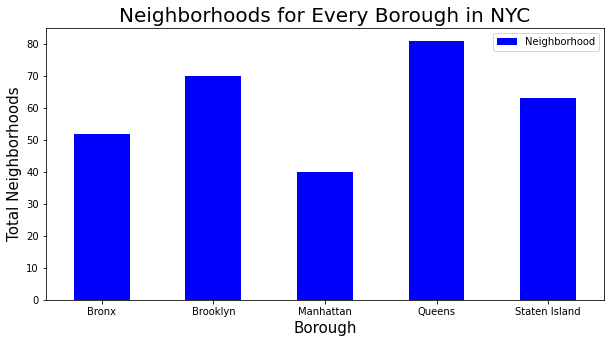

In [207]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods for Every Borough in NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Seems like Queens has the most neighborhood, while manhattan has the least neighborhood here.

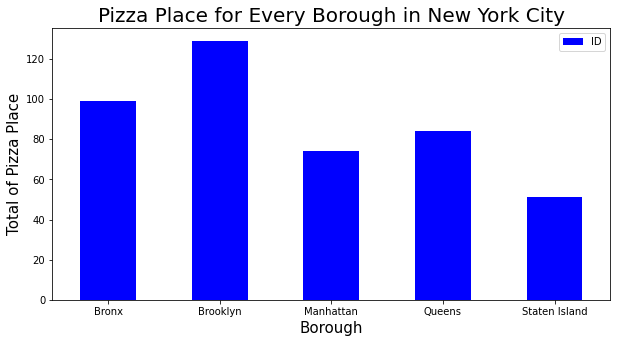

In [208]:
dfPizzaPlaceNY.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Pizza Place for Every Borough in New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total of Pizza Place', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

While Queens has the most neighborhood, it seems like there are not much pizza place here, compared to Brooklyn and Bronx. Here shows that Brooklyn has the most pizza place here.

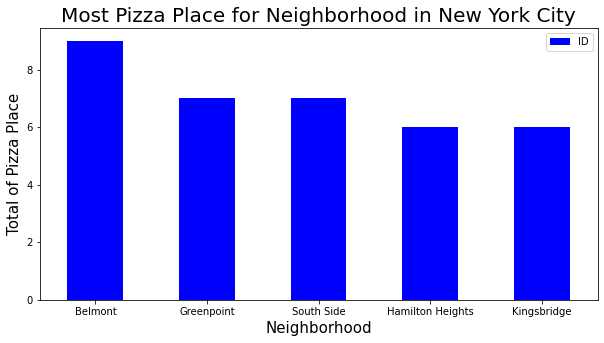

In [209]:
dfPizzaPlaceNY.groupby('Neighborhood')['ID'].count().nlargest(5).plot.bar(figsize=(10,5), color='blue')
plt.title('Most Pizza Place for Neighborhood in New York City', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Total of Pizza Place', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [210]:
dfPizzaPlaceNY[dfPizzaPlaceNY['Neighborhood'] == 'Belmont']

Borough Neighborhood                        ID  \
59   Bronx      Belmont  4aee1220f964a520ced121e3   
60   Bronx      Belmont  4aabd3e6f964a5204a5a20e3   
61   Bronx      Belmont  4b2a6ba8f964a520d9a824e3   
62   Bronx      Belmont  4b140a90f964a520489c23e3   
63   Bronx      Belmont  53bf0f0b498e192333913ab2   
64   Bronx      Belmont  4b97fc62f964a5202a2435e3   
65   Bronx      Belmont  4d03ef588620224bff0ba640   
66   Bronx      Belmont  4b180daaf964a52024cc23e3   
67   Bronx      Belmont  575adfe8cd10afcbbf8d1a66   

                              Name  
59              Full Moon Pizzeria  
60                  Zero Otto Nove  
61                   Pugsley Pizza  
62                 Bellini's Pizza  
63          Pizza Studio - Fordham  
64             Tony & Tina's Pizza  
65  Catania's Pizzeria & Cafe Inc.  
66   University Pizza & Restaurant  
67                     Bella Pizza

While Brooklyn has the most pizza place among borough; Belmont has the most pizza place among neighborhood, and it's actually located at Bronx, not Brooklyn.

In [229]:
dfAvgInfoNeighborhood = dfPizzaPlaceNYdetail.groupby('Neighborhood', as_index=False)[['Likes', 'Rating', 'Tips']].mean()
dfAvgInfoNeighborhood = pd.merge(dfAvgInfoNeighborhood,ny_data, on='Neighborhood')
dfAvgInfoNeighborhood.columns = ['Neighborhood', 'Average Likes', 'Average Rating', 'Average Tips', 'Borough', 'Latitude', 
                                 'Longitude']
dfAvgInfoNeighborhood.head()

Neighborhood  Average Likes  Average Rating  Average Tips        Borough  \
0       Allerton       2.333333             6.8      3.333333          Bronx   
1  Arden Heights      12.000000             7.6      7.000000  Staten Island   
2       Arrochar       7.000000             8.4      2.000000  Staten Island   
3        Arverne      18.000000             7.2      8.000000         Queens   
4        Astoria      40.000000             7.8     22.666667         Queens   

    Latitude  Longitude  
0  40.865788 -73.859319  
1  40.549286 -74.185887  
2  40.596313 -74.067124  
3  40.589144 -73.791992  
4  40.768509 -73.915654

In [239]:
dfTopRatingNeighborhood = dfAvgInfoNeighborhood.nlargest(20,'Average Rating')
dfTopRatingNeighborhood

Neighborhood  Average Likes  Average Rating  Average Tips  \
58               Elmhurst      62.000000        9.200000         25.00   
32              Chinatown     239.000000        9.100000         61.00   
67   Forest Hills Gardens     194.000000        9.100000         95.00   
129            North Side     284.800000        9.020000         58.20   
24          Carnegie Hill     176.000000        9.000000         61.50   
155                  Soho     794.500000        8.950000        127.50   
46          Cypress Hills      21.000000        8.900000         13.00   
57               Elm Park     225.000000        8.900000        110.00   
70          Fresh Meadows      14.000000        8.900000          9.00   
81      Greenwich Village     321.000000        8.900000        111.00   
75                Gowanus     108.000000        8.800000         24.50   
111               Midtown     188.000000        8.800000         44.50   
169            Tudor City     143.000000        8.800000         51.00   
105      Manhattan Valley     111.500000        8.700000         52.00   
131       Oakland Gardens      27.000000        8.700000         10.00   
53           East Village     249.750000        8.675000         92.75   
100          Little Italy     533.666667        8.666667         85.00   
126                  Noho      88.500000        8.625000         21.50   
19              Bronxdale      47.000000        8.600000         27.00   
180              Woodlawn      21.000000        8.600000          8.00   

           Borough   Latitude  Longitude  
58          Queens  40.744049 -73.881656  
32       Manhattan  40.715618 -73.994279  
67          Queens  40.714611 -73.841022  
129       Brooklyn  40.714823 -73.958809  
24       Manhattan  40.782683 -73.953256  
155      Manhattan  40.722184 -74.000657  
46        Brooklyn  40.682391 -73.876616  
57   Staten Island  40.630147 -74.141817  
70          Queens  40.734394 -73.782713  
81       Manhattan  40.726933 -73.999914  
75        Brooklyn  40.673931 -73.994441  
111      Manhattan  40.754691 -73.981669  
169      Manhattan  40.746917 -73.971219  
105      Manhattan  40.797307 -73.964286  
131         Queens  40.745619 -73.754950  
53       Manhattan  40.727847 -73.982226  
100      Manhattan  40.719324 -73.997305  
126      Manhattan  40.723259 -73.988434  
19           Bronx  40.852723 -73.861726  
180          Bronx  40.898273 -73.867315

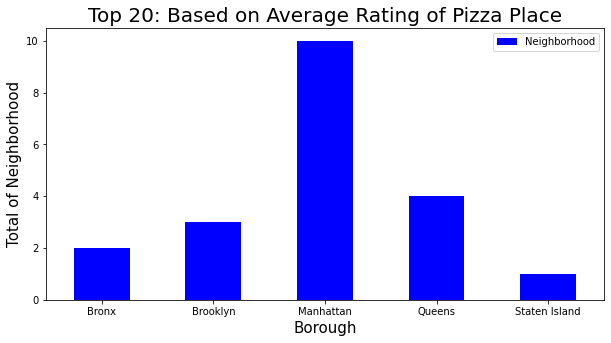

In [254]:
dfTopRatingNeighborhood.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Top 20: Based on Average Rating of Pizza Place', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total of Neighborhood', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

From top 20 of highest average rating, Manhattan have 10 neighborhood. Apparently; if you want to find one of the best rated pizza place, look no further to Manhattan. While Manhattan have lesser pizza place compared to other borough, they know how to make customers happy.

In [243]:
dfBottomRatingNeighborhood = dfAvgInfoNeighborhood.nsmallest(20,'Average Rating')
dfBottomRatingNeighborhood

Neighborhood  Average Likes  Average Rating  Average Tips  \
74              Glendale       3.000000        5.600000      4.000000   
83     Heartland Village       5.000000        5.700000      8.000000   
125      New Springville       5.000000        5.700000      8.000000   
103              Madison       8.000000        5.800000      7.000000   
167        Tompkinsville       1.000000        5.800000      3.000000   
102      Lower East Side       8.000000        6.000000     34.000000   
42             Concourse       0.000000        6.100000      1.000000   
143      Queensboro Hill      10.000000        6.200000     11.000000   
152                Rugby       4.000000        6.200000      2.000000   
96   Kingsbridge Heights       4.750000        6.300000      3.500000   
12               Bayside       3.666667        6.300000      3.000000   
55              Edgemere       0.000000        6.300000      0.000000   
120           Mount Eden       0.000000        6.300000      5.000000   
78             Gravesend       5.500000        6.300000      4.000000   
84          High  Bridge       0.500000        6.350000      2.000000   
119           Mott Haven       5.500000        6.350000      4.500000   
109              Melrose       1.666667        6.366667      1.666667   
73       Gerritsen Beach       5.000000        6.400000      8.000000   
34             City Line       8.000000        6.500000     10.000000   
86             Homecrest       6.500000        6.500000      5.500000   

           Borough   Latitude  Longitude  
74          Queens  40.702762 -73.870742  
83   Staten Island  40.589139 -74.159022  
125  Staten Island  40.594252 -74.164960  
103       Brooklyn  40.609378 -73.948415  
167  Staten Island  40.637316 -74.080554  
102      Manhattan  40.717807 -73.980890  
42           Bronx  40.834284 -73.915589  
143         Queens  40.744572 -73.825809  
152       Brooklyn  40.655572 -73.926882  
96           Bronx  40.870392 -73.901523  
12          Queens  40.766041 -73.774274  
55          Queens  40.595642 -73.776133  
120          Bronx  40.843826 -73.916556  
78        Brooklyn  40.595260 -73.973471  
84           Bronx  40.836623 -73.926102  
119          Bronx  40.806239 -73.916100  
109          Bronx  40.819754 -73.909422  
73        Brooklyn  40.590848 -73.930102  
34        Brooklyn  40.678570 -73.867976  
86        Brooklyn  40.598525 -73.959185

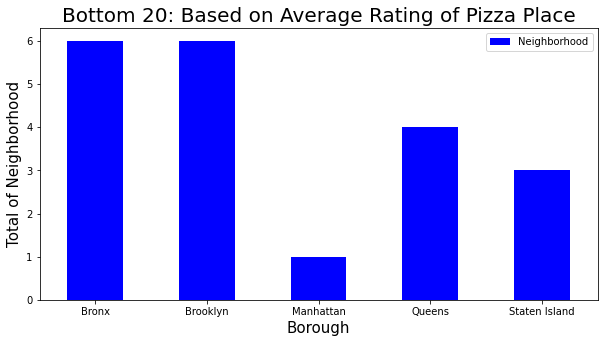

In [255]:
dfBottomRatingNeighborhood.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Bottom 20: Based on Average Rating of Pizza Place', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total of Neighborhood', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Quality over quantity. While Brooklyn and Bronx have the most pizza place, their neighborhood have some of the lowest average rating given by user of Foursquare. An observation; in terms of rating, Manhattan have the best rated pizza place around their neighborhood. Need to confirm by calculating all neighborhood instead of only top or bottom 20 of neighborhood.

In [216]:
dfAvgInfoBorough = dfPizzaPlaceNYdetail.groupby('Borough',as_index=False)[['Likes', 'Rating', 'Tips']].mean()
dfAvgInfoBorough.columns = ['Borough', 'Average Likes', 'Average Rating', 'Average Tips']
dfAvgInfoBorough

Borough  Average Likes  Average Rating  Average Tips
0          Bronx      13.658228        7.162025      7.645570
1       Brooklyn     112.765766        7.612613     42.648649
2      Manhattan     172.958333        8.193056     52.694444
3         Queens      27.111111        7.519444     13.333333
4  Staten Island      26.500000        7.450000     13.968750

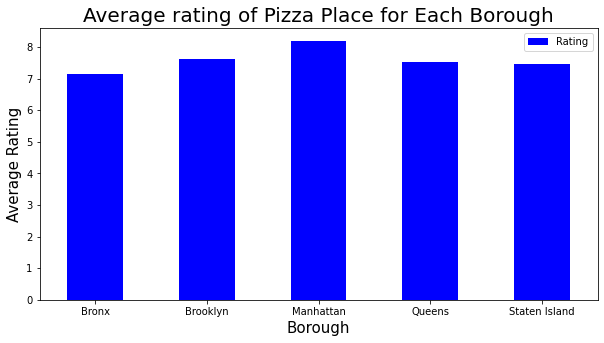

In [246]:
dfPizzaPlaceNYdetail.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color='blue')
plt.title('Average rating of Pizza Place for Each Borough',fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Here is the pizza place that received the highest rating given by user on Foursquare, and it is not at Manhattan actually.

In [215]:
dfPizzaPlaceNYdetail.iloc[dfPizzaPlaceNYdetail['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Kingsbridge
ID              58935fd798f8aa7c14662653
Name             Kingsbridge Social Club
Likes                                 48
Rating                               9.5
Tips                                  10
Name: 2, dtype: object

In [251]:
dfTopLikesNeighborhood = dfAvgInfoNeighborhood.nlargest(20,'Average Likes')
dfTopLikesNeighborhood

Neighborhood  Average Likes  Average Rating  Average Tips  \
50                  Dumbo    1072.500000        8.350000    456.000000   
71           Fulton Ferry    1072.500000        8.350000    456.000000   
30                Chelsea     927.000000        8.100000    298.000000   
31                Chelsea     927.000000        8.100000    298.000000   
155                  Soho     794.500000        8.950000    127.500000   
176          West Village     577.500000        8.550000    197.500000   
100          Little Italy     533.666667        8.666667     85.000000   
81      Greenwich Village     321.000000        8.900000    111.000000   
129            North Side     284.800000        9.020000     58.200000   
121           Murray Hill     254.250000        8.000000     90.500000   
122           Murray Hill     254.250000        8.000000     90.500000   
80             Greenpoint     253.000000        8.042857     76.857143   
53           East Village     249.750000        8.675000     92.750000   
32              Chinatown     239.000000        9.100000     61.000000   
57               Elm Park     225.000000        8.900000    110.000000   
62     Financial District     205.600000        8.460000     66.200000   
67   Forest Hills Gardens     194.000000        9.100000     95.000000   
111               Midtown     188.000000        8.800000     44.500000   
115   Morningside Heights     177.000000        7.700000    117.000000   
24          Carnegie Hill     176.000000        9.000000     61.500000   

           Borough   Latitude  Longitude  
50        Brooklyn  40.703176 -73.988753  
71        Brooklyn  40.703281 -73.995508  
30       Manhattan  40.744035 -74.003116  
31   Staten Island  40.594726 -74.189560  
155      Manhattan  40.722184 -74.000657  
176      Manhattan  40.734434 -74.006180  
100      Manhattan  40.719324 -73.997305  
81       Manhattan  40.726933 -73.999914  
129       Brooklyn  40.714823 -73.958809  
121      Manhattan  40.748303 -73.978332  
122         Queens  40.764126 -73.812763  
80        Brooklyn  40.730201 -73.954241  
53       Manhattan  40.727847 -73.982226  
32       Manhattan  40.715618 -73.994279  
57   Staten Island  40.630147 -74.141817  
62       Manhattan  40.707107 -74.010665  
67          Queens  40.714611 -73.841022  
111      Manhattan  40.754691 -73.981669  
115      Manhattan  40.808000 -73.963896  
24       Manhattan  40.782683 -73.953256

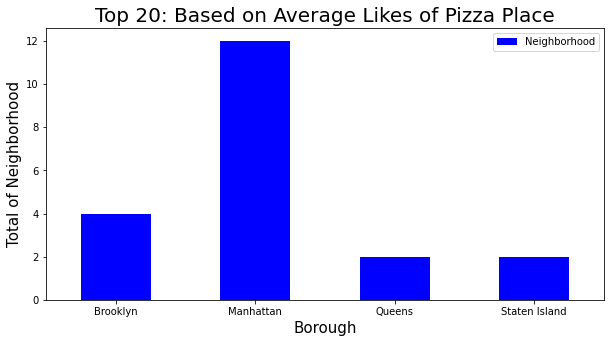

In [253]:
dfTopLikesNeighborhood.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Top 20: Based on Average Likes of Pizza Place', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total of Neighborhood', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

No Bronx here, although they have more pizza place than Manhattan, Queens, and Staten Island. From top 20 of neighborhood, 12 of them is from Manhattan.

In [256]:
dfBottomLikesNeighborhood = dfAvgInfoNeighborhood.nsmallest(20,'Average Likes')
dfBottomLikesNeighborhood

Neighborhood  Average Likes  Average Rating  Average Tips  \
42            Concourse       0.000000        6.100000      1.000000   
55             Edgemere       0.000000        6.300000      0.000000   
120          Mount Eden       0.000000        6.300000      5.000000   
171  University Heights       0.000000        6.500000      0.500000   
84         High  Bridge       0.500000        6.350000      2.000000   
167       Tompkinsville       1.000000        5.800000      3.000000   
109             Melrose       1.666667        6.366667      1.666667   
35    Claremont Village       2.000000        6.600000      0.000000   
132            Old Town       2.000000        6.700000      2.000000   
0              Allerton       2.333333        6.800000      3.333333   
21          Brownsville       3.000000        6.600000      5.000000   
74             Glendale       3.000000        5.600000      4.000000   
88          Hunts Point       3.000000        6.900000      5.000000   
153       Schuylerville       3.000000        7.100000      4.000000   
90      Jackson Heights       3.500000        7.650000      5.500000   
177  Westchester Square       3.500000        6.800000      7.000000   
12              Bayside       3.666667        6.300000      3.000000   
43    Concourse Village       4.000000        7.300000      4.000000   
60              Erasmus       4.000000        6.900000      1.000000   
152               Rugby       4.000000        6.200000      2.000000   

           Borough   Latitude  Longitude  
42           Bronx  40.834284 -73.915589  
55          Queens  40.595642 -73.776133  
120          Bronx  40.843826 -73.916556  
171          Bronx  40.855727 -73.910416  
84           Bronx  40.836623 -73.926102  
167  Staten Island  40.637316 -74.080554  
109          Bronx  40.819754 -73.909422  
35           Bronx  40.831428 -73.901199  
132  Staten Island  40.596329 -74.087511  
0            Bronx  40.865788 -73.859319  
21        Brooklyn  40.663950 -73.910235  
74          Queens  40.702762 -73.870742  
88           Bronx  40.809730 -73.883315  
153          Bronx  40.826580 -73.826203  
90          Queens  40.751981 -73.882821  
177          Bronx  40.840619 -73.842194  
12          Queens  40.766041 -73.774274  
43           Bronx  40.824780 -73.915847  
60        Brooklyn  40.646926 -73.948177  
152       Brooklyn  40.655572 -73.926882

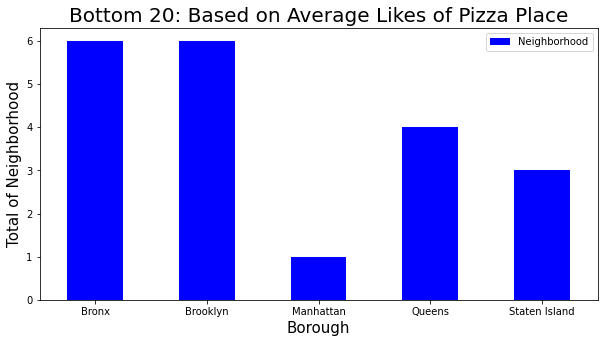

In [261]:
dfBottomRatingNeighborhood.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Bottom 20: Based on Average Likes of Pizza Place', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total of Neighborhood', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

A similar pattern of bar chart compared to previous chart of average rating of bottom 20. Bronx and Brooklyn have 6 neighborhood that have least average like of pizza place. New business of pizza place should take advantage of these neighborhood.

In [258]:
dfAvgInfoBorough

Borough  Average Likes  Average Rating  Average Tips
0          Bronx      13.658228        7.162025      7.645570
1       Brooklyn     112.765766        7.612613     42.648649
2      Manhattan     172.958333        8.193056     52.694444
3         Queens      27.111111        7.519444     13.333333
4  Staten Island      26.500000        7.450000     13.968750

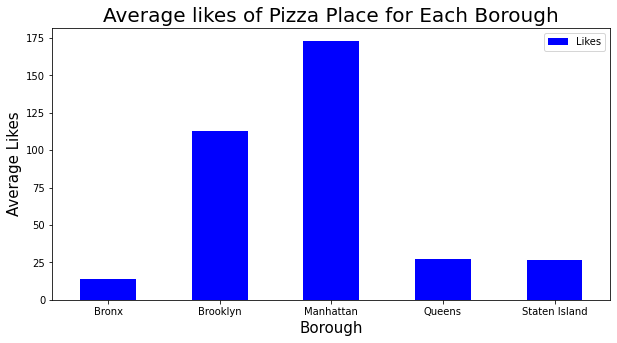

In [260]:
dfPizzaPlaceNYdetail.groupby('Borough').mean()['Likes'].plot.bar(figsize=(10,5), color='blue')
plt.title('Average likes of Pizza Place for Each Borough',fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Likes', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

We see a 2 groups here; Brooklyn and Manhattan have more than 100 average likes, while the rest did not even manage to get more than 30 average like. A big gap here.

In [248]:
dfAvgInfoNeighborhood.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Neighborhood    183 non-null    object 
 1   Average Likes   183 non-null    float64
 2   Average Rating  183 non-null    float64
 3   Average Tips    183 non-null    float64
 4   Borough         183 non-null    object 
 5   Latitude        183 non-null    float64
 6   Longitude       183 non-null    float64
dtypes: float64(5), object(2)
memory usage: 11.4+ KB


In [249]:
mapPizzaAvgNYC = folium.Map(location=geo_location('New York City, NY'), zoom_start=10)
mapRating = folium.map.FeatureGroup()

for lat, lng, in dfAvgInfoNeighborhood[['Latitude','Longitude']].values:
    mapRating.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7)
    )

mapPizzaAvgNYC.add_child(mapRating)

Brooklyn has the most pizza place compared to other borough.

**6. Result and conclusion**

On average, Manhattan have the best rated pizza place. The fact that they have less number of pizza place, shows the quality over quantity. In terms of quality, Manhattan and Brooklyn have better pizza place compared to other borough. 

Assuming the number of likes from Foursquare is from visitors, people love to go to pizza place at Manhattan and Brooklyn. Judging from the number of likes, there are less visitors at Bronx, Queens, and Staten Island compared to the other 2. Especially for Bronx, since they have the 2nd highest of pizza place among 5 borough. Apparently, Bronx have the least likes for pizza place. In terms of visitors, again, Manhattan and Brooklyn is the place to go.

As a result, I would suggest to open the pizza place at Manhattan and Brooklyn. Seems like this borough get encouraging responses from the visitors. However, as both borough have the highest average rating, one need to wonder if our products and services can compete with another pizza place that already operating here. A safety measure, if the businessman do not want to compete with those establish pizza place, one can start at neighborhood that have a lower average rating; which are Lower East Side (Manhattan) and Madison, Rugby, Gravesend, Gerritsen Beach, City Line, Homecrest (Brooklyn).

As a final note, worth to mention that all of the above analysis is depending on the accuracy of data on Foursquare. A more comprehensive analysis and future work would need to incorporate data from other external databases.